<div style="text-align: center;">
    <font size="7"><b>Predicting Salaries Data</b></font>
</div>

<div class="c">
This notebook is building a simple multiregression model to make predictions on salary. It uses salaries data that was cleaned in the Salaries_Preparation notebook.<br>
There are 4 main goals:<br>
    &nbsp;&nbsp;&nbsp;&nbsp - Build a Baseline multiregression model that can be validated with Glassdoor data.<br>
    &nbsp;&nbsp;&nbsp;&nbsp - Create an Expanded model, that contains parameters not available from Glassdoor. <br>
    &nbsp;&nbsp;&nbsp;&nbsp - Extract the coefficient that will yield the effect of these parameters which are normalized properly with all the other variables. <br>
    &nbsp;&nbsp;&nbsp;&nbsp - Make a personalized salary prediction.
</div>

<font size="6"><b>Table of Content:</b></font>

In [47]:
import sys
sys.path.append('../')
from scripts.tableofcontent_generator import generate_toc
notebook_path = '../notebooks/Salaries_Prediction.ipynb'

In [48]:
toc_content = generate_toc(notebook_path)
print(toc_content)

     1 Import libraries & data, general settings
         1.1 Styles
     2 Preparing Dataframes
         2.1 Western & Developed countries
         2.2 Glassdoor salary values
         2.3 Exclusion categories
         2.4 Data-professionals
     3 CV in each factorial cell to get a feeling for RMSE and R-squared
     4 Multiregression
             4.0.1 Functions
             4.0.2 Plotting functions
         4.1 Combined Dataframe
             4.1.1 Initial fitting
                 4.1.1.1 Checking Residuals: Normality
                 4.1.1.2 Checking Residuals: Homoscedasticity
             4.1.2 Influential points
                 4.1.2.1 Comparing VIFs
             4.1.3 Refitting w/o influential points
                 4.1.3.1 Checking Residuals: Normality
                 4.1.3.2 Checking Residuals: Homoscedasticity
             4.1.4 Making a prediction
                 4.1.4.1 Plotting the prediction
             4.1.5 The result
         4.2 DF-AI
             4.2.1 Initial

# Import libraries & data, general settings

In [50]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import datetime as dt
from datetime import datetime
import re
from IPython.display import HTML, display

import statsmodels.api as sm
from statsmodels.formula.api import ols
import statsmodels.stats.multicomp as mc
from scipy.stats import levene, shapiro

# If the notebook is opened from the "notebooks" folder, we need to append the main directory to the "python path" so it sees all subfolders.
import sys
sys.path.append('../')

In [51]:
df_it = pd.read_csv('../data/cleaned/df_it.csv', low_memory=False)
df_k = pd.read_csv('../data/cleaned/df_k.csv', low_memory=False)
df_ai = pd.read_csv('../data/cleaned/df_ai.csv', low_memory=False)

## Styles 

In [53]:
# General Display settings

# Column display is supressed by default
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)

#changing the display format
pd.set_option('display.float_format', lambda x: '%.2f' % x)

# Plotting format
#print(plt.style.available)
plt.style.use('seaborn-v0_8-whitegrid')

In [54]:
style_light_theme = """
<style>
h1 {
    background-color: #0e2e3b;
    color: white;
    font-size: 40px !important;
    font-weight: 700 !important;
    padding: 10px;
}
h2 {
    background-color: #07447E;
    color: white;
    font-size: 35px !important;
    font-weight: 700 !important;
    padding: 10px;
}
h3 {
    background-color: #047c98;
    color: white;
    font-size: 30px !important;
    font-weight: 700 !important;
    padding: 10px;
}
h4 {
    background-color: #0AB89E;
    color: white;
    font-size: 25px !important;
    font-weight: 700 !important;
    padding: 5px;
}
/* ----------------------------------  Conclusion class */
.c {
    background-color: #f7fe9a;
    color: black;
    padding: 10px 10px 10px 20px;        /* Top, Right, Bottom, Left */
    font-size: 16px;
    font-style: italic;
}
/* ----------------------------------  Note class */
.note {
    background-color: #f4fcc0;
    color: black;
    padding: 2px 10px 2px 20px;        /* Top, Right, Bottom, Left */
    font-size: 14px;
    font-style: italic;
}
</style>
"""

In [55]:
#display(HTML(style_dark_theme))
display(HTML(style_light_theme))

# Preparing Dataframes

## Western & Developed countries

In [58]:
western_countries = [
    'al', 'ad', 'am', 'at', 'az', 'by', 'be', 'ba', 'bg', 'hr',
    'cy', 'cz', 'dk', 'ee', 'fi', 'fr', 'ge', 'de', 'gr', 'hu',
    'is', 'ie', 'it', 'kz', 'xk', 'lv', 'li', 'lt', 'lu', 'mt',
    'md', 'mc', 'me', 'nl', 'mk', 'no', 'pl', 'pt', 'ro', 'ru',
    'sm', 'rs', 'sk', 'si', 'es', 'se', 'ch', 'tr', 'ua', 'gb',
    'va', 'ca', 'au', 'us'
]

In [59]:
western_countries = ['de', 'gb', 'nl', 'se', 'dk', 'be', 'fi', 'at', 'ch', 'ie', 'ca', 'au', 'us']

In [60]:
df_ai_w = df_ai.copy()
df_ai_w['country'] = df_ai_w['country'][df_ai_w['country'].isin(western_countries)]

df_k_w = df_k.copy()
df_k_w['country'] = df_k_w['country'][df_k_w['country'].isin(western_countries)]

In [61]:
# df_ai_d = df_ai.copy()
# df_ai_d['country'] = df_ai_d['country'][df_ai_d['country'].isin(developed_countries)]
# 
# df_k_d = df_k.copy()
# df_k_d['country'] = df_k_d['country'][df_k_d['country'].isin(developed_countries)]

In [62]:
# GDP per capita data (in USD)
gdp_per_capita = {
    'fr': 40886, 'in': 2016, 'au': 65099, 'us': 76329, 'nl': 57025, 
    'de': 48717, 'ie': 87947, 'ru': 15270, 'gr': 19829, 'ua': 4533, 
    'pk': 1491, 'jp': 40066, 'br': 8697, 'kr': 31961, 
    'by': 7888, 'ng': 2229, 'gb': 46125, 'se': 53755, 'mx': 10657, 
    'ca': 54917, 'pt': 23758, 'pl': 17939, 'id': 4289, 'it': 34776, 
    'cz': 23906, 'es': 31688, 'cl': 14938, 'hk': 46544, 'za': 6001, 
    'ar': 10461, 'tr': 10674, 'il': 44162, 'tw': 34166, 'eg': 3801, 
    'ma': 3585, 'hu': 18390, 'co': 6214, 'no': 89111, 'th': 7775, 
    'ch': 93259, 'vn': 3704, 'sg': 59806, 'bd': 1964, 'ir': 2273, 
    'pe': 7002, 'ke': 2066, 'ro': 15786, 'cn': 12710, 'be': 50126, 
    'at': 52084, 'dz': 4094, 'nz': 45380, 'tn': 3840, 'ph': 3593, 
    'my': 11109, 'dk': 61612, 'sa': 20619, 'ae': 43103, 'np': 1192, 
    'lk': 3841, 'gh': 2396, 'et': 936, 'iq': 4922, 'ec': 6245, 
    'kz': 10153, 'ug': 817, 'cm': 1500, 'zw': 1098, 
    'lv': 21779, 'ge': 4804, 'lt': 25064, 'fi': 53012, 'hr': 15647, 'om': 25056, 'ba': 7568, 'ee': 28247, 
    'mt': 34127, 'lb': 4136, 'si': 28439, 'mu': 10256, 'am': 7018, 'qa': 87661, 'ad': 41992, 'md': 5714,
    'uz': 2255, 'cf': 427, 'kw': 41079, 'cy': 32048, 'as': 19673, 'cr': 13365, 'pr': 35208, 'bo': 3600,
    'do': 8793, 'hn': 2736, 'bg': 12623, 'je': 55820, 'rs': 9260,  'lu': 125006
}

## Glassdoor salary values

In [64]:
glassdoor_data = pd.DataFrame({
    'job_category': ['Data Analyst', 'Data Analyst', 'Data Engineer', 'Data Engineer', 'Software Engineer'],
    'seniority_level': ['junior', 'senior', 'senior', 'senior', 'senior'],
    'country': ['us', 'de', 'us', 'us', 'de'],
    'glassdoor_lower': [50000, 73000, 60000, 80000, 65000],
    'glassdoor_upper': [70000, 108000, 80000, 100000, 90000]
})


In [65]:
# Define the column names
columns = ['job_category', 'seniority_level', 'country', 'glassdoor_lower', 'glassdoor_upper']

# Create a list of tuples
glassdoor_data_rows = [
    ('Data Analyst', 'junior', 'us', 81000, 134000),
    ('Data Analyst', 'medior', 'us', 86000, 144000),
    ('Data Analyst', 'senior', 'us', 88000, 150000),
    ('Data Analyst', 'junior', 'de', 55000, 71000),
    ('Data Analyst', 'medior', 'de', 58000, 82000),
    ('Data Analyst', 'senior', 'de', 68000, 93000),
    ('Data Engineer', 'junior', 'us', 96000, 157000),
    ('Data Engineer', 'medior', 'us', 109000, 179000),
    ('Data Engineer', 'senior', 'us', 121000, 198000),
    ('Data Engineer', 'junior', 'de', 62500, 81000),
    ('Data Engineer', 'medior', 'de', 69000, 90100),
    ('Data Engineer', 'senior', 'de', 73500, 94000),
    ('Data Scientist/ ML Engineer', 'junior', 'us', 129000, 210000),
    ('Data Scientist/ ML Engineer', 'medior', 'us', 140000, 232000),
    ('Data Scientist/ ML Engineer', 'senior', 'us', 149000, 251000),
    ('Data Scientist/ ML Engineer', 'junior', 'de', 63500, 83000),
    ('Data Scientist/ ML Engineer', 'medior', 'de', 74500, 98500),
    ('Data Scientist/ ML Engineer', 'senior', 'de', 72000, 104000),
]

# Create the DataFrame
glassdoor_data = pd.DataFrame.from_records(glassdoor_data_rows, columns=columns)

In [66]:
# Define the column names
columns = ['job_category', 'seniority_level', 'country', 'glassdoor_lower', 'glassdoor_upper']

# Create a list of tuples
glassdoor_data_rows = [
    ('Data Analyst', 'junior', 'us', 70000, 117000),
    ('Data Analyst', 'medior', 'us', 81000, 134000),
    ('Data Analyst', 'senior', 'us', 88000, 150000),
    
    ('Data Analyst', 'junior', 'de', 51500, 70000),
    ('Data Analyst', 'medior', 'de', 55000, 71000),
    ('Data Analyst', 'senior', 'de', 68000, 93000),
    
    ('Data Engineer', 'junior', 'us', 84000, 142000),
    ('Data Engineer', 'medior', 'us', 96000, 157000),
    ('Data Engineer', 'senior', 'us', 121000, 198000),
    
    ('Data Engineer', 'junior', 'de', 57000, 74500),
    ('Data Engineer', 'medior', 'de', 62500, 81000),
    ('Data Engineer', 'senior', 'de', 73500, 94000),
    
    ('Data Scientist/ ML Engineer', 'junior', 'us', 117000, 196000),
    ('Data Scientist/ ML Engineer', 'medior', 'us', 129000, 210000),
    ('Data Scientist/ ML Engineer', 'senior', 'us', 149000, 251000),
    
    ('Data Scientist/ ML Engineer', 'junior', 'de', 58000, 79000),
    ('Data Scientist/ ML Engineer', 'medior', 'de', 63500, 83000),
    ('Data Scientist/ ML Engineer', 'senior', 'de', 72000, 104000),
]

# Create the DataFrame
glassdoor_data = pd.DataFrame.from_records(glassdoor_data_rows, columns=columns)

## Exclusion categories

In [68]:
seniority_exclusion = ['other'] #executive

exclude_categories = ['Consultant', '"Other"', 'Uncategorized', 'Advocacy', 'Out of scope', 'Too vague answers', 'Other managers']
jobcategory_exclusion = ['Consultant', '"Other"', 'Uncategorized', 'Advocacy', 'Out of scope', 'Too vague answers']

In [69]:
# First we filter for western countries
df_ai_w= df_ai.copy()
df_it_w= df_it.copy()
df_k_w = df_k.copy()

# Western countries
df_ai_w = df_ai_w[df_ai_w['country'].isin(western_countries)].copy()
df_it_w = df_it_w[df_it_w['country'].isin(western_countries)].copy()
df_k_w = df_k_w[df_k_w['country'].isin(western_countries)].copy()

# Filter out rows where 'job_category' is in the exclude list
df_ai_w = df_ai_w[~df_ai_w['seniority_level'].isin(seniority_exclusion)]
df_it_w = df_it_w[~df_it_w['seniority_level'].isin(seniority_exclusion)]
df_k_w = df_k_w[~df_k_w['seniority_level'].isin(seniority_exclusion)]

df_ai_w = df_ai_w[~df_ai_w['job_category'].isin(jobcategory_exclusion)]
df_it_w = df_it_w[~df_it_w['job_category'].isin(jobcategory_exclusion)]
df_k_w = df_k_w[~df_k_w['job_category'].isin(jobcategory_exclusion)]

In [70]:
# Filtering out rows, which would result in Factorial Groups with less datapoint than the statistically required threshold

# Specify the minimum number of counts required to keep the group
min_count = 20

# Calculate the count of data points for each job category
group_counts1 = df_ai_w.groupby(['seniority_level', 'job_category'], observed=True)['salary_norm'].count().reset_index()
group_counts2 = df_it_w.groupby(['seniority_level', 'job_category'], observed=True)['salary_norm'].count().reset_index()
group_counts3 = df_k_w.groupby(['seniority_level', 'job_category'], observed=True)['salary_norm'].count().reset_index()

# Rename the count column for clarity
group_counts1.rename(columns={'salary_norm': 'count'}, inplace=True)
group_counts2.rename(columns={'salary_norm': 'count'}, inplace=True)
group_counts3.rename(columns={'salary_norm': 'count'}, inplace=True)

# Filter groups that meet the criteria
valid_groups1 = group_counts1[group_counts1['count'] >= min_count]
valid_groups2 = group_counts2[group_counts2['count'] >= min_count]
valid_groups3 = group_counts3[group_counts3['count'] >= min_count]

# Merge the valid groups back with the original dataframe to keep only the desired rows
df_ai_w_l = pd.merge(df_ai_w, valid_groups1[['seniority_level', 'job_category']], 
                       on=['seniority_level', 'job_category'], 
                       how='inner')

df_it_w_l = pd.merge(df_it_w, valid_groups2[['seniority_level', 'job_category']], 
                       on=['seniority_level', 'job_category'], 
                       how='inner')

df_k_w_l = pd.merge(df_k_w, valid_groups3[['seniority_level', 'job_category']], 
                       on=['seniority_level', 'job_category'], 
                       how='inner')

In [71]:
df_combined = pd.concat([df.dropna(axis=1, how='all') for df in [df_ai_w_l, df_it_w_l, df_k_w_l]])

## Data-professionals

In [73]:
data_fields = ['Data Analyst', 'Data Engineer', 'Data Scientist/ ML Engineer']

df_k_w_data =  df_k_w[df_k_w['job_category'].isin(data_fields)]
df_it_w_data = df_it[df_it['job_category'].isin(data_fields)]
df_ai_w_data = df_ai_w[df_ai_w['job_category'].isin(data_fields)]

In [74]:
df_k_w_data = df_k_w_data[(df_k_w_data['seniority_level'] != 'executive')]
df_it_w_data = df_it_w_data[(df_it_w_data['seniority_level'] != 'executive')]
df_it_w_data = df_it_w_data[(df_it_w_data['seniority_level'] != 'other')]
df_ai_w_data = df_ai_w_data[(df_ai_w_data['seniority_level'] != 'executive')]

# CV in each factorial cell to get a feeling for RMSE and R-squared

<div class="note">
CV (Coefficient of Variation) = Standard Deviation / Mean salary
</div> 

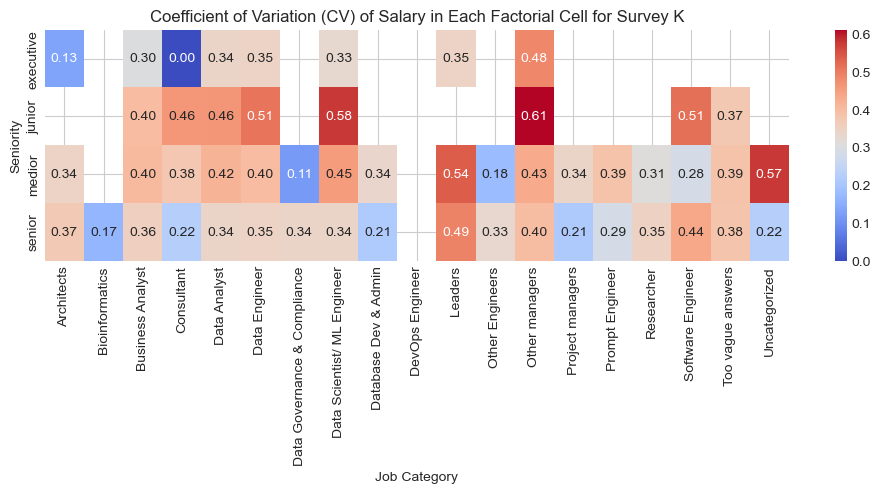

In [77]:
# Create a pivot table to calculate the mean salary in each factorial cell
pivot_table_mean = df_ai.pivot_table(index=['seniority_level'], columns='job_category', values='salary', aggfunc='mean', fill_value=0)

# Create a pivot table to calculate the standard deviation of salary in each factorial cell
pivot_table_std = df_ai.pivot_table(index=['seniority_level'], columns='job_category', values='salary', aggfunc='std', fill_value=0)

# Calculate the Coefficient of Variation (CV) by dividing std by the mean
pivot_table_cv = pivot_table_std / pivot_table_mean

# Plot the heatmap of CV
plt.figure(figsize=(12, 3))
sns.heatmap(pivot_table_cv, annot=True, fmt='.2f', cmap='coolwarm')
plt.title('Coefficient of Variation (CV) of Salary in Each Factorial Cell for Survey K')
plt.xlabel('Job Category')
plt.ylabel('Seniority')
plt.show()


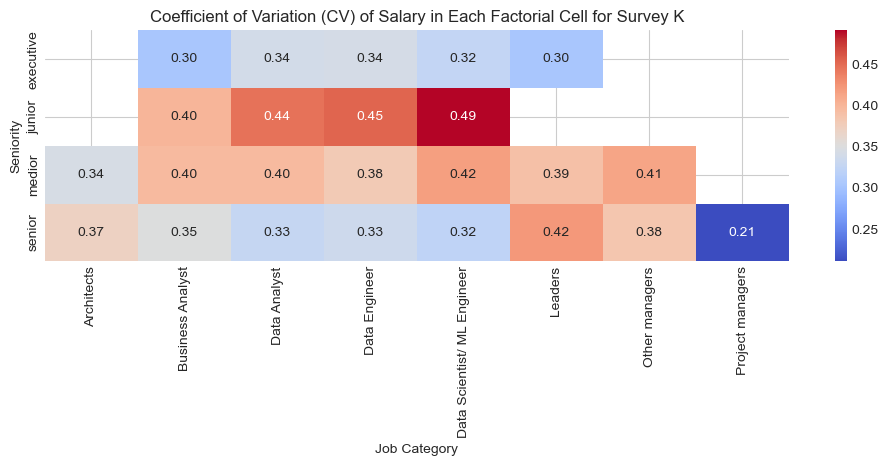

In [78]:
# Create a pivot table to calculate the mean salary in each factorial cell
pivot_table_mean = df_ai_w_l.pivot_table(index=['seniority_level'], columns='job_category', values='salary', aggfunc='mean', fill_value=0)

# Create a pivot table to calculate the standard deviation of salary in each factorial cell
pivot_table_std = df_ai_w_l.pivot_table(index=['seniority_level'], columns='job_category', values='salary', aggfunc='std', fill_value=0)

# Calculate the Coefficient of Variation (CV) by dividing std by the mean
pivot_table_cv = pivot_table_std / pivot_table_mean

# Plot the heatmap of CV
plt.figure(figsize=(12, 3))
sns.heatmap(pivot_table_cv, annot=True, fmt='.2f', cmap='coolwarm')
plt.title('Coefficient of Variation (CV) of Salary in Each Factorial Cell for Survey K')
plt.xlabel('Job Category')
plt.ylabel('Seniority')
plt.show()


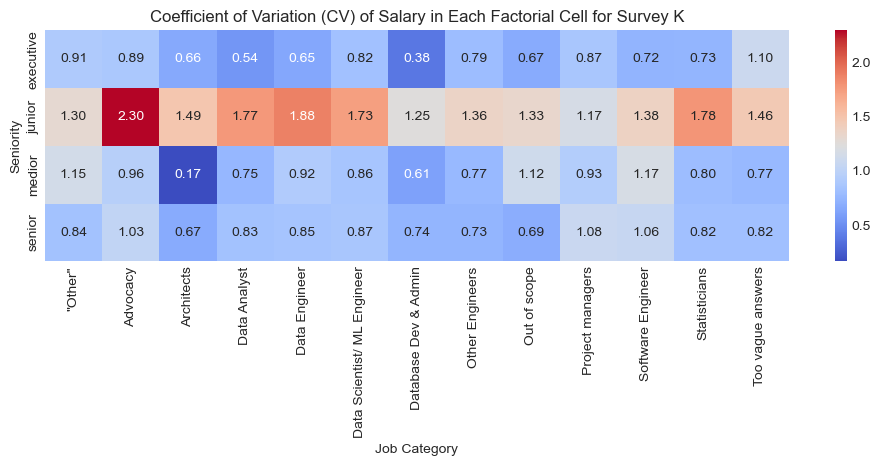

In [79]:
# Create a pivot table to calculate the mean salary in each factorial cell
pivot_table_mean = df_k.pivot_table(index=['seniority_level'], columns='job_category', values='salary', aggfunc='mean', fill_value=0)

# Create a pivot table to calculate the standard deviation of salary in each factorial cell
pivot_table_std = df_k.pivot_table(index=['seniority_level'], columns='job_category', values='salary', aggfunc='std', fill_value=0)

# Calculate the Coefficient of Variation (CV) by dividing std by the mean
pivot_table_cv = pivot_table_std / pivot_table_mean

# Plot the heatmap of CV
plt.figure(figsize=(12, 3))
sns.heatmap(pivot_table_cv, annot=True, fmt='.2f', cmap='coolwarm')
plt.title('Coefficient of Variation (CV) of Salary in Each Factorial Cell for Survey K')
plt.xlabel('Job Category')
plt.ylabel('Seniority')
plt.show()


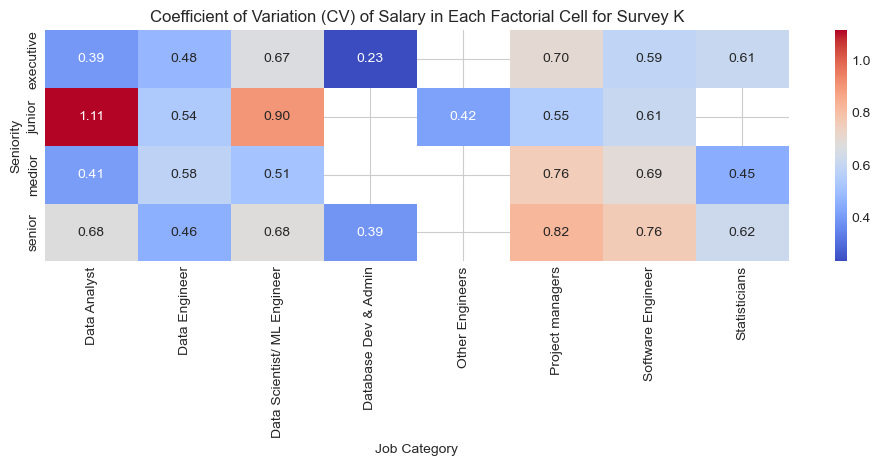

In [80]:
# Create a pivot table to calculate the mean salary in each factorial cell
pivot_table_mean = df_k_w_l.pivot_table(index=['seniority_level'], columns='job_category', values='salary', aggfunc='mean', fill_value=0)

# Create a pivot table to calculate the standard deviation of salary in each factorial cell
pivot_table_std = df_k_w_l.pivot_table(index=['seniority_level'], columns='job_category', values='salary', aggfunc='std', fill_value=0)

# Calculate the Coefficient of Variation (CV) by dividing std by the mean
pivot_table_cv = pivot_table_std / pivot_table_mean

# Plot the heatmap of CV
plt.figure(figsize=(12, 3))
sns.heatmap(pivot_table_cv, annot=True, fmt='.2f', cmap='coolwarm')
plt.title('Coefficient of Variation (CV) of Salary in Each Factorial Cell for Survey K')
plt.xlabel('Job Category')
plt.ylabel('Seniority')
plt.show()


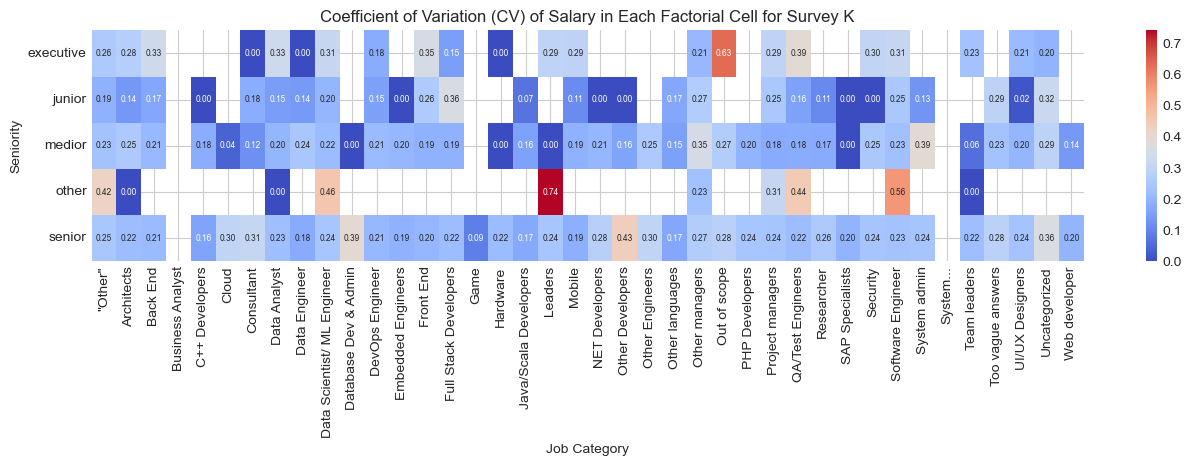

In [81]:
# Create a pivot table to calculate the mean salary in each factorial cell
pivot_table_mean = df_it.pivot_table(index=['seniority_level'], columns='job_category', values='salary', aggfunc='mean', fill_value=0)

# Create a pivot table to calculate the standard deviation of salary in each factorial cell
pivot_table_std = df_it.pivot_table(index=['seniority_level'], columns='job_category', values='salary', aggfunc='std', fill_value=0)

# Calculate the Coefficient of Variation (CV) by dividing std by the mean
pivot_table_cv = pivot_table_std / pivot_table_mean

# Plot the heatmap of CV
plt.figure(figsize=(16, 3))
sns.heatmap(pivot_table_cv, annot=True, fmt='.2f', cmap='coolwarm', annot_kws={"size": 6})
plt.title('Coefficient of Variation (CV) of Salary in Each Factorial Cell for Survey K')
plt.xlabel('Job Category')
plt.ylabel('Seniority')
plt.show()

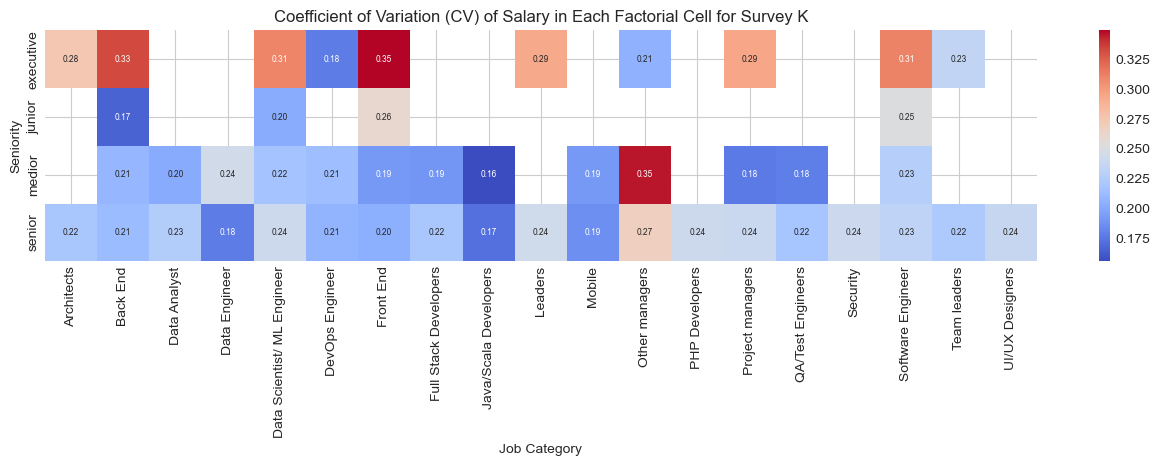

In [82]:
# Create a pivot table to calculate the mean salary in each factorial cell
pivot_table_mean = df_it_w_l.pivot_table(index=['seniority_level'], columns='job_category', values='salary', aggfunc='mean', fill_value=0)

# Create a pivot table to calculate the standard deviation of salary in each factorial cell
pivot_table_std = df_it_w_l.pivot_table(index=['seniority_level'], columns='job_category', values='salary', aggfunc='std', fill_value=0)

# Calculate the Coefficient of Variation (CV) by dividing std by the mean
pivot_table_cv = pivot_table_std / pivot_table_mean

# Plot the heatmap of CV
plt.figure(figsize=(16, 3))
sns.heatmap(pivot_table_cv, annot=True, fmt='.2f', cmap='coolwarm', annot_kws={"size": 6})
plt.title('Coefficient of Variation (CV) of Salary in Each Factorial Cell for Survey K')
plt.xlabel('Job Category')
plt.ylabel('Seniority')
plt.show()

# Multiregression

In [84]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np


from patsy import dmatrices
from scipy.stats import shapiro
from scipy.stats import lognorm

import statsmodels.api as sm
from statsmodels.tools.tools import add_constant
from statsmodels.stats.diagnostic import het_breuschpagan
from statsmodels.stats.outliers_influence import variance_inflation_factor

### Functions

In [86]:
def train_model_2301(X, y):
    """
    Trains a multilinear regression model using statsmodels, with one-hot encoding for categorical variables.
    Handles both numerical and categorical variables properly.
    
    Parameters:
    X (pd.DataFrame): Independent variables (can contain both categorical and numerical columns)
    y (pd.Series or pd.DataFrame): Dependent variable
    
    Returns:
    model: Fitted statsmodels regression model
    encoded_features: Dictionary containing feature names and their encodings for future use
    X_encoded: The encoded independent variables used in the model
    y: The dependent variable aligned with X_encoded
    """
    # Create copies to avoid modifying the original data
    X_copy = X.copy()
    y_copy = y.copy()
    
    # Dictionary to store category mappings
    encoded_features = {}
    
    # Process each column
    for column in X_copy.columns:
        # Check if column is categorical (object dtype) or contains strings
        if X_copy[column].dtype == 'object' or pd.api.types.is_string_dtype(X_copy[column]):
            # Store unique categories for this column
            encoded_features[column] = sorted(X_copy[column].unique().tolist())
    
    # One-hot encode categorical variables
    X_encoded = pd.get_dummies(X_copy, drop_first=True, dtype=float)
    
    # Add constant term
    X_encoded = sm.add_constant(X_encoded)
    
    # Convert y to float type if it isn't already
    y_copy = y_copy.astype(float)
    
    # Reset indices to ensure alignment
    X_encoded.reset_index(drop=True, inplace=True)
    y_copy.reset_index(drop=True, inplace=True)
    
    # Fit the model
    model = sm.OLS(y_copy, X_encoded).fit()
    
    return model, encoded_features, X_encoded, y_copy

In [87]:
import pandas as pd
import statsmodels.api as sm

def train_model_1617(X, y):
    """
    Trains a multilinear regression model using statsmodels, with one-hot encoding for categorical variables.
    Handles both numerical and categorical variables properly.
    
    Parameters:
    X (pd.DataFrame): Independent variables (can contain both categorical and numerical columns)
    y (pd.Series or pd.DataFrame): Dependent variable
    
    Returns:
    model: Fitted statsmodels regression model
    encoded_features: Dictionary containing feature names and their encodings for future use
    X_encoded: The encoded independent variables used in the model
    y: The dependent variable aligned with X_encoded
    """
    # Create copies to avoid modifying the original data
    X_copy = X.copy()
    y_copy = y.copy()
    
    # Dictionary to store category mappings
    encoded_features = {}
    
    # Process each column
    for column in X_copy.columns:
        # Check if column is categorical (object dtype) or contains strings
        if X_copy[column].dtype == 'object' or pd.api.types.is_string_dtype(X_copy[column]):
            # Fill NaN values with a placeholder
            X_copy[column] = X_copy[column].fillna('Missing')
            # Store unique categories for this column
            encoded_features[column] = sorted(X_copy[column].unique().tolist())
    
    # One-hot encode categorical variables
    X_encoded = pd.get_dummies(X_copy, drop_first=True, dtype=float)
    
    # Add constant term
    X_encoded = sm.add_constant(X_encoded)
    
    # Convert y to float type if it isn't already
    y_copy = y_copy.astype(float)
    
    # Reset indices to ensure alignment
    X_encoded.reset_index(drop=True, inplace=True)
    y_copy.reset_index(drop=True, inplace=True)
    
    # Fit the model
    model = sm.OLS(y_copy, X_encoded).fit()
    
    return model, encoded_features, X_encoded, y_copy

In [88]:
# Function to calculate leverage and Cook's Distance
def calculate_leverage_and_cooks_distance(model):
    # Get influence measures
    influence = model.get_influence()
    leverage = influence.hat_matrix_diag
    cooks_d = influence.cooks_distance[0]
    return leverage, cooks_d

# Function to plot leverage and Cook's Distance
def plot_leverage_and_cooks_distance(leverage, cooks_d, leverage_threshold=None, cooks_threshold=None):
    n = len(leverage)
    p = model.df_model  # Number of predictors (including dummy variables)
    
    if leverage_threshold is None:
        leverage_threshold = 2 * (p + 1) / n
    if cooks_threshold is None:
        cooks_threshold = 4 / n
    
    fig, ax = plt.subplots(1, 2, figsize=(14, 3))

    # Leverage Plot
    ax[0].scatter(range(n), leverage, alpha=0.5, s=5)
    ax[0].axhline(y=leverage_threshold, color='r', linestyle='--', label='Leverage Threshold')
    ax[0].set_ylim(0,0.06)
    ax[0].set_xlabel('Observation')
    ax[0].set_ylabel('Leverage')
    ax[0].set_title('Leverage Values')
    ax[0].legend()

    # Cook's Distance Plot
    ax[1].scatter(range(n), cooks_d, alpha=0.5, s=5)
    ax[1].axhline(y=cooks_threshold, color='r', linestyle='--', label="Cook's Distance Threshold")
    ax[1].set_ylim(0,0.005)
    ax[1].set_xlabel('Observation')
    ax[1].set_ylabel("Cook's Distance")
    ax[1].set_title("Cook's Distance Values")
    ax[1].legend()

    plt.tight_layout()
    plt.show()

In [89]:
def plot_model_coefficients(model, sizex, sizey):
    """
    Extracts and plots the coefficients from a statsmodels OLS regression model, excluding the intercept.
    Parameters:
    model (statsmodels.regression.linear_model.RegressionResultsWrapper): The fitted OLS model.
    """
    # Extract the coefficients and their names
    coefficients = model.params
    feature_names = coefficients.index
    
    # Create a DataFrame for coefficients
    coefficients_df = pd.DataFrame({
        'Feature': feature_names,
        'Coefficient': coefficients.values
    })

    # Remove the constant (intercept) term if it exists
    coefficients_df = coefficients_df[coefficients_df['Feature'] != 'const']
    
    # Sort the dataframe by coefficient values for better visualization
    coefficients_df_sorted = coefficients_df.sort_values(by='Coefficient')

    # Create a horizontal bar plot
    plt.figure(figsize=(sizex, sizey))
    sns.barplot(
        x='Coefficient',
        y='Feature',
        data=coefficients_df_sorted,
        hue='Feature',
        palette='coolwarm',
        orient='h',
        legend=False
    )

    # Add a vertical line at x=0 for reference
    plt.axvline(x=0, color='grey', linewidth=0.8)

    # Set plot title and labels
    plt.title('Regression Coefficients for Salary Prediction Model')
    plt.xlabel('Coefficient Value')
    plt.ylabel('Features')

    # Adjust layout to ensure all labels are visible
    plt.tight_layout()

    # Show the plot
    plt.show()

In [90]:
def calculate_rmse_original_scale(model, y_true_log):
    """
    Calculates RMSE on the original scale for a model trained with log-transformed values.

    Parameters:
    - model: The fitted statsmodels OLS model.
    - y_true_log: The actual log-transformed values of the dependent variable.

    Returns:
    - rmse_original: RMSE calculated on the original (non-logarithmic) scale.
    """
    # Calculate predictions in the log scale
    y_pred_log = model.fittedvalues

    # Back-transform predictions and actuals to the original scale
    y_pred = np.exp(y_pred_log)
    y_true = np.exp(y_true_log)

    # Calculate RMSE in the original scale
    rmse_original = np.sqrt(np.mean((y_true - y_pred) ** 2))

    return rmse_original

In [91]:
def predict_salary_for_case_log(model, encoded_features, specific_case):
    """
    Predicts the salary for a specific case using the statsmodels OLS model.

    Parameters:
    - model: The fitted statsmodels OLS model.
    - encoded_features: Dictionary containing feature names and their encodings.
    - specific_case: Dictionary of feature values for the specific case.

    Returns:
    - predicted_salary: The predicted salary (transformed back from log scale if applicable).
    """
    # Create a DataFrame for the specific case
    specific_case_df = pd.DataFrame([specific_case])

    # Initialize all features with zero values
    all_features = model.params.index.tolist()
    specific_case_encoded = pd.DataFrame(columns=all_features)
    specific_case_encoded.loc[0] = 0  # Initialize all features to zero

    # Handle categorical variables
    for column in encoded_features.keys():
        categories = encoded_features[column]
        # Skip the reference category due to drop_first=True
        for cat in categories[1:]:
            col_name = f"{column}_{cat}"
            if specific_case[column] == cat:
                specific_case_encoded.at[0, col_name] = 1
            else:
                specific_case_encoded.at[0, col_name] = 0

    # Handle numerical variables (if any)
    numerical_columns = [col for col in specific_case.keys() if col not in encoded_features.keys()]
    for col in numerical_columns:
        specific_case_encoded.at[0, col] = specific_case[col]

    # Add constant term
    specific_case_encoded['const'] = 1.0  # Ensure the constant term is included

    # Reorder columns to match the model's parameters
    specific_case_encoded = specific_case_encoded[model.params.index]

    # Ensure all columns are float64
    specific_case_encoded = specific_case_encoded.astype('float64')

    # Make the prediction
    predicted_log_salary = model.predict(specific_case_encoded)[0]

    # If the model was trained on log-transformed salaries, exponentiate to get the actual salary
    # Adjust this line if your target variable is not log-transformed
    predicted_salary = np.exp(predicted_log_salary)

    return predicted_salary

In [92]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
from scipy.stats import norm

def predict_salary_for_case_log_perc(model, encoded_features, specific_case):
    """
    Predicts the salary and calculates the 25th and 75th percentiles for a specific case
    using the statsmodels OLS model trained on log-transformed salaries.

    Parameters:
    - model: The fitted statsmodels OLS model.
    - encoded_features: Dictionary containing feature names and their encodings.
    - specific_case: Dictionary of feature values for the specific case.

    Returns:
    - predicted_salary: The predicted median salary (original scale).
    - p25_salary: The 25th percentile of the predicted salary distribution (original scale).
    - p75_salary: The 75th percentile of the predicted salary distribution (original scale).
    """
    # Create a DataFrame for the specific case
    specific_case_df = pd.DataFrame([specific_case])

    # Initialize all features with zero values
    all_features = model.params.index.tolist()
    specific_case_encoded = pd.DataFrame(columns=all_features)
    specific_case_encoded.loc[0] = 0  # Initialize all features to zero

    # Handle categorical variables
    for column in encoded_features.keys():
        categories = encoded_features[column]
        # Skip the reference category due to drop_first=True
        for cat in categories[1:]:
            col_name = f"{column}_{cat}"
            if specific_case[column] == cat:
                specific_case_encoded.at[0, col_name] = 1
            else:
                specific_case_encoded.at[0, col_name] = 0

    # Handle numerical variables (if any)
    numerical_columns = [col for col in specific_case.keys() if col not in encoded_features.keys()]
    for col in numerical_columns:
        specific_case_encoded.at[0, col] = specific_case[col]

    # Add constant term
    specific_case_encoded['const'] = 1.0  # Ensure the constant term is included

    # Reorder columns to match the model's parameters
    specific_case_encoded = specific_case_encoded[model.params.index]

    # Ensure all columns are float64
    specific_case_encoded = specific_case_encoded.astype('float64')

    # Make the prediction in log scale
    predicted_log_salary = model.predict(specific_case_encoded)[0]

    # Obtain the standard deviation of the residuals (sigma_log)
    sigma_log = np.sqrt(model.scale)

    # Compute the 25th and 75th percentiles in log space
    p25_log_salary = predicted_log_salary + norm.ppf(0.25) * sigma_log
    p75_log_salary = predicted_log_salary + norm.ppf(0.75) * sigma_log

    # Exponentiate to get the salaries in original scale
    predicted_salary = np.exp(predicted_log_salary)
    p25_salary = np.exp(p25_log_salary)
    p75_salary = np.exp(p75_log_salary)

    return predicted_salary, p25_salary, p75_salary


In [93]:
def predict_salary_for_case(model, encoded_features, specific_case):
    """
    Predicts the salary for a specific case using the statsmodels OLS model.

    Parameters:
    - model: The fitted statsmodels OLS model.
    - encoded_features: Dictionary containing feature names and their encodings.
    - specific_case: Dictionary of feature values for the specific case.

    Returns:
    - predicted_salary: The predicted salary (transformed back from log scale if applicable).
    """
    # Create a DataFrame for the specific case
    specific_case_df = pd.DataFrame([specific_case])

    # Initialize all features with zero values
    all_features = model.params.index.tolist()
    specific_case_encoded = pd.DataFrame(columns=all_features)
    specific_case_encoded.loc[0] = 0  # Initialize all features to zero

    # Handle categorical variables
    for column in encoded_features.keys():
        categories = encoded_features[column]
        # Skip the reference category due to drop_first=True
        for cat in categories[1:]:
            col_name = f"{column}_{cat}"
            if specific_case[column] == cat:
                specific_case_encoded.at[0, col_name] = 1
            else:
                specific_case_encoded.at[0, col_name] = 0

    # Handle numerical variables (if any)
    numerical_columns = [col for col in specific_case.keys() if col not in encoded_features.keys()]
    for col in numerical_columns:
        specific_case_encoded.at[0, col] = specific_case[col]

    # Add constant term
    specific_case_encoded['const'] = 1.0  # Ensure the constant term is included

    # Reorder columns to match the model's parameters
    specific_case_encoded = specific_case_encoded[model.params.index]

    # Ensure all columns are float64
    specific_case_encoded = specific_case_encoded.astype('float64')

    # Make the prediction
    predicted_salary = model.predict(specific_case_encoded)[0]
    
    return predicted_salary

### Plotting functions

In [95]:
def plot_residuals_diagnostics_normality(residuals, hist_bins=40, qq_marker_size=1, qq_alpha=0.6):
    """
    Plots a histogram with KDE and a Q-Q plot of residuals side by side.
    
    Parameters:
        residuals (pd.Series): Series of residuals to analyze.
        hist_bins (int): Number of bins for the histogram.
        qq_marker_size (float): Size of the dots in the Q-Q plot.
        qq_alpha (float): Alpha (transparency) of the dots in the Q-Q plot.
    """
    # Create a figure with two subplots
    fig, axes = plt.subplots(1, 2, figsize=(14, 3))

    # Plot histogram with KDE
    sns.histplot(residuals, kde=True, bins=hist_bins, ax=axes[0])
    axes[0].set_title('Histogram of Residuals')
    axes[0].set_xlabel('Residual')
    axes[0].set_ylabel('Frequency')

    # Create Q-Q plot
    qq_plot = sm.qqplot(residuals, line='s', ax=axes[1])
    plt.setp(qq_plot.gca().get_lines(), markersize=qq_marker_size, alpha=qq_alpha)
    axes[1].set_title('Q-Q Plot of Residuals')
    axes[1].set_xlabel('Theoretical Quantiles')
    axes[1].set_ylabel('Sample Quantiles')

    # Adjust layout and display
    plt.tight_layout()
    plt.show()

In [96]:
def simulate_shapiro_test(residuals, min_sample_size=20, max_sample_size=1000, step_size=10, num_simulations=1000, dot_size=10):
    """
    Simulates Shapiro-Wilk tests on random subsamples of residuals over a range of sample sizes,
    calculating the average p-value across simulations for each sample size.
    
    Parameters:
        residuals (pd.Series): Series of residuals to sample from.
        min_sample_size (int): Minimum sample size for the subsampling.
        max_sample_size (int): Maximum sample size for the subsampling.
        step_size (int): Step size for increasing sample size.
        num_simulations (int): Number of simulations per sample size.
        dot_size (int): Size of the dots in the final plot.
    
    Returns:
        pd.DataFrame: DataFrame containing sample sizes and corresponding average Shapiro-Wilk p-values.
    """
    # Define the range of sample sizes
    sample_sizes = np.arange(min_sample_size, max_sample_size + 1, step_size)

    # Initialize a list to store the results
    results = []

    # Loop through each sample size
    for size in sample_sizes:
        p_values = []  # List to store p-values for each simulation at this sample size

        # Perform multiple simulations for each sample size
        for _ in range(num_simulations):
            # Take a random subsample of the given size from residuals
            subsample = residuals.sample(size, random_state=np.random.randint(0, 10000))
            
            # Perform Shapiro-Wilk test and store the p-value
            _, p_value = shapiro(subsample)
            p_values.append(p_value)
        
        # Calculate the average p-value across simulations
        avg_p_value = np.mean(p_values)
        
        # Append results to the list
        results.append({'Sample Size': size, 'Average Shapiro-Wilk p-value': avg_p_value})

    # Convert results to a DataFrame for easy plotting
    results_df = pd.DataFrame(results)

    # Plot the Sample Size vs. Average P-Value curve
    plt.figure(figsize=(12, 4))
    plt.scatter(results_df['Sample Size'], results_df['Average Shapiro-Wilk p-value'], alpha=0.5, s=dot_size, c="blue")
    plt.axhline(0.05, color='red', linestyle='--', label='p=0.05 threshold')
    plt.axhline(0.10, color='orange', linestyle='--', label='p=0.10 threshold')
    plt.xlabel('Sample Size')
    plt.ylabel('Average Shapiro-Wilk p-value')
    plt.title('Sample Size vs. Average Shapiro-Wilk p-value (across simulations)')
    plt.legend()
    plt.show()

    return results_df

In [97]:
# Plot residuals to check for homoscedasticity
def plot_homoscedasticity(residuals):
    
    # Scatter plot of residuals vs fitted values
    plt.scatter(fitted_values, residuals, alpha=0.05, s=5, color='purple')
    plt.axhline(y=0, color='r', linestyle='--')
    plt.xlabel('Fitted Values')
    plt.ylabel('Residuals')
    plt.title('Residuals vs Fitted Values')
    plt.show()

In [98]:
# Function to plot a scale-location plot
def plot_scale_location(fitted_values, residuals):
    """
    Plots a scale-location plot to check for homoscedasticity.

    Parameters:
    fitted_values (array-like): Fitted values from the regression model
    residuals (array-like): Residuals from the regression model
    """
    # Calculate standardized residuals
    standardized_residuals = residuals / residuals.std()
    
    # Compute square root of standardized residuals
    sqrt_standardized_residuals = np.sqrt(np.abs(standardized_residuals))
    
    # Scatter plot of square root of standardized residuals vs fitted values
    plt.scatter(fitted_values, sqrt_standardized_residuals, alpha=0.5, s=10, color='blue')
    plt.axhline(y=0, color='r', linestyle='--')
    plt.xlabel('Fitted Values')
    plt.ylabel('√|Standardized Residuals|')
    plt.title('Scale-Location Plot')
    plt.show()

In [99]:
import matplotlib.pyplot as plt
import numpy as np

def plot_residuals_diagnostics_homoscedasticity(fitted_values, residuals, dot_size=10, alpha=0.5):
    """
    Creates two plots side by side: 
    1. Residuals vs Fitted Values plot 
    2. Scale-Location plot (sqrt of standardized residuals vs fitted values).
    
    Parameters:
    fitted_values (array-like): Fitted values from the regression model
    residuals (array-like): Residuals from the regression model
    dot_size (int, optional): Size of the scatter plot dots. Default is 10.
    alpha (float, optional): Transparency of the scatter plot dots. Default is 0.5.
    """
    # Calculate standardized residuals
    standardized_residuals = residuals / residuals.std()
    
    # Compute square root of standardized residuals
    sqrt_standardized_residuals = np.sqrt(np.abs(standardized_residuals))
    
    # Set up the side-by-side plot layout
    fig, axes = plt.subplots(1, 2, figsize=(12, 4))
    
    # Plot 1: Residuals vs Fitted Values
    axes[0].scatter(fitted_values, residuals, alpha=alpha, s=dot_size, color='purple')
    axes[0].axhline(y=0, color='r', linestyle='--')
    axes[0].set_xlabel('Fitted Values')
    axes[0].set_ylabel('Residuals')
    axes[0].set_title('Residuals vs Fitted Values')
    
    # Plot 2: Scale-Location Plot
    axes[1].scatter(fitted_values, sqrt_standardized_residuals, alpha=alpha, s=dot_size, color='purple')
    axes[1].axhline(y=0, color='r', linestyle='--')
    axes[1].set_xlabel('Fitted Values')
    axes[1].set_ylabel('√|Standardized Residuals|')
    axes[1].set_title('Scale-Location Plot')
    
    # Adjust spacing
    plt.tight_layout()
    plt.show()

In [100]:
def simulate_breusch_pagan_test(residuals, fitted_values, min_sample_size=20, max_sample_size=17000, step_size=100, num_simulations=100, dot_size=10):
    """
    Simulates Breusch-Pagan tests on random subsamples of residuals and fitted values over a range of sample sizes,
    calculating the average p-value across simulations for each sample size.
    
    Parameters:
        residuals (pd.Series): Series of residuals to sample from.
        fitted_values (pd.Series): Series of fitted values corresponding to the residuals.
        min_sample_size (int): Minimum sample size for the subsampling.
        max_sample_size (int): Maximum sample size for the subsampling.
        step_size (int): Step size for increasing sample size.
        num_simulations (int): Number of simulations per sample size.
        dot_size (int): Size of the dots in the final plot.
    
    Returns:
        pd.DataFrame: DataFrame containing sample sizes and corresponding average Breusch-Pagan p-values.
    """
    # Define the range of sample sizes
    sample_sizes = np.arange(min_sample_size, max_sample_size + 1, step_size)

    # Initialize a list to store the results
    results = []

    # Loop through each sample size
    for size in sample_sizes:
        p_values = []  # List to store p-values for each simulation at this sample size

        # Perform multiple simulations for each sample size
        for _ in range(num_simulations):
            # Randomly sample indices and select subset of residuals and fitted values
            indices = np.random.choice(range(len(residuals)), size=size, replace=False)
            subsample_residuals = residuals.iloc[indices]
            subsample_fitted_values = fitted_values.iloc[indices]

            # Prepare data for Breusch-Pagan test
            exog = add_constant(subsample_fitted_values)  # Add constant to independent variables
            bp_test = het_breuschpagan(subsample_residuals, exog)

            # Store the p-value from the Breusch-Pagan test
            p_value = bp_test[1]  # p-value is the second element in the returned tuple
            p_values.append(p_value)
        
        # Calculate the average p-value across simulations
        avg_p_value = np.mean(p_values)
        
        # Append results to the list
        results.append({'Sample Size': size, 'Average Breusch-Pagan p-value': avg_p_value})

    # Convert results to a DataFrame for easy plotting
    results_df = pd.DataFrame(results)

    # Plot the Sample Size vs. Average P-Value curve
    plt.figure(figsize=(10, 4))
    plt.scatter(results_df['Sample Size'], results_df['Average Breusch-Pagan p-value'], alpha=0.5, s=dot_size, c="purple")
    plt.axhline(0.05, color='red', linestyle='--', label='p=0.05 threshold')
    plt.axhline(0.10, color='orange', linestyle='--', label='p=0.10 threshold')
    plt.xlabel('Sample Size')
    plt.ylabel('Average Breusch-Pagan p-value')
    plt.title('Sample Size vs. Average Breusch-Pagan p-value (across simulations)')
    plt.legend()
    plt.show()

    return results_df

In [101]:
def plot_salary_distributions(df_name, model, encoded_features, specific_case, glassdoor_data):
    """
    Plots predicted and fitted lognormal salary distributions, observed salary data,
    and Glassdoor salary range (if available) for a specific case.

    Parameters:
        df_name (pd.DataFrame): DataFrame containing observed salary data.
        model: Model for predicting salary.
        encoded_features: Encoded features for prediction.
        specific_case (dict): Dictionary with keys 'job_category', 'seniority_level', and 'country'.
        glassdoor_data (pd.DataFrame): DataFrame with Glassdoor salary range data.

    Returns:
        None
    """
    # Extract case parameters
    job_category = specific_case['job_category']
    seniority_level = specific_case['seniority_level']
    country = specific_case['country']
    
    # Retrieve salary data for specific case
    salary_data = df_name['salary'][
        (df_name['seniority_level'] == seniority_level) &
        (df_name['job_category'] == job_category) &
        (df_name['country'] == country)
    ]
    
    # Fit a lognormal distribution to observed salary data
    shape_fit, loc_fit, scale_fit = lognorm.fit(salary_data, floc=0)
    mu_fit = np.log(scale_fit)
    sigma_fit = shape_fit
    
    # Predict salary and percentiles
    predicted_salary, predicted_salary_p25, predicted_salary_p75 = predict_salary_for_case_log_perc(
        model, encoded_features, specific_case
    )
    
    # Calculate predicted lognormal parameters
    z_25 = -0.67448975  # z-score for the 25th percentile
    z_75 = 0.67448975   # z-score for the 75th percentile
    sigma_pred = (np.log(predicted_salary_p75) - np.log(predicted_salary_p25)) / (z_75 - z_25)
    mu_pred = np.log(predicted_salary)
    
    # Set upper limit for x-axis
    P99_pred = lognorm.ppf(0.99, s=sigma_pred, scale=np.exp(mu_pred))
    P99_fitted = lognorm.ppf(0.99, s=sigma_fit, scale=np.exp(mu_fit))
    upper_limit = max(P99_pred, P99_fitted, salary_data.max()) * 1.1
    x = np.linspace(0.01, upper_limit, 200)
    
    # Generate lognormal PDFs
    predicted_pdf = lognorm.pdf(x, s=sigma_pred, scale=np.exp(mu_pred))
    fitted_pdf = lognorm.pdf(x, s=sigma_fit, scale=np.exp(mu_fit))
    
    # Calculate percentiles for predicted and fitted distributions
    P25_pred, P50_pred, P75_pred = predicted_salary_p25, predicted_salary, predicted_salary_p75
    P25_fitted = lognorm.ppf(0.25, s=sigma_fit, scale=np.exp(mu_fit))
    P50_fitted = lognorm.ppf(0.50, s=sigma_fit, scale=np.exp(mu_fit))
    P75_fitted = lognorm.ppf(0.75, s=sigma_fit, scale=np.exp(mu_fit))
    
    # Retrieve Glassdoor Salary Range
    glassdoor_row = glassdoor_data[
        (glassdoor_data['job_category'] == job_category) &
        (glassdoor_data['seniority_level'] == seniority_level) &
        (glassdoor_data['country'] == country)
    ]
    glassdoor_lower = glassdoor_row['glassdoor_lower'].values[0] if not glassdoor_row.empty else None
    glassdoor_upper = glassdoor_row['glassdoor_upper'].values[0] if not glassdoor_row.empty else None
    
    # Plotting
    plt.figure(figsize=(14, 6))
    plt.plot(x, predicted_pdf, label=f'Predicted Lognormal Distribution\n$\\mu={mu_pred:.2f}, \\sigma={sigma_pred:.2f}$', color='green')
    plt.plot(x, fitted_pdf, label=f'Fitted Lognormal Distribution\n$\\mu={mu_fit:.2f}, \\sigma={sigma_fit:.2f}$', color='blue')
    plt.hist(salary_data, bins=30, density=True, alpha=0.1, label='Observed Salary Data', color='blue')
    
    # Annotate percentiles for predicted distribution
    plt.axvline(P25_pred, color='green', alpha=0.7, linestyle=':', label=f'Predicted 25th percentile: {P25_pred:.2f}')
    plt.axvline(P50_pred, color='green', alpha=0.7, linestyle=':', label=f'Predicted 50th percentile (median): {P50_pred:.2f}')
    plt.axvline(P75_pred, color='green', alpha=0.7, linestyle=':', label=f'Predicted 75th percentile: {P75_pred:.2f}')
    
    # Annotate percentiles for fitted distribution
    plt.axvline(P25_fitted, color='blue', alpha=0.5, linestyle='--', label=f'Fitted 25th percentile: {P25_fitted:.2f}')
    plt.axvline(P50_fitted, color='blue', alpha=0.5, linestyle='--', label=f'Fitted 50th percentile (median): {P50_fitted:.2f}')
    plt.axvline(P75_fitted, color='blue', alpha=0.5, linestyle='--', label=f'Fitted 75th percentile: {P75_fitted:.2f}')
    
    # Add Glassdoor salary range if available
    if glassdoor_lower is not None and glassdoor_upper is not None:
        plt.axvspan(glassdoor_lower, glassdoor_upper, color='orange', alpha=0.25,
                    label=f'Glassdoor Salary Range: {glassdoor_lower} - {glassdoor_upper}')
    
    # Labels and title
    plt.title('Lognormal Distributions (Predicted and Fitted) and Observed Salary Data')
    plt.xlabel('Salary')
    plt.ylabel('Probability Density Function (PDF)')
    plt.legend()
    plt.grid(True)
    plt.show()

In [102]:
def plot_salary_percentiles_by_case(df_name, model, encoded_features, specific_cases, glassdoor_data):
    """
    Plots salary percentiles (P25, P50, P75) for different cases and data sources (Observed, Predicted, Glassdoor).
    
    Parameters:
        df_name (pd.DataFrame): DataFrame containing observed salary data.
        model: Model for predicting salary.
        encoded_features: Encoded features for prediction.
        specific_cases (list of dict): List of specific cases to analyze, with keys 'job_category', 'seniority_level', and 'country'.
        glassdoor_data (pd.DataFrame): DataFrame with Glassdoor salary range data.
    
    Returns:
        None
    """
    # Initialize lists to store data
    case_labels = []
    observed_percentiles = []
    predicted_percentiles = []
    glassdoor_percentiles = []

    for specific_case in specific_cases:
        job_category = specific_case['job_category']
        seniority_level = specific_case['seniority_level']
        country = specific_case['country']

        # --- Observed Data ---
        salary_data = df_name['salary'][
            (df_name['seniority_level'] == seniority_level) &
            (df_name['job_category'] == job_category) &
            (df_name['country'] == country)
        ]

        if len(salary_data) > 0:
            P25_obs = np.percentile(salary_data, 25)
            P50_obs = np.percentile(salary_data, 50)
            P75_obs = np.percentile(salary_data, 75)
        else:
            P25_obs = P50_obs = P75_obs = np.nan

        observed_percentiles.append([P25_obs, P50_obs, P75_obs])

        # --- Predicted Data ---
        predicted_salary, predicted_salary_p25, predicted_salary_p75 = predict_salary_for_case_log_perc(
            model, encoded_features, specific_case
        )

        P25_pred, P50_pred, P75_pred = predicted_salary_p25, predicted_salary, predicted_salary_p75
        predicted_percentiles.append([P25_pred, P50_pred, P75_pred])

        # --- Glassdoor Data ---
        glassdoor_row = glassdoor_data[
            (glassdoor_data['job_category'] == job_category) &
            (glassdoor_data['seniority_level'] == seniority_level) &
            (glassdoor_data['country'] == country)
        ]

        if not glassdoor_row.empty:
            glassdoor_lower = glassdoor_row['glassdoor_lower'].values[0]
            glassdoor_upper = glassdoor_row['glassdoor_upper'].values[0]
            glassdoor_median = (glassdoor_lower + glassdoor_upper) / 2
            P25_glassdoor, P50_glassdoor, P75_glassdoor = glassdoor_lower, glassdoor_median, glassdoor_upper
        else:
            P25_glassdoor = P50_glassdoor = P75_glassdoor = np.nan

        glassdoor_percentiles.append([P25_glassdoor, P50_glassdoor, P75_glassdoor])

        # Add case label
        case_label = f"{seniority_level.capitalize()} + {job_category} + {country.upper()}"
        case_labels.append(case_label)

    # Create DataFrame for plotting
    data_list = []
    for idx, case_label in enumerate(case_labels):
        data_list.append({'Case': case_label, 'Source': 'Observed', 'P25': observed_percentiles[idx][0], 'P50': observed_percentiles[idx][1], 'P75': observed_percentiles[idx][2]})
        data_list.append({'Case': case_label, 'Source': 'Predicted', 'P25': predicted_percentiles[idx][0], 'P50': predicted_percentiles[idx][1], 'P75': predicted_percentiles[idx][2]})
        data_list.append({'Case': case_label, 'Source': 'Glassdoor', 'P25': glassdoor_percentiles[idx][0], 'P50': glassdoor_percentiles[idx][1], 'P75': glassdoor_percentiles[idx][2]})
    
    df_plot = pd.DataFrame(data_list)
    df_plot.sort_values(['Case', 'Source'], inplace=True)

    # Plotting
    cases = df_plot['Case'].unique()
    sources = ['Observed', 'Predicted', 'Glassdoor']
    n_cases = len(cases)
    n_sources = len(sources)
    bar_width = 0.2
    x = np.arange(n_cases)
    offsets = np.linspace(-bar_width * (n_sources - 1) / 2, bar_width * (n_sources - 1) / 2, n_sources)
    source_colors = {'Observed': 'blue', 'Predicted': 'green', 'Glassdoor': 'orange'}

    fig, ax = plt.subplots(figsize=(14, 6))
    plotted_labels = set()

    for i, source in enumerate(sources):
        bar_positions = x + offsets[i]
        medians, lower_errors, upper_errors = [], [], []
        
        for case in cases:
            source_data = df_plot[(df_plot['Case'] == case) & (df_plot['Source'] == source)]
            if not source_data.empty:
                median = source_data['P50'].values[0]
                P25 = source_data['P25'].values[0]
                P75 = source_data['P75'].values[0]
                lower_error = median - P25
                upper_error = P75 - median
            else:
                median = np.nan
                lower_error = upper_error = np.nan
            medians.append(median)
            lower_errors.append(lower_error)
            upper_errors.append(upper_error)
        
        # Convert to numpy arrays and plot
        medians, lower_errors, upper_errors = np.array(medians), np.array(lower_errors), np.array(upper_errors)
        valid = ~np.isnan(medians)
        
        if valid.any():
            if source not in plotted_labels:
                ax.bar(bar_positions[valid], medians[valid], width=bar_width, label=source,
                       color=source_colors.get(source), yerr=[lower_errors[valid], upper_errors[valid]], capsize=5)
                plotted_labels.add(source)
            else:
                ax.bar(bar_positions[valid], medians[valid], width=bar_width,
                       color=source_colors.get(source), yerr=[lower_errors[valid], upper_errors[valid]], capsize=5)

    ax.set_xticks(x)
    ax.set_xticklabels(cases, rotation=45, ha='right')
    ax.set_xlabel('Cases')
    ax.set_ylabel('Salary')
    ax.set_title('Salary Percentiles by Case and Source')
    ax.legend()
    plt.tight_layout()
    plt.show()

## Combined Dataframe

### Initial fitting

In [105]:
df_name = df_combined
categorical_vars = ['job_category','seniority_level','country']

In [106]:
# Your prepared DataFrame
X = df_name[categorical_vars]
y = df_name['salary_norm_2024_log']

# Train the model
model, encoded_features, X_encoded, y_aligned = train_model_1617(X, y)
model_for_coefficients_01 = model

# View the summary
print(model.summary())

# Print encoded feature categories (useful for future predictions)
print("\nEncoded feature categories:")
for feature, categories in encoded_features.items():
    print(f"{feature}: {categories}")

                             OLS Regression Results                             
Dep. Variable:     salary_norm_2024_log   R-squared:                       0.300
Model:                              OLS   Adj. R-squared:                  0.299
Method:                   Least Squares   F-statistic:                     308.1
Date:                  Mon, 16 Dec 2024   Prob (F-statistic):               0.00
Time:                          21:42:02   Log-Likelihood:                -10359.
No. Observations:                 26655   AIC:                         2.079e+04
Df Residuals:                     26617   BIC:                         2.110e+04
Df Model:                            37                                         
Covariance Type:              nonrobust                                         
                                               coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------

RMSE on Original Scale: 0.9835425668624351


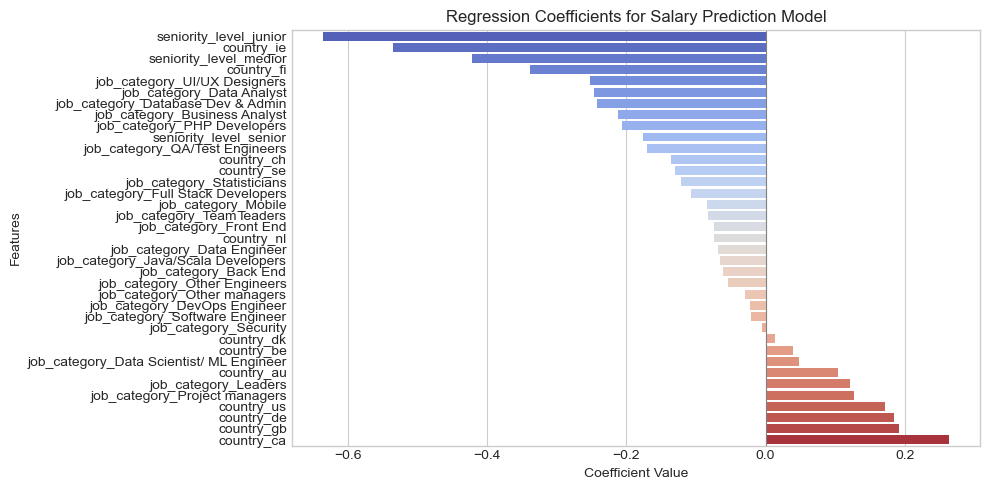

In [107]:
rmse_original_scale = calculate_rmse_original_scale(model, y_aligned)
print("RMSE on Original Scale:", rmse_original_scale)

plot_model_coefficients(model,10,5)

#### Checking Residuals: Normality

In [109]:
# Extract residuals from the fitted model
residuals = model.resid
fitted_values = model.fittedvalues

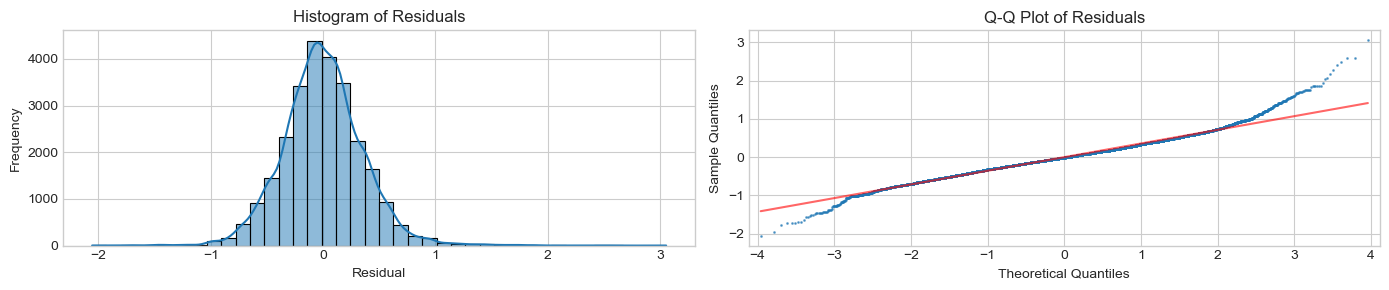

In [110]:
plot_residuals_diagnostics_normality(residuals, hist_bins=40, qq_marker_size=1, qq_alpha=0.6)

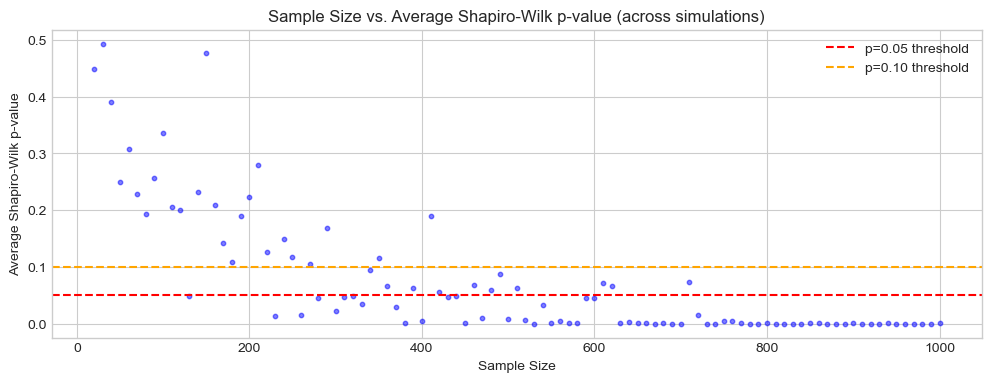

In [111]:
results_df = simulate_shapiro_test(residuals, min_sample_size=20, max_sample_size=1000, step_size=10, num_simulations=10, dot_size=10)

#### Checking Residuals: Homoscedasticity

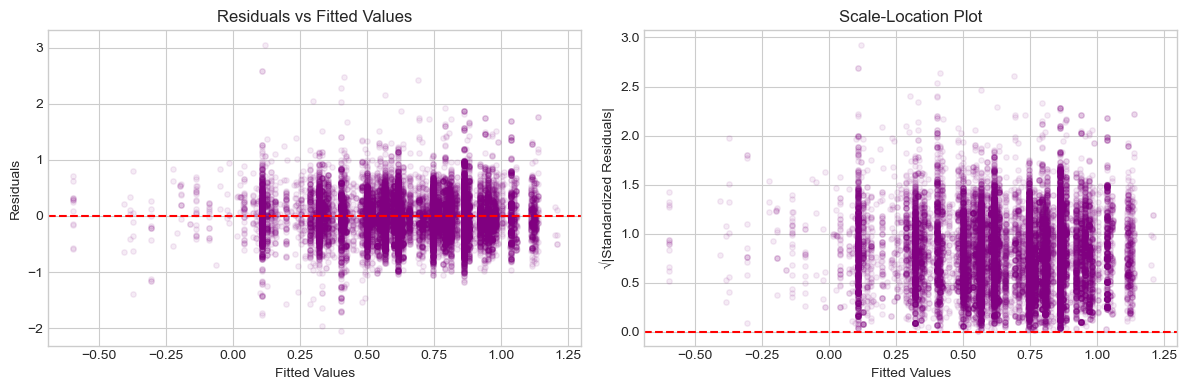

In [113]:
plot_residuals_diagnostics_homoscedasticity(fitted_values, residuals, dot_size=15, alpha=0.08)

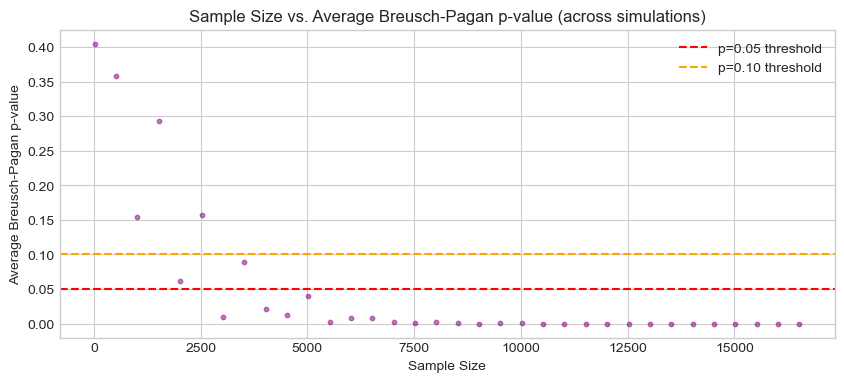

In [114]:
results_df = simulate_breusch_pagan_test(residuals, fitted_values, min_sample_size=20, max_sample_size=17000, step_size=500, num_simulations=10, dot_size=10)

### Influential points

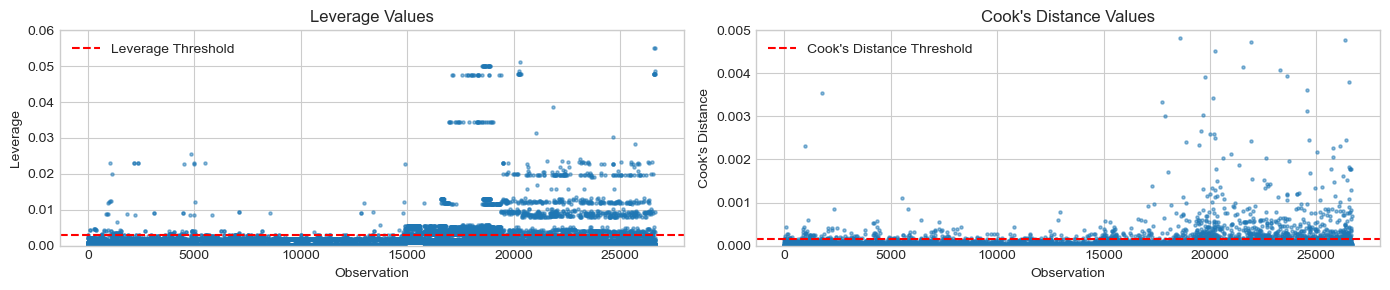

In [116]:
# Calculate leverage and Cook's Distance using the model
leverage, cooks_d = calculate_leverage_and_cooks_distance(model)

# Plot the leverage and Cook's Distance
plot_leverage_and_cooks_distance(leverage, cooks_d)

Number of high leverage points: 2921
Number of high Cook's Distance points: 1011
Number of influential points (either condition): 3370


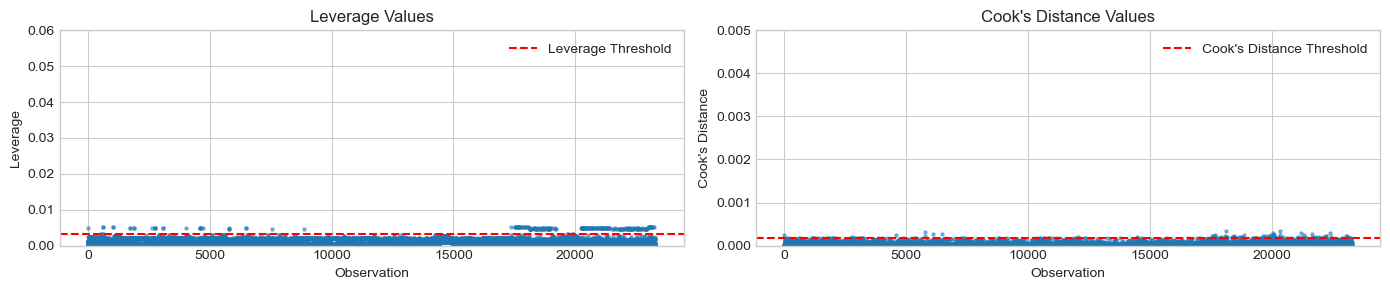

In [117]:
# Leverage OR cook's D EITHER high
# Identify observations with high leverage or high Cook's Distance
n = len(leverage)
p = model.df_model
leverage_threshold = 2 * (p + 1) / n
cooks_threshold = 4 / n

# Identify high leverage and high Cook's Distance points separately
high_leverage_points = np.where(leverage > leverage_threshold)[0]
high_cooks_points = np.where(cooks_d > cooks_threshold)[0]

# Use the union of high leverage and high Cook's Distance points
influential_points = np.union1d(high_leverage_points, high_cooks_points)

print(f"Number of high leverage points: {len(high_leverage_points)}")
print(f"Number of high Cook's Distance points: {len(high_cooks_points)}")
print(f"Number of influential points (either condition): {len(influential_points)}")

# Remove influential observations
X_encoded_cleaned = X_encoded.drop(index=influential_points).reset_index(drop=True)
y_cleaned = y_aligned.drop(index=influential_points).reset_index(drop=True)

# Refit the model without influential observations
model_cleaned = sm.OLS(y_cleaned, X_encoded_cleaned).fit()

# Recalculate leverage and Cook's Distance
leverage_cleaned, cooks_d_cleaned = calculate_leverage_and_cooks_distance(model_cleaned)

# Plot again
plot_leverage_and_cooks_distance(leverage_cleaned, cooks_d_cleaned)

In [118]:
# Ensure indices are aligned with the original DataFrame
X_encoded_with_index = X_encoded.reset_index(drop=True)
y_aligned_with_index = y_aligned.reset_index(drop=True)

# Original indices (positions after resetting index)
original_indices = X_encoded_with_index.index

# Map influential points to positions in df_combined
# Reset index of df_combined to ensure alignment
df_name_reset = df_name.reset_index(drop=True)

# Ensure that df_combined_reset has the same number of rows as X_encoded_with_index
assert len(df_name_reset) == len(X_encoded_with_index), "Mismatch in number of rows"

# Retrieve influential observations from the original DataFrame
df_name_influential = df_name_reset.iloc[influential_points]

# Remove the influential points from the original data frame, creating a new df
df_name_noninfl = df_name_reset.drop(index=influential_points).reset_index(drop=True)

# Examine influential observations
df_name_influential.head()

seniority_level  level_1  year employment_status  \
2            junior     7.00  2024                ft   
18           junior   109.00  2024                ft   
32           junior   200.00  2024                ft   
93           junior   775.00  2024                ft   
105          junior   859.00  2024                ft   

                         job_title  salary_in_currency salary_currency  \
2    business intelligence analyst           157400.00             usd   
18   business intelligence analyst           164500.00             usd   
32           business intelligence           176627.00             usd   
93   business intelligence analyst           234000.00             usd   
105                  data engineer            47820.00             eur   

       salary country  remote_ratio company_location company_size  ratio  \
2   157400.00      us        100.00               us            m   1.00   
18  164500.00      us          0.00               us            m   1.00   
32  176627.00      us          0.00               us            m   1.00   
93  234000.00      us          0.00               us            m   1.00   
105  53133.00      nl          0.00               nl            m   1.11   

    survey company_size_category country_code  median_income_2020_usd  \
2       ai                     m           us                   19306   
18      ai                     m           us                   19306   
32      ai                     m           us                   19306   
93      ai                     m           us                   19306   
105     ai                     m           nl                   17154   

     mean_income_2020_usd  gdp_ppp_usd  glassdoor_software_engineer_usd  \
2                   25332        81695                        160899.00   
18                  25332        81695                        160899.00   
32                  25332        81695                        160899.00   
93                  25332        81695                        160899.00   
105                 19690        78215                         86888.00   

     salary_normmed  salary_normmean  salary_normgdp  salary_normse  \
2              8.15             6.21            1.93           0.98   
18             8.52             6.49            2.01           1.02   
32             9.15             6.97            2.16           1.10   
93            12.12             9.24            2.86           1.45   
105            3.10             2.70            0.68           0.61   

     salary_norm  salary_2024  salary_norm_2024  salary_normmed_2024  \
2           2.06    157400.00              2.06                 8.15   
18          2.16    164500.00              2.16                 8.52   
32          2.31    176627.00              2.31                 9.15   
93          3.07    234000.00              3.07                12.12   
105         0.93     53133.00              0.93                 3.10   

     salary_normmean_2024  salary_normgdp_2024  salary_normse_2024  \
2                    6.21                 1.93                0.98   
18                   6.49                 2.01                1.02   
32                   6.97                 2.16                1.10   
93                   9.24                 2.86                1.45   
105                  2.70                 0.68                0.61   

         job_category  salary_log  salary_2024_log  salary_norm_log  \
2    Business Analyst       11.97            11.97             0.72   
18   Business Analyst       12.01            12.01             0.77   
32   Business Analyst       12.08            12.08             0.84   
93   Business Analyst       12.36            12.36             1.12   
105     Data Engineer       10.88            10.88            -0.07   

     salary_norm_2024_log  salary_normmed_2024_log  salary_normmean_2024_log  \
2                    0.72                     2.10                      1.83   
18     

In [119]:
print("Original DataFrame shape:", df_name_reset.shape)
print("Number of influential points:", len(influential_points))
print("DataFrame without influential points shape:", df_name_noninfl.shape)

Original DataFrame shape: (26655, 63)
Number of influential points: 3370
DataFrame without influential points shape: (23285, 63)


#### Comparing VIFs

In [121]:
# Define the formula for the model
formula = 'salary_log ~ ' + ' + '.join(['C(' + var + ')' for var in categorical_vars])

# Get design matrices for VIF calculation
y, X = dmatrices(formula, data=df_name, return_type='dataframe')

# Calculate VIF for each feature
vif = pd.DataFrame()
vif["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
vif["Feature"] = X.columns

vif.sort_values(by='VIF', ascending=False).head(50)

VIF                                         Feature
0  665.70                                       Intercept
37 133.31                                C(country)[T.us]
30  96.71                                C(country)[T.de]
33  30.92                                C(country)[T.gb]
28  20.42                                C(country)[T.ca]
5   11.52  C(job_category)[T.Data Scientist/ ML Engineer]
26  10.20                                C(country)[T.au]
3    7.06                 C(job_category)[T.Data Analyst]
35   6.92                                C(country)[T.nl]
4    6.50                C(job_category)[T.Data Engineer]
19   4.37            C(job_category)[T.Software Engineer]
29   3.67                                C(country)[T.ch]
25   3.65                    C(seniority_level)[T.senior]
34   3.54                                C(country)[T.ie]
24   3.15                    C(seniority_level)[T.medior]
36   2.95                                C(country)[T.se]
27   2.88                                C(country)[T.be]
16   2.42             C(job_category)[T.Project managers]
1    2.23                     C(job_category)[T.Back End]
23   2.18                    C(seniority_level)[T.junior]
31   2.16                                C(country)[T.dk]
14   1.95               C(job_category)[T.Other managers]
2    1.92             C(job_category)[T.Business Analyst]
11   1.67                      C(job_category)[T.Leaders]
8    1.63                    C(job_category)[T.Front End]
17   1.53            C(job_category)[T.QA/Test Engineers]
7    1.45              C(job_category)[T.DevOps Engineer]
21   1.42                 C(job_category)[T.Team leaders]
12   1.37                       C(job_category)[T.Mobile]
20   1.22                C(job_category)[T.Statisticians]
9    1.17        C(job_category)[T.Full Stack Developers]
10   1.15        C(job_category)[T.Java/Scala Developers]
32   1.11                                C(country)[T.fi]
6    1.09         C(job_category)[T.Database Dev & Admin]
22   1.06              C(job_category)[T.UI/UX Designers]
13   1.05              C(job_category)[T.Other Engineers]
18   1.04                     C(job_category)[T.Security]
15   1.04               C(job_category)[T.PHP Developers]

In [122]:
# Define the dataframe to be used
df_name = df_name_noninfl

# Define the formula for the model
formula = 'salary_log ~ ' + ' + '.join(['C(' + var + ')' for var in categorical_vars])

# Get design matrices for VIF calculation
y, X = dmatrices(formula, data=df_name, return_type='dataframe')

# Calculate VIF for each feature
vif = pd.DataFrame()
vif["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
vif["Feature"] = X.columns

vif.sort_values(by='VIF', ascending=False).head(50)

VIF                                         Feature
0  166.10                                       Intercept
15  20.47                                C(country)[T.us]
13  15.38                                C(country)[T.de]
5   11.02  C(job_category)[T.Data Scientist/ ML Engineer]
3    7.17                 C(job_category)[T.Data Analyst]
4    6.66                C(job_category)[T.Data Engineer]
14   6.57                                C(country)[T.gb]
12   4.51                                C(country)[T.ca]
8    4.30            C(job_category)[T.Software Engineer]
11   3.97                    C(seniority_level)[T.senior]
10   3.42                    C(seniority_level)[T.medior]
1    2.31                     C(job_category)[T.Back End]
9    2.29                    C(seniority_level)[T.junior]
7    2.22             C(job_category)[T.Project managers]
6    1.92               C(job_category)[T.Other managers]
2    1.89             C(job_category)[T.Business Analyst]

### Refitting w/o influential points

In [124]:
# Your prepared DataFrame
X = df_name_noninfl[categorical_vars]
y = df_name_noninfl['salary_log']

# Train the model
model, encoded_features, X_encoded, y_aligned = train_model_1617(X, y)

# View the summary
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:             salary_log   R-squared:                       0.444
Model:                            OLS   Adj. R-squared:                  0.443
Method:                 Least Squares   F-statistic:                     1237.
Date:                Mon, 16 Dec 2024   Prob (F-statistic):               0.00
Time:                        21:42:11   Log-Likelihood:                -8004.6
No. Observations:               23285   AIC:                         1.604e+04
Df Residuals:                   23269   BIC:                         1.617e+04
Df Model:                          15                                         
Covariance Type:            nonrobust                                         
                                               coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------

RMSE on Original Scale: 54169.48639308397


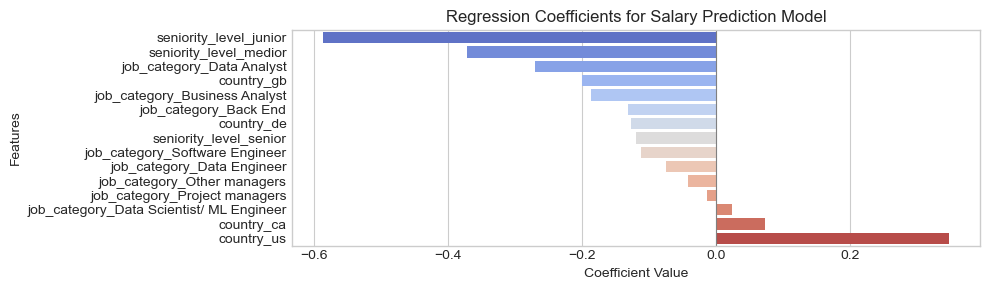

In [125]:
rmse_original_scale = calculate_rmse_original_scale(model, y_aligned)
print("RMSE on Original Scale:", rmse_original_scale)

plot_model_coefficients(model,10,3)

#### Checking Residuals: Normality

In [127]:
# Extract residuals from the fitted model
residuals = model.resid
fitted_values = model.fittedvalues

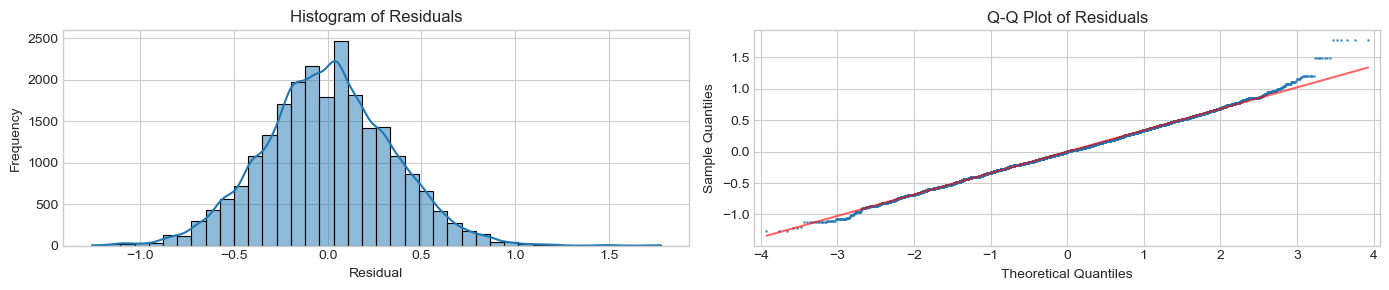

In [128]:
plot_residuals_diagnostics_normality(residuals, hist_bins=40, qq_marker_size=1, qq_alpha=0.6)

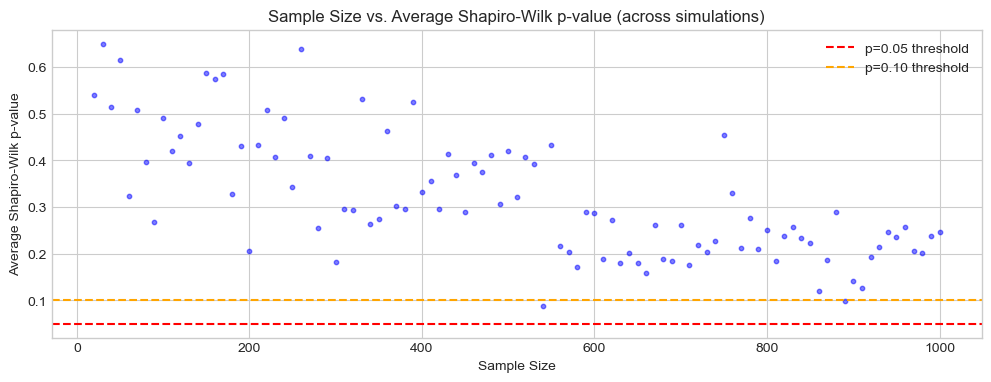

In [129]:
results_df = simulate_shapiro_test(residuals, min_sample_size=20, max_sample_size=1000, step_size=10, num_simulations=10, dot_size=10)

#### Checking Residuals: Homoscedasticity

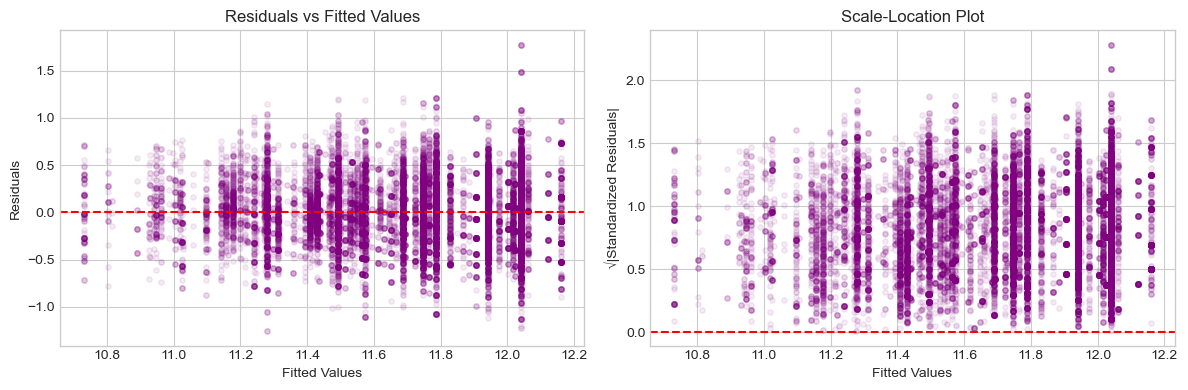

In [131]:
plot_residuals_diagnostics_homoscedasticity(fitted_values, residuals, dot_size=15, alpha=0.08)

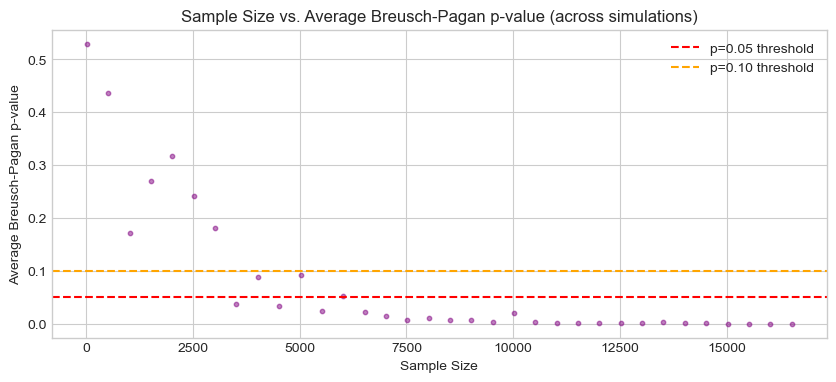

In [132]:
results_df = simulate_breusch_pagan_test(residuals, fitted_values, min_sample_size=20, max_sample_size=17000, step_size=500, num_simulations=10, dot_size=10)

### Making a prediction

In [134]:
specific_case = {
    'job_category': 'Data Scientist/ ML Engineer',
    'seniority_level': 'senior',
    'country': 'us'
}

In [135]:
# Predict salary for the specific case
predicted_salary, predicted_salary_p25, predicted_salary_p75 = predict_salary_for_case_log_perc(model, encoded_features, specific_case)

print(f"Predicted Median Salary: {predicted_salary:.2f}")
print(f"Predicted 25th Percentile Salary: {predicted_salary_p25:.2f}")
print(f"Predicted 75th Percentile Salary: {predicted_salary_p75:.2f}")

Predicted Median Salary: 169367.41
Predicted 25th Percentile Salary: 134535.63
Predicted 75th Percentile Salary: 213217.28


#### Plotting the prediction

In [137]:
specific_case = {
    'job_category': 'Data Scientist/ ML Engineer',
    'seniority_level': 'senior',
    'country': 'us'
}

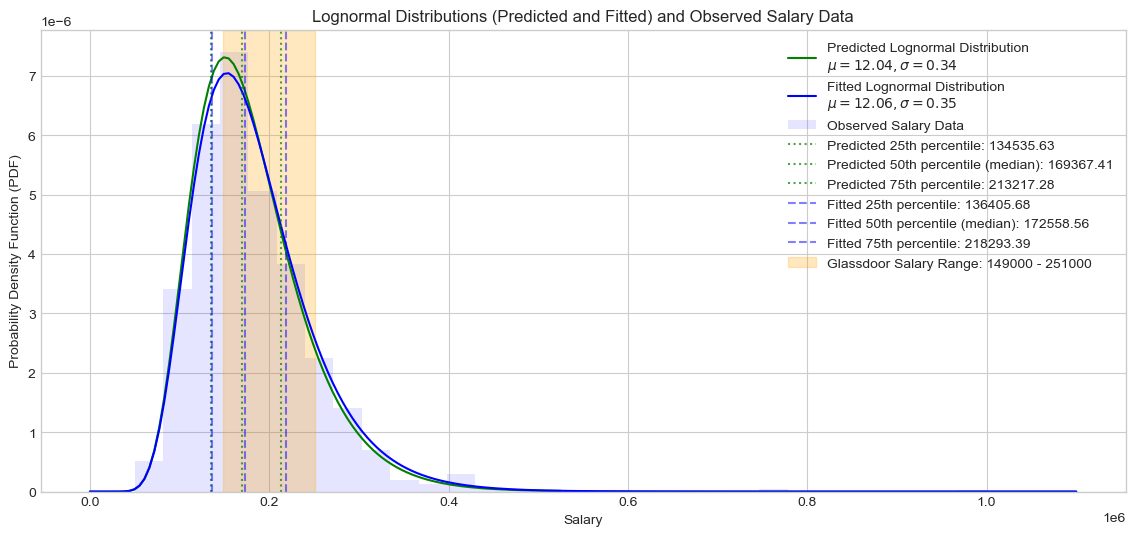

In [138]:
plot_salary_distributions(df_name, model, encoded_features, specific_case, glassdoor_data)

### The result

In [140]:
# Define your specific cases in the desired order
specific_cases = [
    {'job_category': 'Data Analyst', 'seniority_level': 'junior', 'country': 'de'},
    {'job_category': 'Data Analyst', 'seniority_level': 'medior', 'country': 'de'},
    {'job_category': 'Data Analyst', 'seniority_level': 'senior', 'country': 'de'},
    {'job_category': 'Data Engineer', 'seniority_level': 'junior', 'country': 'de'},
    {'job_category': 'Data Engineer', 'seniority_level': 'medior', 'country': 'de'},
    {'job_category': 'Data Engineer', 'seniority_level': 'senior', 'country': 'de'},
    {'job_category': 'Data Scientist/ ML Engineer', 'seniority_level': 'junior', 'country': 'de'},
    {'job_category': 'Data Scientist/ ML Engineer', 'seniority_level': 'medior', 'country': 'de'},
    {'job_category': 'Data Scientist/ ML Engineer', 'seniority_level': 'senior', 'country': 'de'},
]

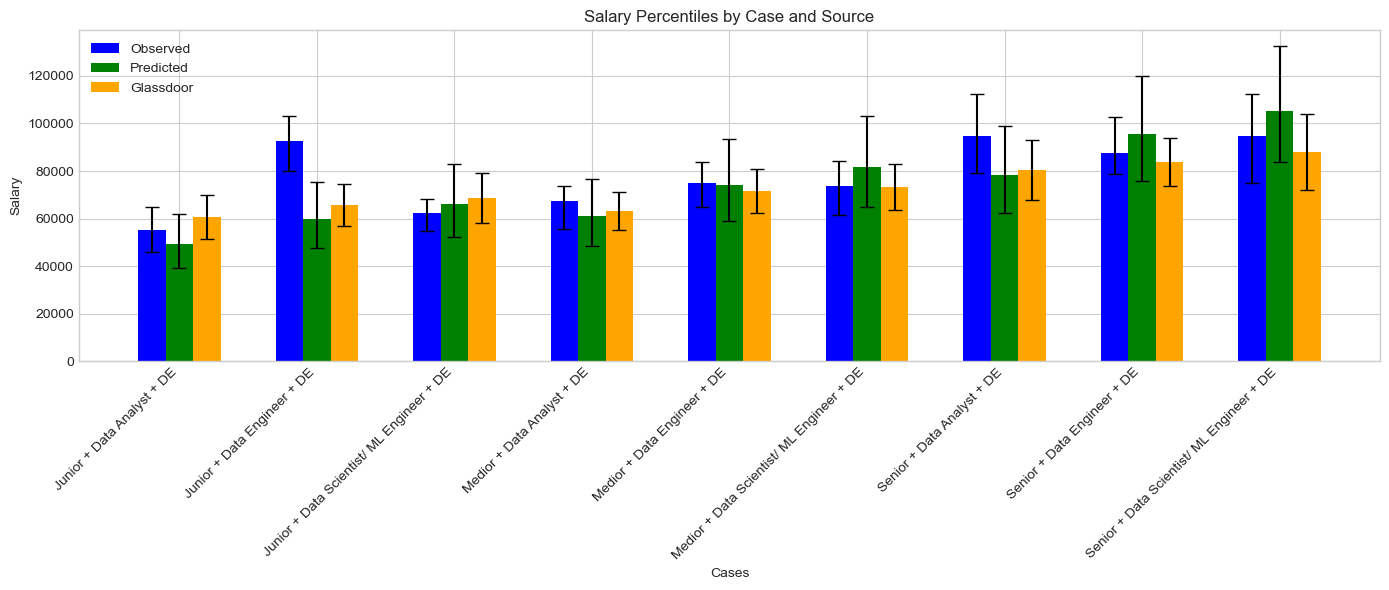

In [141]:
plot_salary_percentiles_by_case(df_name, model, encoded_features, specific_cases, glassdoor_data)

In [142]:
def plot_salary_percentiles_by_case_2(df_name, model, encoded_features, specific_cases, glassdoor_data):
    """
    Plots salary percentiles (P25, P50, P75) for different cases and data sources (Observed, Predicted, Glassdoor).
    
    Parameters:
        df_name (pd.DataFrame): DataFrame containing observed salary data.
        model: Model for predicting salary.
        encoded_features: Encoded features for prediction.
        specific_cases (list of dict): List of specific cases to analyze, with keys 'job_category', 'seniority_level', and 'country'.
        glassdoor_data (pd.DataFrame): DataFrame with Glassdoor salary range data.
    
    Returns:
        None
    """
    # Initialize lists to store data
    case_labels = []
    observed_percentiles = []
    predicted_percentiles = []
    glassdoor_percentiles = []

    for specific_case in specific_cases:
        job_category = specific_case['job_category']
        seniority_level = specific_case['seniority_level']
        country = specific_case['country']

        # --- Observed Data ---
        salary_data = df_name['salary'][
            (df_name['seniority_level'] == seniority_level) &
            (df_name['job_category'] == job_category) &
            (df_name['country'] == country)
        ]

        if len(salary_data) > 0:
            P25_obs = np.percentile(salary_data, 25)
            P50_obs = np.percentile(salary_data, 50)
            P75_obs = np.percentile(salary_data, 75)
        else:
            P25_obs = P50_obs = P75_obs = np.nan

        observed_percentiles.append([P25_obs, P50_obs, P75_obs])

        # --- Predicted Data ---
        predicted_salary, predicted_salary_p25, predicted_salary_p75 = predict_salary_for_case_log_perc(
            model, encoded_features, specific_case
        )

        P25_pred, P50_pred, P75_pred = predicted_salary_p25, predicted_salary, predicted_salary_p75
        predicted_percentiles.append([P25_pred, P50_pred, P75_pred])

        # --- Glassdoor Data ---
        glassdoor_row = glassdoor_data[
            (glassdoor_data['job_category'] == job_category) &
            (glassdoor_data['seniority_level'] == seniority_level) &
            (glassdoor_data['country'] == country)
        ]

        if not glassdoor_row.empty:
            glassdoor_lower = glassdoor_row['glassdoor_lower'].values[0]
            glassdoor_upper = glassdoor_row['glassdoor_upper'].values[0]
            glassdoor_median = (glassdoor_lower + glassdoor_upper) / 2
            P25_glassdoor, P50_glassdoor, P75_glassdoor = glassdoor_lower, glassdoor_median, glassdoor_upper
        else:
            P25_glassdoor = P50_glassdoor = P75_glassdoor = np.nan

        glassdoor_percentiles.append([P25_glassdoor, P50_glassdoor, P75_glassdoor])

        # Add case label
        case_label = f"{seniority_level.capitalize()} + {job_category} + {country.upper()}"
        case_labels.append(case_label)

    # Create DataFrame for plotting
    data_list = []
    for idx, case_label in enumerate(case_labels):
        data_list.append({'Case': case_label, 'Source': 'Observed', 'P25': observed_percentiles[idx][0], 'P50': observed_percentiles[idx][1], 'P75': observed_percentiles[idx][2]})
        data_list.append({'Case': case_label, 'Source': 'Predicted', 'P25': predicted_percentiles[idx][0], 'P50': predicted_percentiles[idx][1], 'P75': predicted_percentiles[idx][2]})
        data_list.append({'Case': case_label, 'Source': 'Glassdoor', 'P25': glassdoor_percentiles[idx][0], 'P50': glassdoor_percentiles[idx][1], 'P75': glassdoor_percentiles[idx][2]})
    
    df_plot = pd.DataFrame(data_list)
    df_plot.sort_values(['Case', 'Source'], inplace=True)

    # Plotting
    cases = df_plot['Case'].unique()
    sources = ['Observed', 'Predicted', 'Glassdoor']
    n_cases = len(cases)
    n_sources = len(sources)
    bar_width = 0.2
    x = np.arange(n_cases)
    offsets = np.linspace(-bar_width * (n_sources - 1) / 2, bar_width * (n_sources - 1) / 2, n_sources)
    source_colors = {'Observed': 'blue', 'Predicted': 'green', 'Glassdoor': 'orange'}

    fig, ax = plt.subplots(figsize=(6, 5.5))
    plotted_labels = set()

    for i, source in enumerate(sources):
        bar_positions = x + offsets[i]
        medians, lower_errors, upper_errors = [], [], []
        
        for case in cases:
            source_data = df_plot[(df_plot['Case'] == case) & (df_plot['Source'] == source)]
            if not source_data.empty:
                median = source_data['P50'].values[0]
                P25 = source_data['P25'].values[0]
                P75 = source_data['P75'].values[0]
                lower_error = median - P25
                upper_error = P75 - median
            else:
                median = np.nan
                lower_error = upper_error = np.nan
            medians.append(median)
            lower_errors.append(lower_error)
            upper_errors.append(upper_error)
        
        # Convert to numpy arrays and plot
        medians, lower_errors, upper_errors = np.array(medians), np.array(lower_errors), np.array(upper_errors)
        valid = ~np.isnan(medians)
        
        if valid.any():
            if source not in plotted_labels:
                ax.bar(bar_positions[valid], medians[valid], width=bar_width, label=source,
                       color=source_colors.get(source), yerr=[lower_errors[valid], upper_errors[valid]], capsize=5)
                plotted_labels.add(source)
            else:
                ax.bar(bar_positions[valid], medians[valid], width=bar_width,
                       color=source_colors.get(source), yerr=[lower_errors[valid], upper_errors[valid]], capsize=5)

    ax.set_xticks(x)
    ax.set_xticklabels(cases, rotation=45, ha='right')
    ax.set_xlabel('Cases')
    ax.set_ylabel('Salary')
    ax.set_title('Salary Percentiles by Case and Source')
    ax.legend()
    plt.tight_layout()
    plt.show()

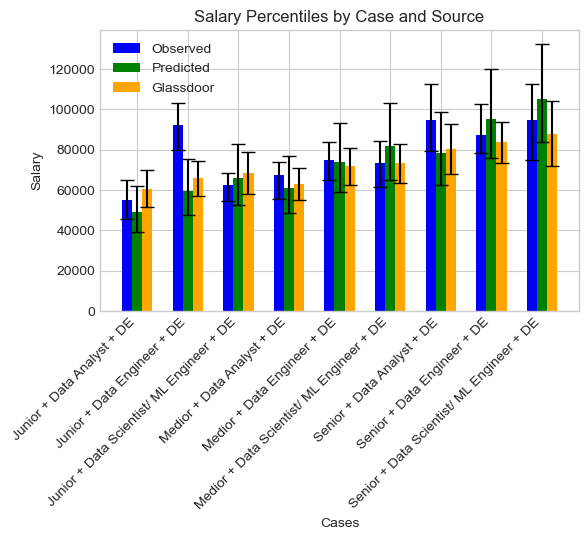

In [143]:
plot_salary_percentiles_by_case_2(df_name, model, encoded_features, specific_cases, glassdoor_data)

In [144]:
# Define your specific cases in the desired order
specific_cases = [
    {'job_category': 'Data Analyst', 'seniority_level': 'junior', 'country': 'us'},
    {'job_category': 'Data Analyst', 'seniority_level': 'medior', 'country': 'us'},
    {'job_category': 'Data Analyst', 'seniority_level': 'senior', 'country': 'us'},
    {'job_category': 'Data Engineer', 'seniority_level': 'junior', 'country': 'us'},
    {'job_category': 'Data Engineer', 'seniority_level': 'medior', 'country': 'us'},
    {'job_category': 'Data Engineer', 'seniority_level': 'senior', 'country': 'us'},
    {'job_category': 'Data Scientist/ ML Engineer', 'seniority_level': 'junior', 'country': 'us'},
    {'job_category': 'Data Scientist/ ML Engineer', 'seniority_level': 'medior', 'country': 'us'},
    {'job_category': 'Data Scientist/ ML Engineer', 'seniority_level': 'senior', 'country': 'us'},
]

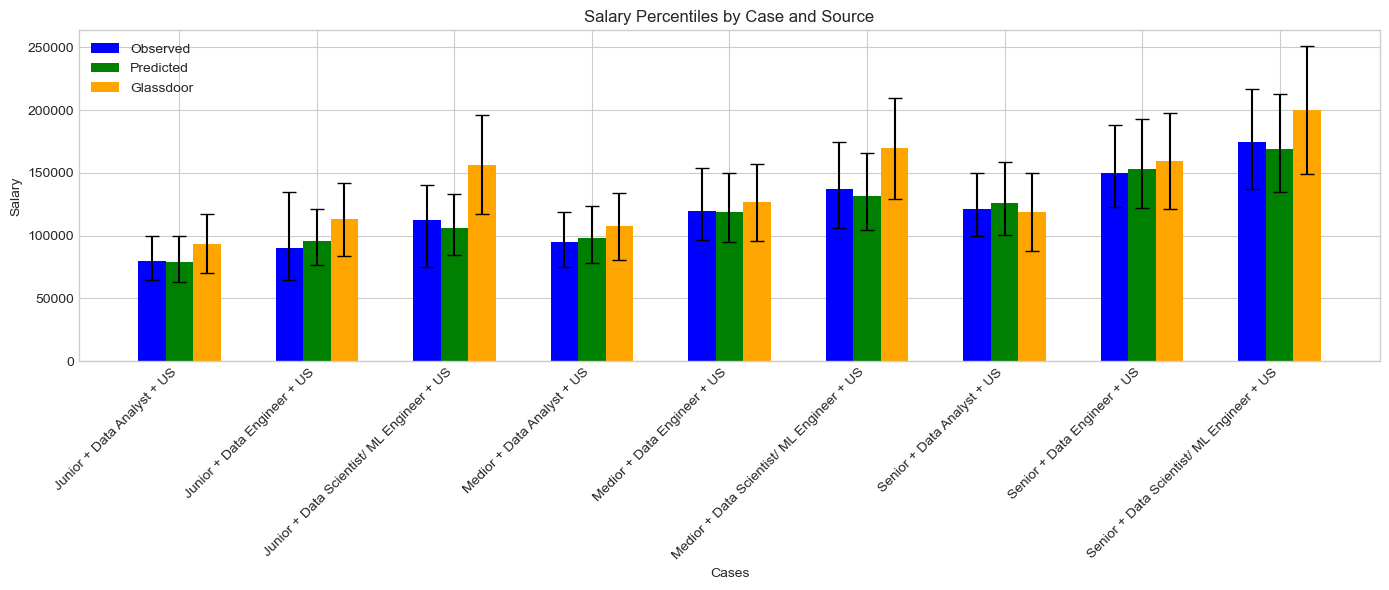

In [145]:
plot_salary_percentiles_by_case(df_name, model, encoded_features, specific_cases, glassdoor_data)

## DF-AI

### Initial fitting

In [148]:
df_name = df_ai_w_l
categorical_vars = ['job_category','seniority_level','country']

In [149]:
# Your prepared DataFrame
X = df_name[categorical_vars]
y = df_name['salary_log']

# Train the model
model, encoded_features, X_encoded, y_aligned = train_model_1617(X, y)

# View the summary
print(model.summary())

# Print encoded feature categories (useful for future predictions)
print("\nEncoded feature categories:")
for feature, categories in encoded_features.items():
    print(f"{feature}: {categories}")

                            OLS Regression Results                            
Dep. Variable:             salary_log   R-squared:                       0.351
Model:                            OLS   Adj. R-squared:                  0.350
Method:                 Least Squares   F-statistic:                     364.7
Date:                Mon, 16 Dec 2024   Prob (F-statistic):               0.00
Time:                        21:42:17   Log-Likelihood:                -5171.8
No. Observations:               14883   AIC:                         1.039e+04
Df Residuals:                   14860   BIC:                         1.056e+04
Df Model:                          22                                         
Covariance Type:            nonrobust                                         
                                               coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------

RMSE on Original Scale: 53773.94036886673


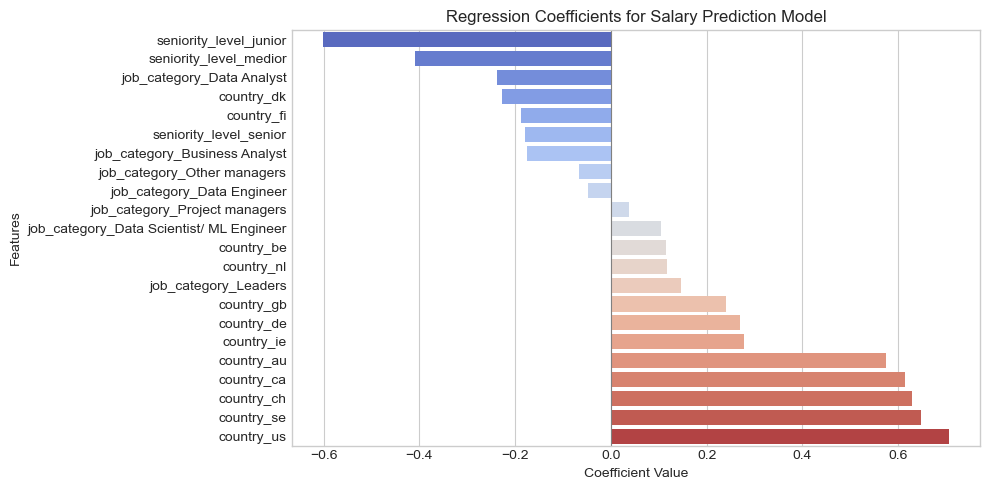

In [150]:
rmse_original_scale = calculate_rmse_original_scale(model, y_aligned)
print("RMSE on Original Scale:", rmse_original_scale)

plot_model_coefficients(model,10,5)

#### Checking Residuals: Normality

In [152]:
# Extract residuals from the fitted model
residuals = model.resid
fitted_values = model.fittedvalues

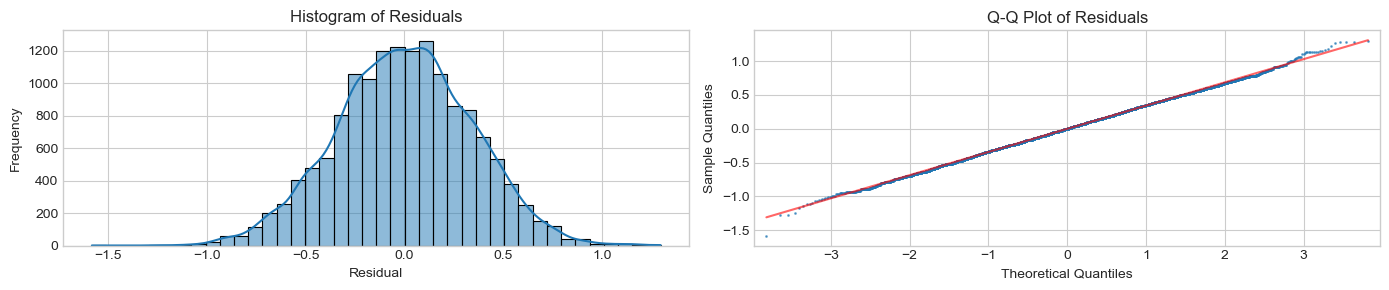

In [153]:
plot_residuals_diagnostics_normality(residuals, hist_bins=40, qq_marker_size=1, qq_alpha=0.6)

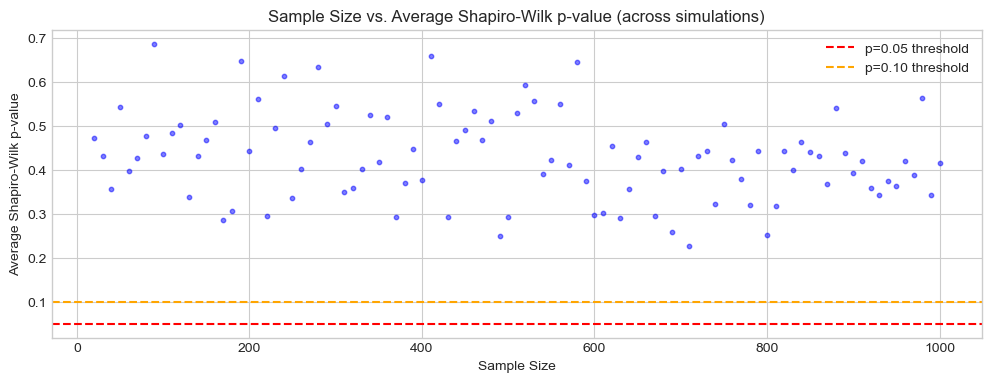

In [154]:
results_df = simulate_shapiro_test(residuals, min_sample_size=20, max_sample_size=1000, step_size=10, num_simulations=10, dot_size=10)

#### Checking Residuals: Homoscedasticity

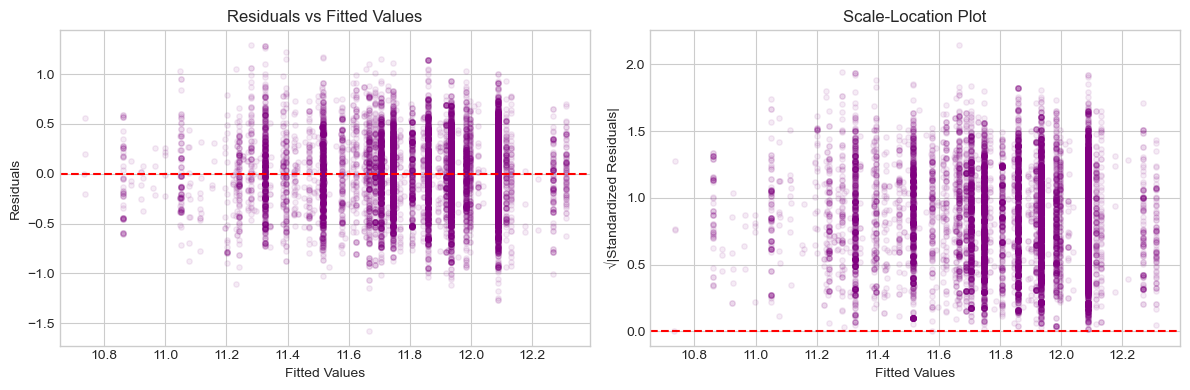

In [156]:
plot_residuals_diagnostics_homoscedasticity(fitted_values, residuals, dot_size=15, alpha=0.08)

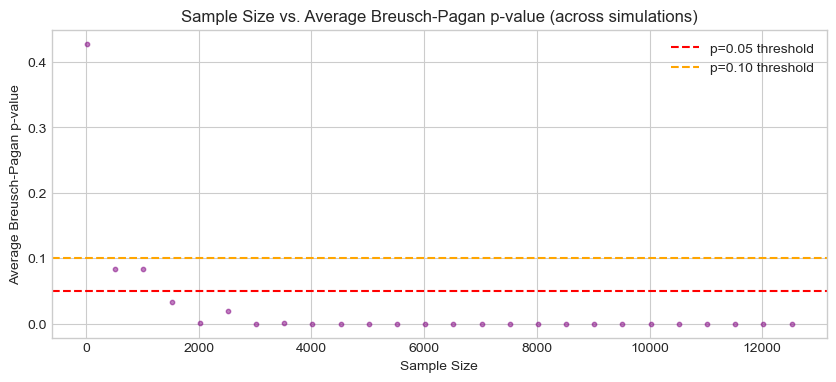

In [157]:
results_df = simulate_breusch_pagan_test(residuals, fitted_values, min_sample_size=20, max_sample_size=13000, step_size=500, num_simulations=10, dot_size=10)

### Influential points

C:\ProgramData\anaconda3\Lib\site-packages\statsmodels\stats\outliers_influence.py:847: RuntimeWarning: invalid value encountered in sqrt
  return self.resid / sigma / np.sqrt(1 - hii)


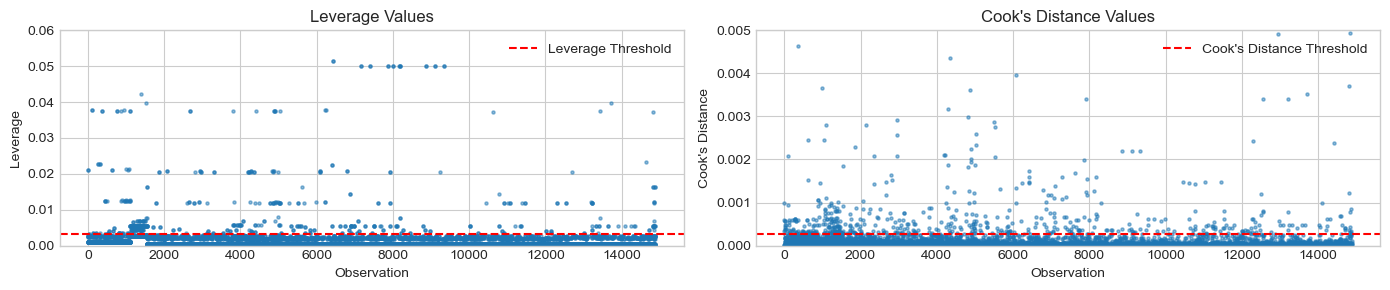

In [159]:
# Calculate leverage and Cook's Distance using the model
leverage, cooks_d = calculate_leverage_and_cooks_distance(model)

# Plot the leverage and Cook's Distance
plot_leverage_and_cooks_distance(leverage, cooks_d)

Note: The "invalid value encountered in sqrt" warning arises due to high-leverage points 
with leverage values close to 1, which lead to near-zero denominators in the Cook's Distance 
calculation. This can indicate influential points, which we consider informative in understanding 
the data distribution and model influence.

Number of high leverage points: 596
Number of high Cook's Distance points: 580
Number of influential points (either condition): 936


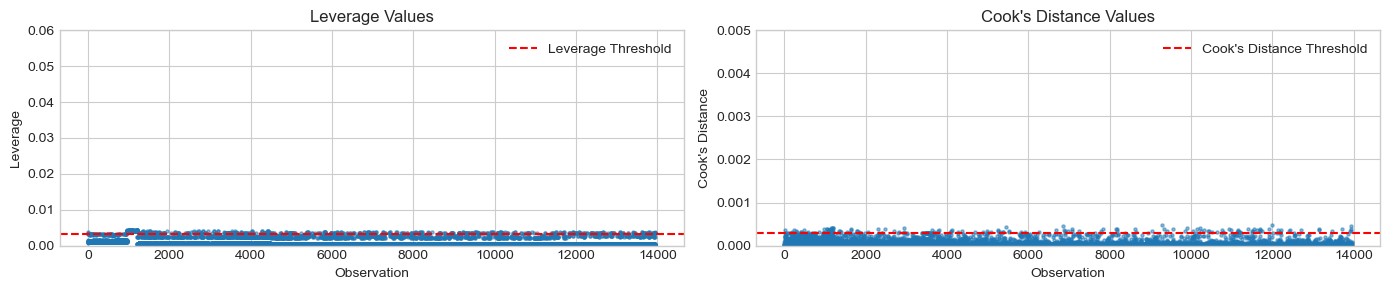

In [161]:
# Leverage OR cook's D EITHER high
# Identify observations with high leverage or high Cook's Distance
n = len(leverage)
p = model.df_model
leverage_threshold = 2 * (p + 1) / n
cooks_threshold = 4 / n

# Identify high leverage and high Cook's Distance points separately
high_leverage_points = np.where(leverage > leverage_threshold)[0]
high_cooks_points = np.where(cooks_d > cooks_threshold)[0]

# Use the union of high leverage and high Cook's Distance points
influential_points = np.union1d(high_leverage_points, high_cooks_points)

print(f"Number of high leverage points: {len(high_leverage_points)}")
print(f"Number of high Cook's Distance points: {len(high_cooks_points)}")
print(f"Number of influential points (either condition): {len(influential_points)}")

# Remove influential observations
X_encoded_cleaned = X_encoded.drop(index=influential_points).reset_index(drop=True)
y_cleaned = y_aligned.drop(index=influential_points).reset_index(drop=True)

# Refit the model without influential observations
model_cleaned = sm.OLS(y_cleaned, X_encoded_cleaned).fit()

# Recalculate leverage and Cook's Distance
leverage_cleaned, cooks_d_cleaned = calculate_leverage_and_cooks_distance(model_cleaned)

# Plot again
plot_leverage_and_cooks_distance(leverage_cleaned, cooks_d_cleaned)

In [162]:
# Ensure indices are aligned with the original DataFrame
X_encoded_with_index = X_encoded.reset_index(drop=True)
y_aligned_with_index = y_aligned.reset_index(drop=True)

# Original indices (positions after resetting index)
original_indices = X_encoded_with_index.index

# Map influential points to positions in df_combined
# Reset index of df_combined to ensure alignment
df_name_reset = df_name.reset_index(drop=True)

# Ensure that df_combined_reset has the same number of rows as X_encoded_with_index
assert len(df_name_reset) == len(X_encoded_with_index), "Mismatch in number of rows"

# Retrieve influential observations from the original DataFrame
df_name_influential = df_name_reset.iloc[influential_points]

# Remove the influential points from the original data frame, creating a new df
df_name_noninfl = df_name_reset.drop(index=influential_points).reset_index(drop=True)

# Examine influential observations
df_name_influential.head()

seniority_level  level_1  year employment_status  \
0           junior        5  2024                ft   
1           junior        6  2024                ft   
2           junior        7  2024                ft   
11          junior       88  2024                ft   
16          junior      105  2024                ft   

                        job_title  salary_in_currency salary_currency  salary  \
0                    data analyst              102927             usd  102927   
1                    data analyst               95010             usd   95010   
2   business intelligence analyst              157400             usd  157400   
11                 data scientist               30000             gbp   37500   
16                 data scientist               26800             gbp   33500   

   country  remote_ratio company_location company_size  ratio survey  \
0       au             0               au            m   1.00     ai   
1       au             0               au            m   1.00     ai   
2       us           100               us            m   1.00     ai   
11      gb             0               gb            m   1.25     ai   
16      gb             0               gb            m   1.25     ai   

   company_size_category country_code  median_income_2020_usd  \
0                      m           au                   17076   
1                      m           au                   17076   
2                      m           us                   19306   
11                     m           gb                   14793   
16                     m           gb                   14793   

    mean_income_2020_usd  gdp_ppp_usd  glassdoor_software_engineer_usd  \
0                  21329        69115                         81659.00   
1                  21329        69115                         81659.00   
2                  25332        81695                        160899.00   
11                 18133        58906                         69594.00   
16                 18133        58906                         69594.00   

    salary_normmed  salary_normmean  salary_normgdp  salary_normse  \
0             6.03             4.83            1.49           1.26   
1             5.56             4.45            1.37           1.16   
2             8.15             6.21            1.93           0.98   
11            2.53             2.07            0.64           0.54   
16            2.26             1.85            0.57           0.48   

    salary_norm  salary_2024  salary_norm_2024  salary_normmed_2024  \
0          1.58    102927.00              1.58                 6.03   
1          1.46     95010.00              1.46                 5.56   
2          2.06    157400.00              2.06                 8.15   
11         0.81     37500.00              0.81                 2.53   
16         0.73     33500.00              0.73                 2.26   

    salary_normmean_2024  salary_normgdp_2024  salary_normse_2024  \
0                   4.83                 1.49                1.26   
1                   4.45                 1.37                1.16   
2                   6.21                 1.93                0.98   
11                  2.07                 0.64                0.54   
16                  1.85                 0.57                0.48   

                   job_category  salary_log  salary_2024_log  salary_norm_log  \
0                  Data Analyst       11.54            11.54             0.46   
1                  Data Analyst       11.46            11.46             0.38   
2              Business Analyst       11.97            11.97             0.72   
11  Data Scientist/ ML Engineer       10.53            10.53            -0.21   
16  Data Scientist/ ML Engineer       10.42            10.42            -0.32   

    salary_norm_2024_log  salary_normmed_2024_log  salary_normmean_2024_log  \
0                   0.46                     1.80                      1.57   
1       

In [163]:
print("Original DataFrame shape:", df_name_reset.shape)
print("Number of influential points:", len(influential_points))
print("DataFrame without influential points shape:", df_name_noninfl.shape)

Original DataFrame shape: (14883, 43)
Number of influential points: 936
DataFrame without influential points shape: (13947, 43)


#### Comparing VIFs

In [165]:
# Define the formula for the model
formula = 'salary_log ~ ' + ' + '.join(['C(' + var + ')' for var in categorical_vars])

# Get design matrices for VIF calculation
y, X = dmatrices(formula, data=df_name, return_type='dataframe')

# Calculate VIF for each feature
vif = pd.DataFrame()
vif["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
vif["Feature"] = X.columns

vif.sort_values(by='VIF', ascending=False).head(50)

VIF                                         Feature
0  1432.94                                       Intercept
22  106.68                                C(country)[T.us]
18   57.95                                C(country)[T.gb]
13   38.16                                C(country)[T.ca]
10    9.00                    C(seniority_level)[T.senior]
15    8.78                                C(country)[T.de]
4     8.32  C(job_category)[T.Data Scientist/ ML Engineer]
9     7.74                    C(seniority_level)[T.medior]
3     6.38                C(job_category)[T.Data Engineer]
2     6.12                 C(job_category)[T.Data Analyst]
11    5.44                                C(country)[T.au]
8     3.72                    C(seniority_level)[T.junior]
20    3.45                                C(country)[T.nl]
1     2.12             C(job_category)[T.Business Analyst]
19    2.09                                C(country)[T.ie]
6     1.79               C(job_category)[T.Other managers]
14    1.73                                C(country)[T.ch]
5     1.57                      C(job_category)[T.Leaders]
17    1.46                                C(country)[T.fi]
12    1.36                                C(country)[T.be]
21    1.18                                C(country)[T.se]
16    1.09                                C(country)[T.dk]
7     1.04             C(job_category)[T.Project managers]

In [166]:
# Define the dataframe to be used
df_name = df_name_noninfl

# Define the formula for the model
formula = 'salary_log ~ ' + ' + '.join(['C(' + var + ')' for var in categorical_vars])

# Get design matrices for VIF calculation
y, X = dmatrices(formula, data=df_name, return_type='dataframe')

# Calculate VIF for each feature
vif = pd.DataFrame()
vif["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
vif["Feature"] = X.columns

vif.sort_values(by='VIF', ascending=False).head(50)

VIF                                         Feature
0  146.00                                       Intercept
8   12.46                    C(seniority_level)[T.senior]
7   10.78                    C(seniority_level)[T.medior]
4    9.39  C(job_category)[T.Data Scientist/ ML Engineer]
3    7.28                C(job_category)[T.Data Engineer]
2    6.96                 C(job_category)[T.Data Analyst]
6    4.60                    C(seniority_level)[T.junior]
9    2.68                                C(country)[T.gb]
10   2.65                                C(country)[T.us]
1    2.13             C(job_category)[T.Business Analyst]
5    1.76               C(job_category)[T.Other managers]

### Refitting w/o influential points

In [168]:
# Your prepared DataFrame
X = df_name_noninfl[categorical_vars]
y = df_name_noninfl['salary_log']

# Train the model
model, encoded_features, X_encoded, y_aligned = train_model_1617(X, y)

# View the summary
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:             salary_log   R-squared:                       0.352
Model:                            OLS   Adj. R-squared:                  0.351
Method:                 Least Squares   F-statistic:                     755.4
Date:                Mon, 16 Dec 2024   Prob (F-statistic):               0.00
Time:                        21:42:22   Log-Likelihood:                -4134.2
No. Observations:               13947   AIC:                             8290.
Df Residuals:                   13936   BIC:                             8373.
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
                                               coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------

RMSE on Original Scale: 51446.312660588315


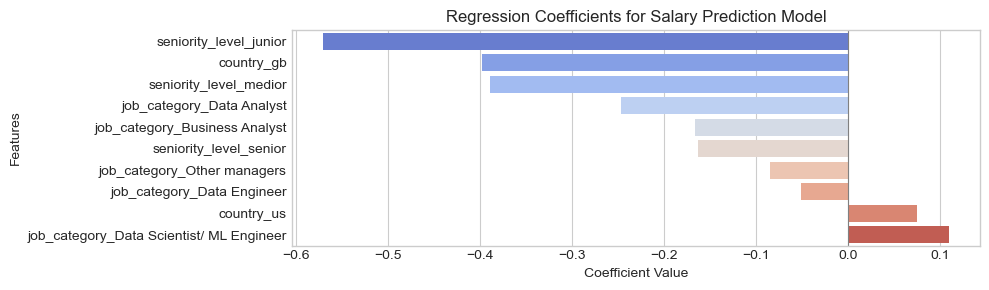

In [169]:
rmse_original_scale = calculate_rmse_original_scale(model, y_aligned)
print("RMSE on Original Scale:", rmse_original_scale)

plot_model_coefficients(model,10,3)

#### Checking Residuals: Normality

In [171]:
# Extract residuals from the fitted model
residuals = model.resid
fitted_values = model.fittedvalues

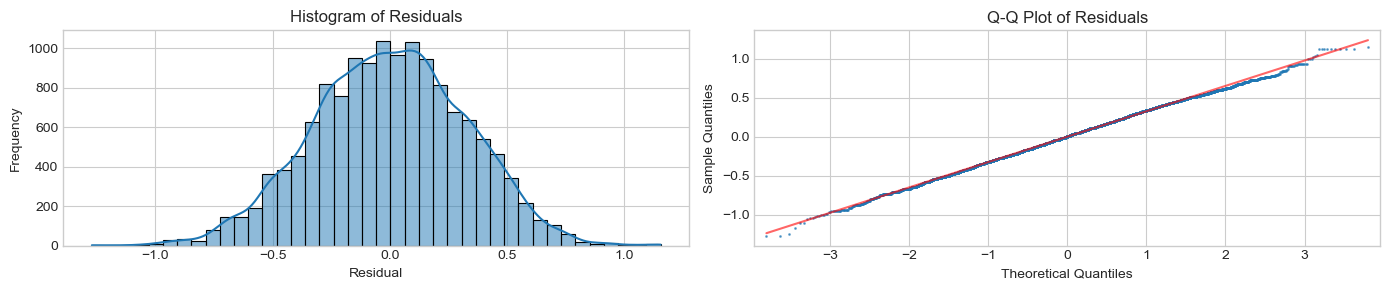

In [172]:
plot_residuals_diagnostics_normality(residuals, hist_bins=40, qq_marker_size=1, qq_alpha=0.6)

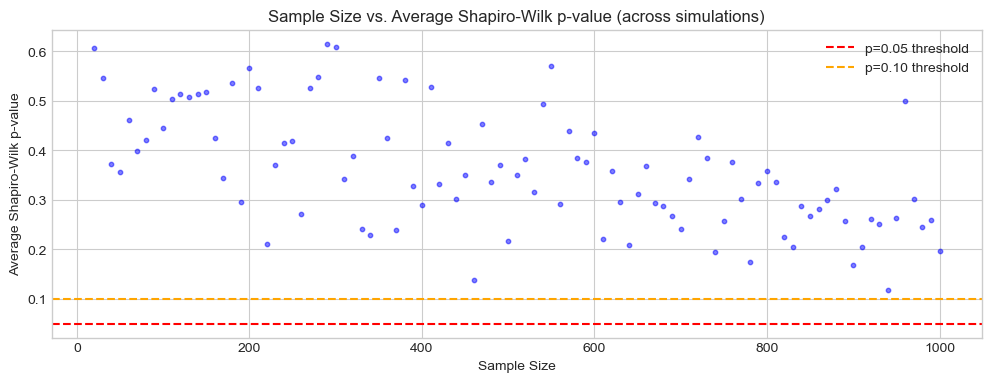

In [173]:
results_df = simulate_shapiro_test(residuals, min_sample_size=20, max_sample_size=1000, step_size=10, num_simulations=10, dot_size=10)

#### Checking Residuals: Homoscedasticity

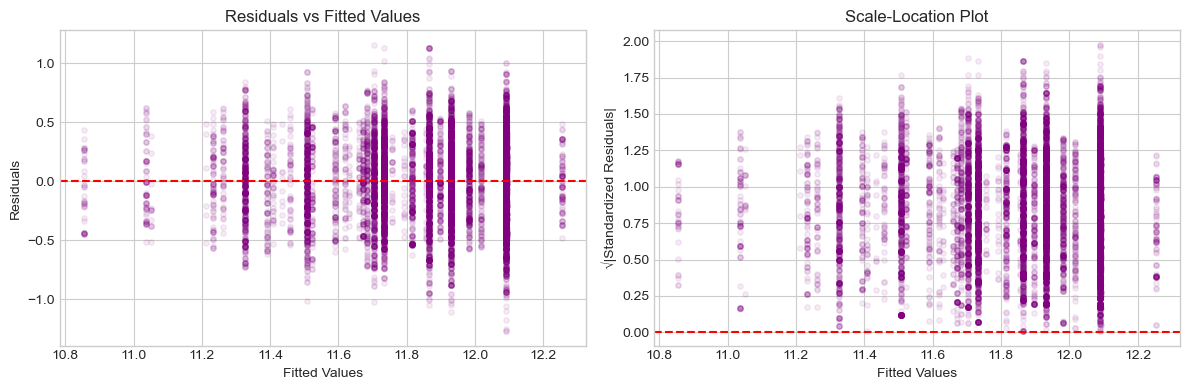

In [175]:
plot_residuals_diagnostics_homoscedasticity(fitted_values, residuals, dot_size=15, alpha=0.08)

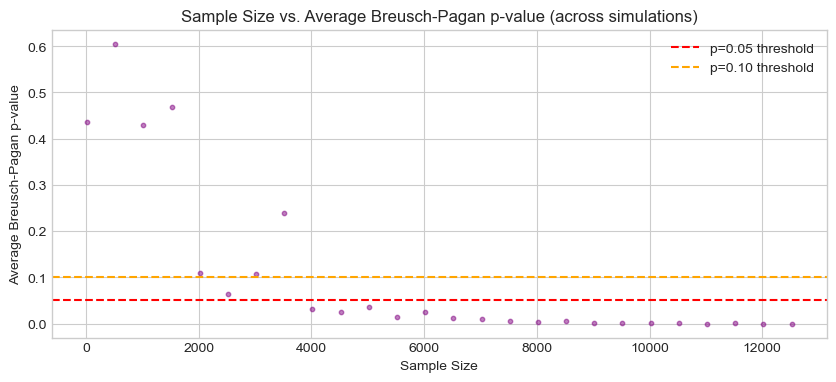

In [176]:
results_df = simulate_breusch_pagan_test(residuals, fitted_values, min_sample_size=20, max_sample_size=13000, step_size=500, num_simulations=10, dot_size=10)

### Making a prediction

In [178]:
specific_case = {
    'job_category': 'Data Scientist/ ML Engineer',
    'seniority_level': 'senior',
    'country': 'us'
}

In [179]:
# Predict salary for the specific case
predicted_salary, predicted_salary_p25, predicted_salary_p75 = predict_salary_for_case_log_perc(model, encoded_features, specific_case)

print(f"Predicted Median Salary: {predicted_salary:.2f}")
print(f"Predicted 25th Percentile Salary: {predicted_salary_p25:.2f}")
print(f"Predicted 75th Percentile Salary: {predicted_salary_p75:.2f}")

Predicted Median Salary: 178207.53
Predicted 25th Percentile Salary: 143071.27
Predicted 75th Percentile Salary: 221972.77


#### Plotting the prediction

In [181]:
specific_case = {
    'job_category': 'Data Scientist/ ML Engineer',
    'seniority_level': 'senior',
    'country': 'us'
}

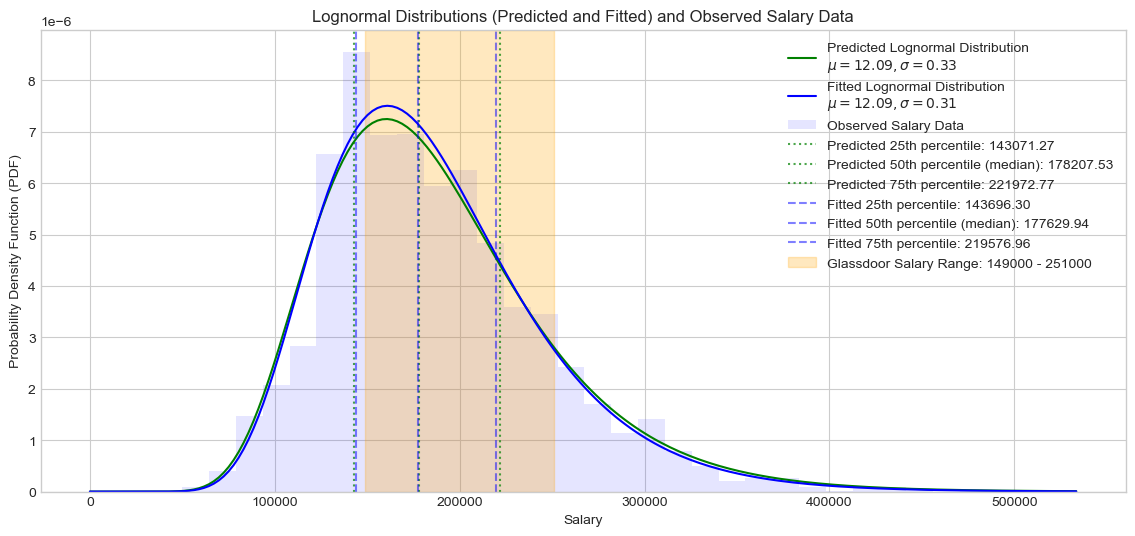

In [182]:
plot_salary_distributions(df_name, model, encoded_features, specific_case, glassdoor_data)

### The result

In [184]:
# Define your specific cases in the desired order
specific_cases = [
    {'job_category': 'Data Analyst', 'seniority_level': 'junior', 'country': 'us'},
    {'job_category': 'Data Analyst', 'seniority_level': 'medior', 'country': 'us'},
    {'job_category': 'Data Analyst', 'seniority_level': 'senior', 'country': 'us'},
    {'job_category': 'Data Engineer', 'seniority_level': 'junior', 'country': 'us'},
    {'job_category': 'Data Engineer', 'seniority_level': 'medior', 'country': 'us'},
    {'job_category': 'Data Engineer', 'seniority_level': 'senior', 'country': 'us'},
    {'job_category': 'Data Scientist/ ML Engineer', 'seniority_level': 'junior', 'country': 'us'},
    {'job_category': 'Data Scientist/ ML Engineer', 'seniority_level': 'medior', 'country': 'us'},
    {'job_category': 'Data Scientist/ ML Engineer', 'seniority_level': 'senior', 'country': 'us'},
]

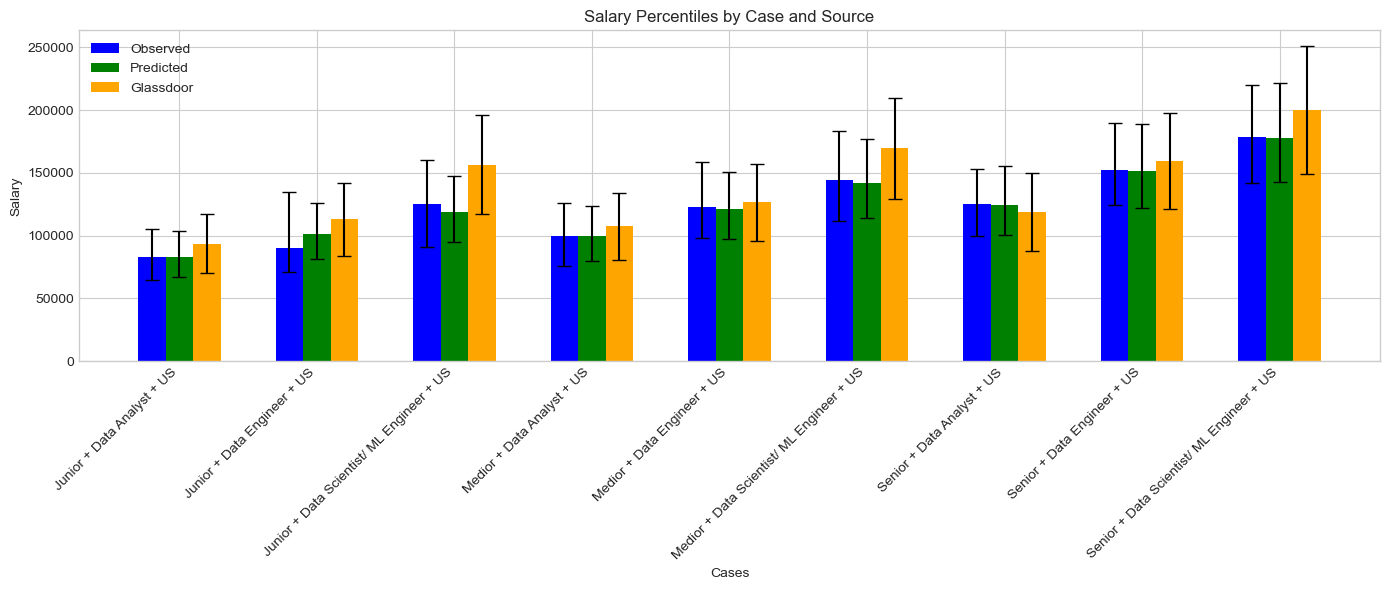

In [185]:
plot_salary_percentiles_by_case(df_name, model, encoded_features, specific_cases, glassdoor_data)

# Extended model

#### Initial run

In [514]:
df_name = df_it_w_l
categorical_vars = ['seniority_level', 'job_category', 'city_category','language_category','company_size_category','industry_category']
categorical_vars = ['seniority_level', 'job_category', 'city_category','language_category','company_size_category','industry_category']

specific_case = {
    'job_category': 'Data Analyst',
    'seniority_level': 'senior',
    'country': 'de',
    'language_category': 'English-speaking (but not german)',
    'company_size_category': 'l',
    'city_category': 'munich',
    'industry_category': 'manufacturing, transportation, or supply chain'
}

In [516]:
# Your prepared DataFrame
X = df_name[categorical_vars]
y = df_name['salary_norm_log']

# Train the model
model, encoded_features, X_encoded, y_aligned = train_model_1617(X, y)
model_for_coefficients_02 = model

# View the summary
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:        salary_norm_log   R-squared:                       0.486
Model:                            OLS   Adj. R-squared:                  0.481
Method:                 Least Squares   F-statistic:                     117.4
Date:                Mon, 16 Dec 2024   Prob (F-statistic):               0.00
Time:                        23:21:53   Log-Likelihood:                 772.72
No. Observations:                4513   AIC:                            -1471.
Df Residuals:                    4476   BIC:                            -1234.
Df Model:                          36                                         
Covariance Type:            nonrobust                                         
                                                                       coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------

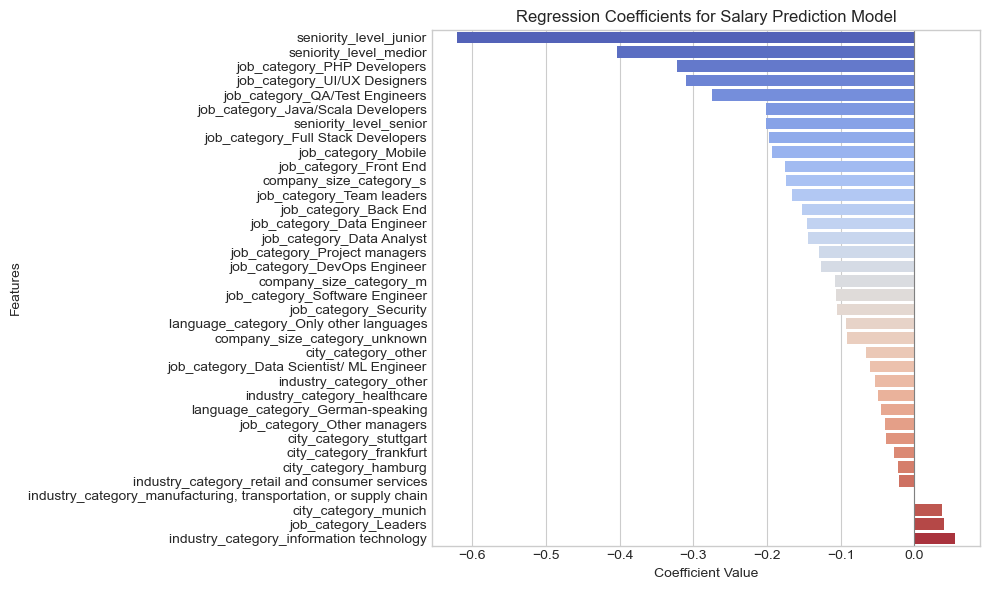

In [390]:
plot_model_coefficients(model,10,6)

#### Checking Residuals: Normality

In [393]:
# Extract residuals from the fitted model
residuals = model.resid
fitted_values = model.fittedvalues

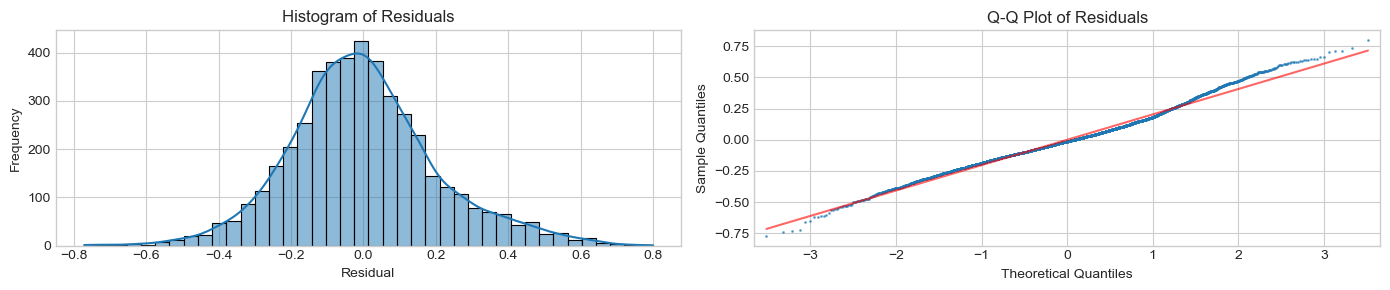

In [395]:
plot_residuals_diagnostics_normality(residuals, hist_bins=40, qq_marker_size=1, qq_alpha=0.6)

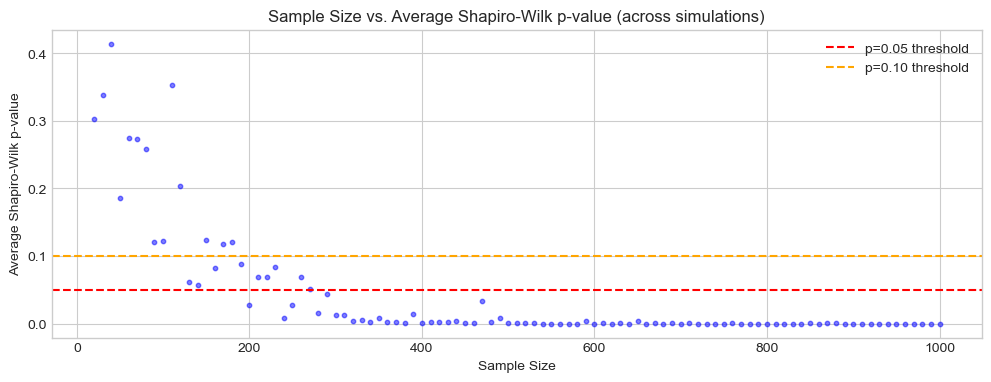

In [397]:
results_df = simulate_shapiro_test(residuals, min_sample_size=20, max_sample_size=1000, step_size=10, num_simulations=10, dot_size=10)

#### Checking Residuals: Homoscedasticity

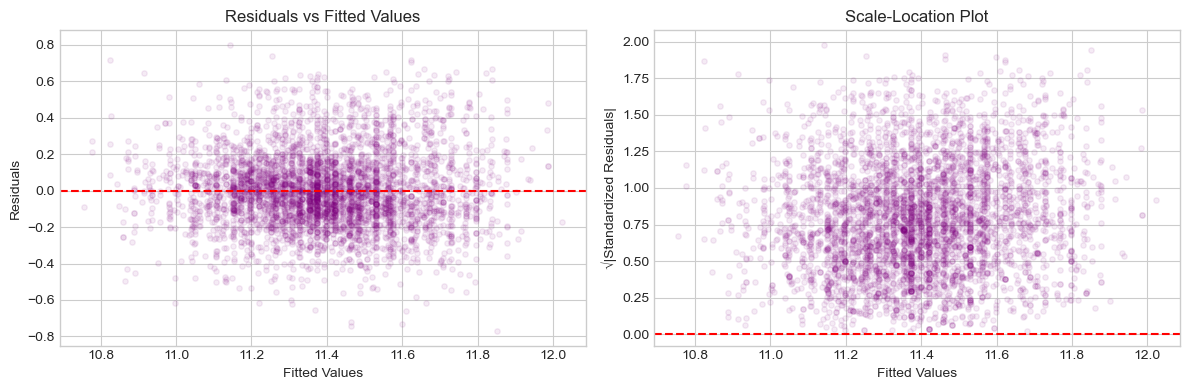

In [400]:
plot_residuals_diagnostics_homoscedasticity(fitted_values, residuals, dot_size=15, alpha=0.08)

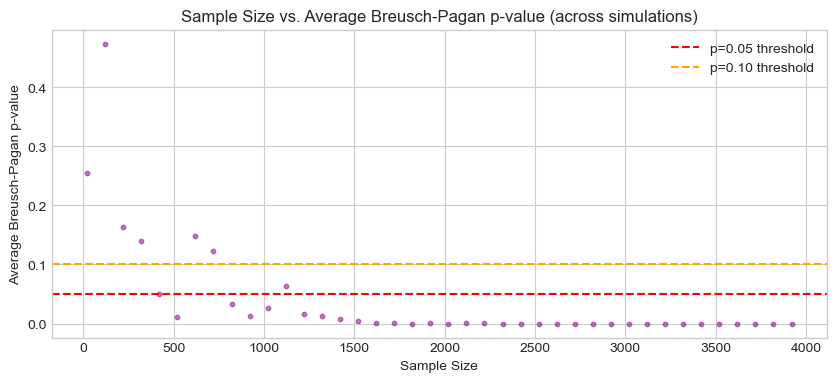

In [401]:
results_df = simulate_breusch_pagan_test(residuals, fitted_values, min_sample_size=20, max_sample_size=4000, step_size=100, num_simulations=10, dot_size=10)

#### Making an initial prediction

In [405]:
# Predict salary for the specific case
predicted_salary, predicted_salary_p25, predicted_salary_p75 = predict_salary_for_case_log_perc(model, encoded_features, specific_case)

print(f"Predicted Median Salary: {predicted_salary:.2f}")
print(f"Predicted 25th Percentile Salary: {predicted_salary_p25:.2f}")
print(f"Predicted 75th Percentile Salary: {predicted_salary_p75:.2f}")

Predicted Median Salary: 107261.12
Predicted 25th Percentile Salary: 93426.52
Predicted 75th Percentile Salary: 123144.35


#### Influential points

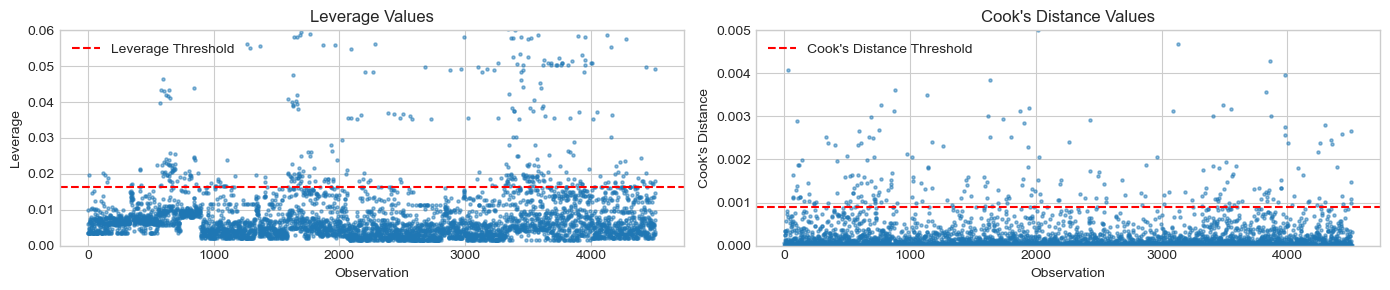

In [407]:
# Calculate leverage and Cook's Distance using the model
leverage, cooks_d = calculate_leverage_and_cooks_distance(model)

# Plot the leverage and Cook's Distance
plot_leverage_and_cooks_distance(leverage, cooks_d)

Number of high leverage points: 381
Number of high Cook's Distance points: 257
Number of influential points (either condition): 547


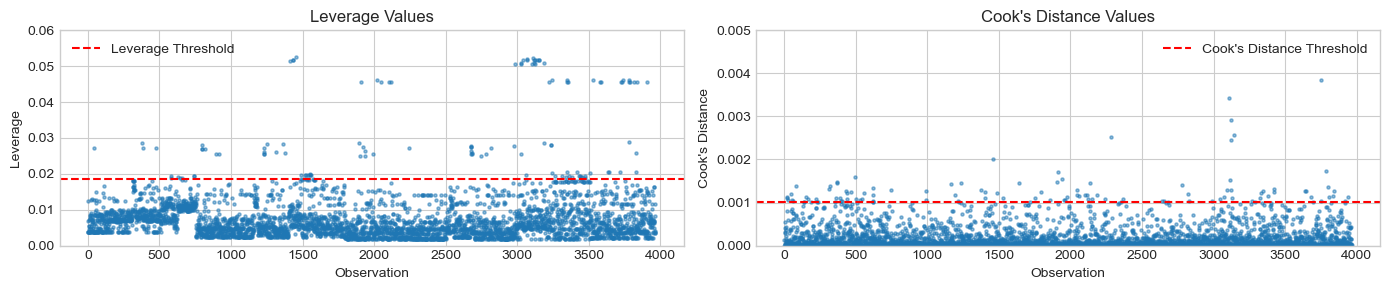

In [409]:
# Leverage OR cook's D EITHER high
# Identify observations with high leverage or high Cook's Distance
n = len(leverage)
p = model.df_model
leverage_threshold = 2 * (p + 1) / n
cooks_threshold = 4 / n

# Identify high leverage and high Cook's Distance points separately
high_leverage_points = np.where(leverage > leverage_threshold)[0]
high_cooks_points = np.where(cooks_d > cooks_threshold)[0]

# Use the union of high leverage and high Cook's Distance points
influential_points = np.union1d(high_leverage_points, high_cooks_points)

print(f"Number of high leverage points: {len(high_leverage_points)}")
print(f"Number of high Cook's Distance points: {len(high_cooks_points)}")
print(f"Number of influential points (either condition): {len(influential_points)}")

# Remove influential observations
X_encoded_cleaned = X_encoded.drop(index=influential_points).reset_index(drop=True)
y_cleaned = y_aligned.drop(index=influential_points).reset_index(drop=True)

# Refit the model without influential observations
model_cleaned = sm.OLS(y_cleaned, X_encoded_cleaned).fit()

# Recalculate leverage and Cook's Distance
leverage_cleaned, cooks_d_cleaned = calculate_leverage_and_cooks_distance(model_cleaned)

# Plot again
plot_leverage_and_cooks_distance(leverage_cleaned, cooks_d_cleaned)

In [411]:
# Ensure indices are aligned with the original DataFrame
X_encoded_with_index = X_encoded.reset_index(drop=True)
y_aligned_with_index = y_aligned.reset_index(drop=True)

# Original indices (positions after resetting index)
original_indices = X_encoded_with_index.index

# Map influential points to positions in df_combined
# Reset index of df_combined to ensure alignment
df_name_reset = df_name.reset_index(drop=True)

# Ensure that df_combined_reset has the same number of rows as X_encoded_with_index
assert len(df_name_reset) == len(X_encoded_with_index), "Mismatch in number of rows"

# Retrieve influential observations from the original DataFrame
df_name_influential = df_name_reset.iloc[influential_points]

# Remove the influential points from the original data frame, creating a new df
df_name_noninfl = df_name_reset.drop(index=influential_points).reset_index(drop=True)

# Examine influential observations
#df_name_influential.head()

In [413]:
print("Original DataFrame shape:", df_name_reset.shape)
print("Number of influential points:", len(influential_points))
print("DataFrame without influential points shape:", df_name_noninfl.shape)

Original DataFrame shape: (4513, 53)
Number of influential points: 547
DataFrame without influential points shape: (3966, 53)


#### comparing VIFs, Running w/o influential points

In [417]:
# Define the formula for the model
formula = 'salary_2024_log ~ ' + ' + '.join(['C(' + var + ')' for var in categorical_vars])

# Get design matrices for VIF calculation
y, X = dmatrices(formula, data=df_name, return_type='dataframe')

# Calculate VIF for each feature
vif = pd.DataFrame()
vif["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
vif["Feature"] = X.columns

vif.sort_values(by='VIF', ascending=False).head(50)

VIF                                            Feature
0  106.70                                          Intercept
19   7.98               C(job_category)[T.Software Engineer]
35   6.49                      C(industry_category)[T.other]
4    5.73                        C(job_category)[T.Back End]
33   5.30     C(industry_category)[T.information technology]
7    4.67     C(job_category)[T.Data Scientist/ ML Engineer]
9    3.58                       C(job_category)[T.Front End]
17   3.21               C(job_category)[T.QA/Test Engineers]
3    2.94                       C(seniority_level)[T.senior]
8    2.86                 C(job_category)[T.DevOps Engineer]
2    2.80                       C(seniority_level)[T.medior]
13   2.58                          C(job_category)[T.Mobile]
16   2.58                C(job_category)[T.Project managers]
20   2.57                    C(job_category)[T.Team leaders]
14   2.53                  C(job_category)[T.Other managers]
12   2.35                         C(job_category)[T.Leaders]
5    1.80                    C(job_category)[T.Data Analyst]
36   1.78  C(industry_category)[T.retail and consumer ser...
10   1.73           C(job_category)[T.Full Stack Developers]
11   1.65           C(job_category)[T.Java/Scala Developers]
6    1.56                   C(job_category)[T.Data Engineer]
34   1.39  C(industry_category)[T.manufacturing, transpor...
1    1.39                       C(seniority_level)[T.junior]
21   1.26                 C(job_category)[T.UI/UX Designers]
32   1.25                 C(industry_category)[T.healthcare]
29   1.24                      C(company_size_category)[T.m]
30   1.23                      C(company_size_category)[T.s]
18   1.18                        C(job_category)[T.Security]
15   1.17                  C(job_category)[T.PHP Developers]
24   1.15                         C(city_category)[T.munich]
25   1.15                          C(city_category)[T.other]
27   1.11            C(language_category)[T.German-speaking]
23   1.05                        C(city_category)[T.hamburg]
22   1.05                      C(city_category)[T.frankfurt]
28   1.04       C(language_category)[T.Only other languages]
26   1.04                      C(city_category)[T.stuttgart]
31   1.03                C(company_size_category)[T.unknown]

In [419]:
# Define the dataframe to be used
df_name = df_name_noninfl

# Define the formula for the model
formula = 'salary_2024_log ~ ' + ' + '.join(['C(' + var + ')' for var in categorical_vars])

# Get design matrices for VIF calculation
y, X = dmatrices(formula, data=df_name, return_type='dataframe')

# Calculate VIF for each feature
vif = pd.DataFrame()
vif["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
vif["Feature"] = X.columns

vif.sort_values(by='VIF', ascending=False).head(50)

VIF                                         Feature
0  250.71                                       Intercept
29  14.84                   C(industry_category)[T.other]
28  14.83  C(industry_category)[T.information technology]
17   9.02            C(job_category)[T.Software Engineer]
4    6.56                     C(job_category)[T.Back End]
7    5.16  C(job_category)[T.Data Scientist/ ML Engineer]
9    3.90                    C(job_category)[T.Front End]
16   3.57            C(job_category)[T.QA/Test Engineers]
8    3.12              C(job_category)[T.DevOps Engineer]
3    2.99                    C(seniority_level)[T.senior]
2    2.87                    C(seniority_level)[T.medior]
13   2.75                       C(job_category)[T.Mobile]
18   2.73                 C(job_category)[T.Team leaders]
15   2.73             C(job_category)[T.Project managers]
14   2.69               C(job_category)[T.Other managers]
12   2.42                      C(job_category)[T.Leaders]
5    1.81                 C(job_category)[T.Data Analyst]
10   1.80        C(job_category)[T.Full Stack Developers]
11   1.62        C(job_category)[T.Java/Scala Developers]
1    1.36                    C(seniority_level)[T.junior]
6    1.25                C(job_category)[T.Data Engineer]
27   1.22                   C(company_size_category)[T.s]
26   1.22                   C(company_size_category)[T.m]
21   1.14                      C(city_category)[T.munich]
22   1.13                       C(city_category)[T.other]
24   1.09         C(language_category)[T.German-speaking]
20   1.05                     C(city_category)[T.hamburg]
19   1.04                   C(city_category)[T.frankfurt]
23   1.02                   C(city_category)[T.stuttgart]
25   1.02    C(language_category)[T.Only other languages]

In [427]:
# Your prepared DataFrame
X = df_name_noninfl[categorical_vars]
y = df_name_noninfl['salary_2024_log']

# Train the model
model, encoded_features, X_encoded, y_aligned = train_model_1617(X, y)

# View the summary
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:        salary_2024_log   R-squared:                       0.506
Model:                            OLS   Adj. R-squared:                  0.502
Method:                 Least Squares   F-statistic:                     138.8
Date:                Mon, 16 Dec 2024   Prob (F-statistic):               0.00
Time:                        22:23:15   Log-Likelihood:                 1172.7
No. Observations:                3966   AIC:                            -2285.
Df Residuals:                    3936   BIC:                            -2097.
Df Model:                          29                                         
Covariance Type:            nonrobust                                         
                                               coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------

#### Checking Residuals: Normality

In [210]:
# Extract residuals from the fitted model
residuals = model.resid
fitted_values = model.fittedvalues

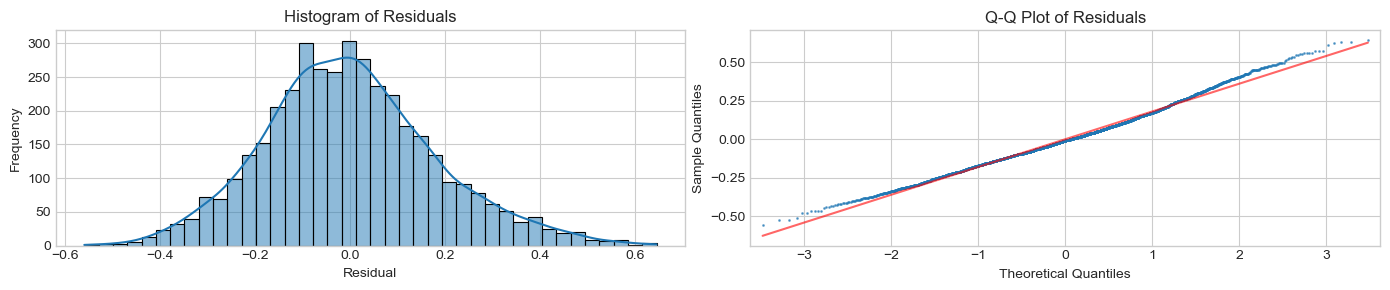

In [211]:
plot_residuals_diagnostics_normality(residuals, hist_bins=40, qq_marker_size=1, qq_alpha=0.6)

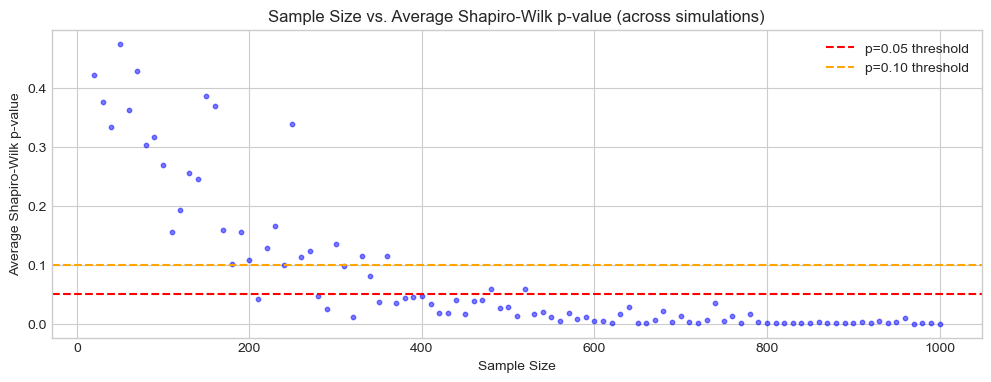

In [212]:
results_df = simulate_shapiro_test(residuals, min_sample_size=20, max_sample_size=1000, step_size=10, num_simulations=10, dot_size=10)

#### Checking Residuals: Homoscedasticity

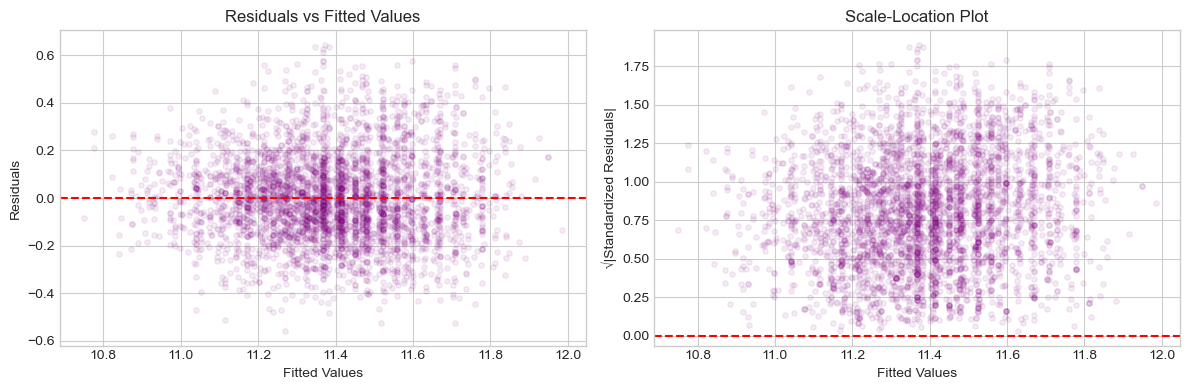

In [214]:
plot_residuals_diagnostics_homoscedasticity(fitted_values, residuals, dot_size=15, alpha=0.08)

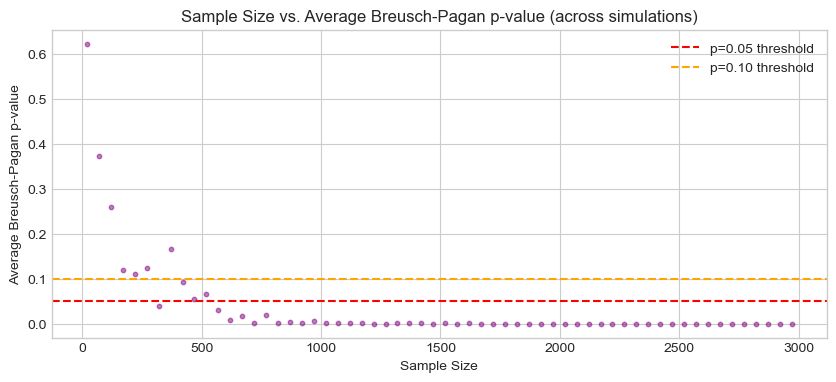

In [215]:
results_df = simulate_breusch_pagan_test(residuals, fitted_values, min_sample_size=20, max_sample_size=3000, step_size=50, num_simulations=10, dot_size=10)

#### Model interpretation

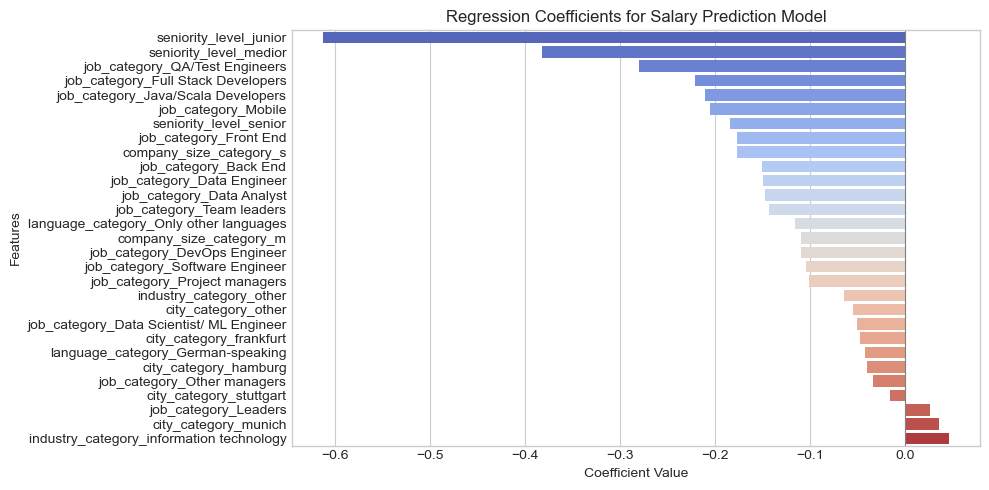

In [217]:
plot_model_coefficients(model,10,5)

#### Making an adjusted prediction

In [219]:
# Predict salary for the specific case
predicted_salary, predicted_salary_p25, predicted_salary_p75 = predict_salary_for_case_log_perc(model, encoded_features, specific_case)

print(f"Predicted Median Salary: {predicted_salary:.2f}")
print(f"Predicted 25th Percentile Salary: {predicted_salary_p25:.2f}")
print(f"Predicted 75th Percentile Salary: {predicted_salary_p75:.2f}")

Predicted Median Salary: 107072.42
Predicted 25th Percentile Salary: 94742.36
Predicted 75th Percentile Salary: 121007.16


# Extended model for the combined dataframe

#### Initial run

In [445]:
df_name = df_combined
categorical_vars = ['seniority_level', 'job_category','country','city_category','language_category','company_size_category','industry_category']
categorical_vars = ['seniority_level', 'job_category','country','company_size_category','industry_category']

specific_case = {
    'job_category': 'Data Analyst',
    'seniority_level': 'senior',
    'country': 'de',
    'language_category': 'English-speaking (but not german)',
    'company_size_category': 'l',
    'city_category': 'munich',
    'industry_category': 'manufacturing, transportation, or supply chain'
}

In [447]:
# Your prepared DataFrame
X = df_name[categorical_vars]
y = df_name['salary_norm_2024_log']

# Train the model
model, encoded_features, X_encoded, y_aligned = train_model_1617(X, y)

# View the summary
print(model.summary())

                             OLS Regression Results                             
Dep. Variable:     salary_norm_2024_log   R-squared:                       0.307
Model:                              OLS   Adj. R-squared:                  0.306
Method:                   Least Squares   F-statistic:                     256.0
Date:                  Mon, 16 Dec 2024   Prob (F-statistic):               0.00
Time:                          22:25:20   Log-Likelihood:                -10225.
No. Observations:                 26655   AIC:                         2.054e+04
Df Residuals:                     26608   BIC:                         2.093e+04
Df Model:                            46                                         
Covariance Type:              nonrobust                                         
                                                                       coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------

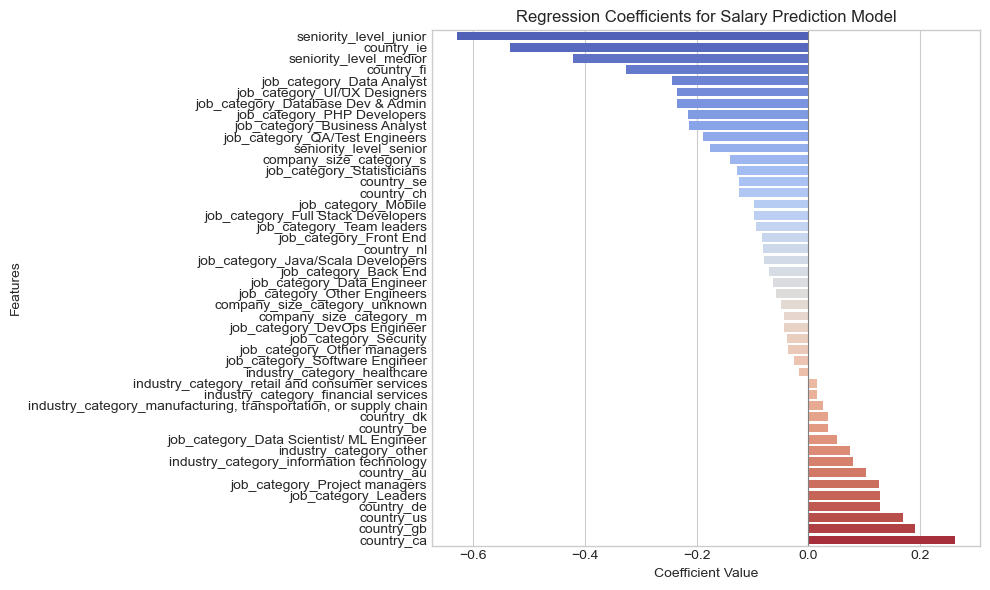

In [449]:
plot_model_coefficients(model,10,6)

#### Checking Residuals: Normality

In [226]:
# Extract residuals from the fitted model
residuals = model.resid
fitted_values = model.fittedvalues

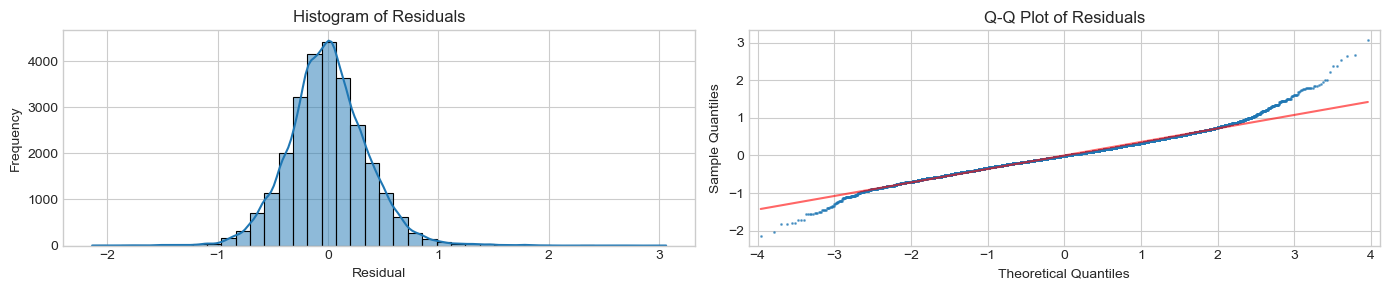

In [227]:
plot_residuals_diagnostics_normality(residuals, hist_bins=40, qq_marker_size=1, qq_alpha=0.6)

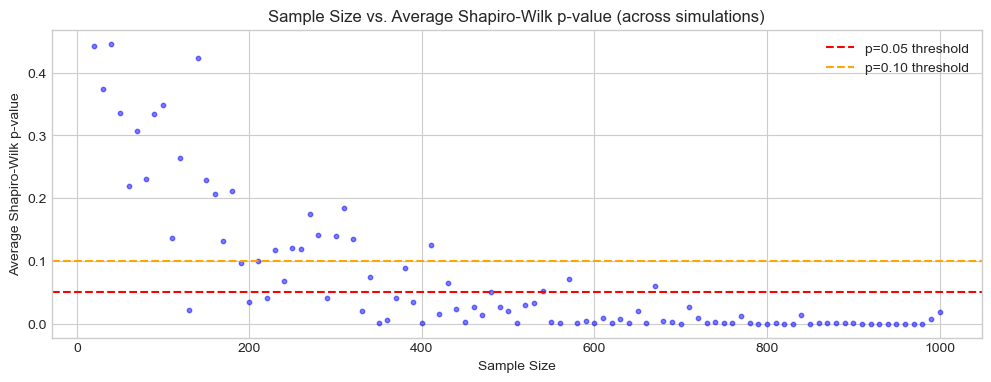

In [228]:
results_df = simulate_shapiro_test(residuals, min_sample_size=20, max_sample_size=1000, step_size=10, num_simulations=10, dot_size=10)

#### Checking Residuals: Homoscedasticity

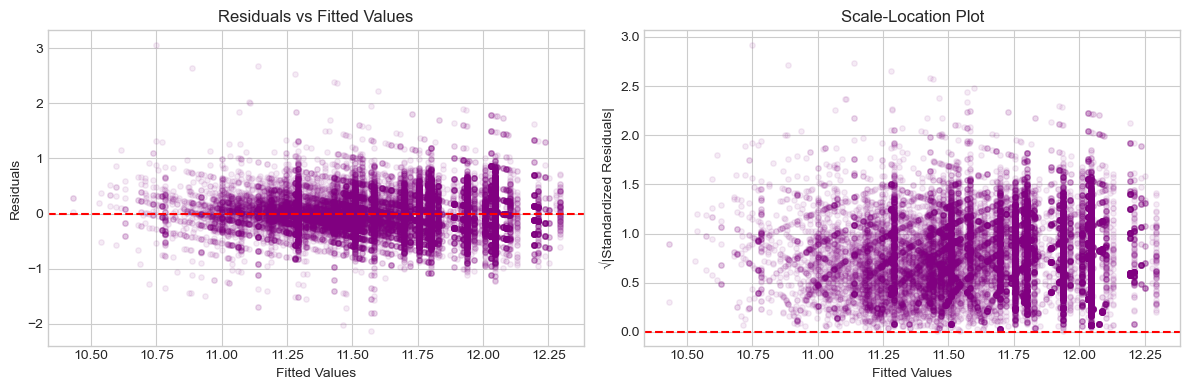

In [230]:
plot_residuals_diagnostics_homoscedasticity(fitted_values, residuals, dot_size=15, alpha=0.08)

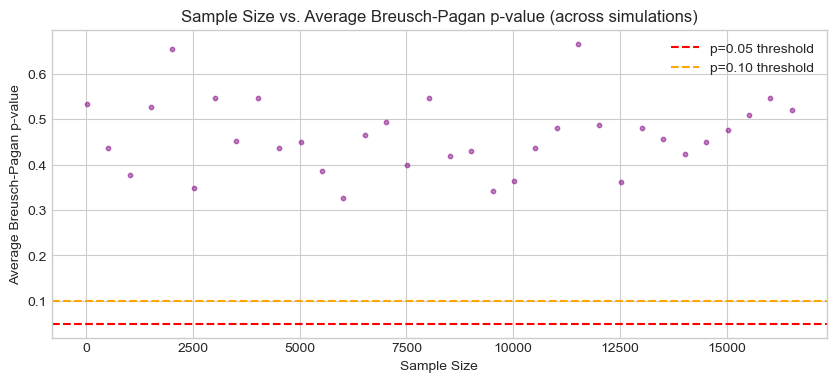

In [231]:
results_df = simulate_breusch_pagan_test(residuals, fitted_values, min_sample_size=20, max_sample_size=17000, step_size=500, num_simulations=10, dot_size=10)

#### Making an initial prediction

In [233]:
# Predict salary for the specific case
predicted_salary, predicted_salary_p25, predicted_salary_p75 = predict_salary_for_case_log_perc(model, encoded_features, specific_case)

print(f"Predicted Median Salary: {predicted_salary:.2f}")
print(f"Predicted 25th Percentile Salary: {predicted_salary_p25:.2f}")
print(f"Predicted 75th Percentile Salary: {predicted_salary_p75:.2f}")

Predicted Median Salary: 89584.85
Predicted 25th Percentile Salary: 70290.72
Predicted 75th Percentile Salary: 114175.04


#### Influential points

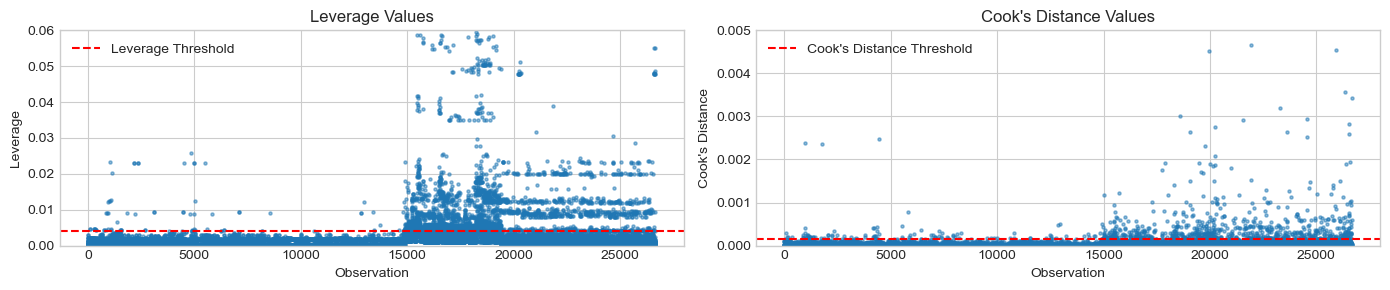

In [235]:
# Calculate leverage and Cook's Distance using the model
leverage, cooks_d = calculate_leverage_and_cooks_distance(model)

# Plot the leverage and Cook's Distance
plot_leverage_and_cooks_distance(leverage, cooks_d)

Number of high leverage points: 2778
Number of high Cook's Distance points: 884
Number of influential points (either condition): 3151


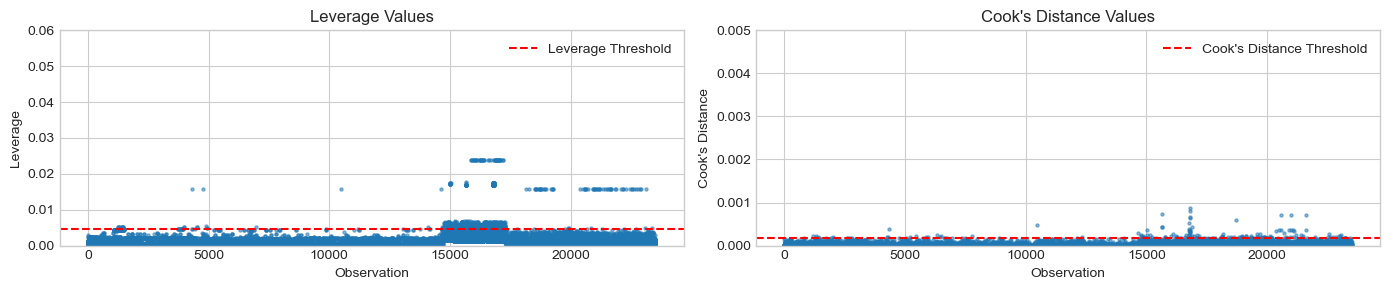

In [236]:
# Leverage OR cook's D EITHER high
# Identify observations with high leverage or high Cook's Distance
n = len(leverage)
p = model.df_model
leverage_threshold = 2 * (p + 1) / n
cooks_threshold = 4 / n

# Identify high leverage and high Cook's Distance points separately
high_leverage_points = np.where(leverage > leverage_threshold)[0]
high_cooks_points = np.where(cooks_d > cooks_threshold)[0]

# Use the union of high leverage and high Cook's Distance points
influential_points = np.union1d(high_leverage_points, high_cooks_points)

print(f"Number of high leverage points: {len(high_leverage_points)}")
print(f"Number of high Cook's Distance points: {len(high_cooks_points)}")
print(f"Number of influential points (either condition): {len(influential_points)}")

# Remove influential observations
X_encoded_cleaned = X_encoded.drop(index=influential_points).reset_index(drop=True)
y_cleaned = y_aligned.drop(index=influential_points).reset_index(drop=True)

# Refit the model without influential observations
model_cleaned = sm.OLS(y_cleaned, X_encoded_cleaned).fit()

# Recalculate leverage and Cook's Distance
leverage_cleaned, cooks_d_cleaned = calculate_leverage_and_cooks_distance(model_cleaned)

# Plot again
plot_leverage_and_cooks_distance(leverage_cleaned, cooks_d_cleaned)

In [237]:
# Ensure indices are aligned with the original DataFrame
X_encoded_with_index = X_encoded.reset_index(drop=True)
y_aligned_with_index = y_aligned.reset_index(drop=True)

# Original indices (positions after resetting index)
original_indices = X_encoded_with_index.index

# Map influential points to positions in df_combined
# Reset index of df_combined to ensure alignment
df_name_reset = df_name.reset_index(drop=True)

# Ensure that df_combined_reset has the same number of rows as X_encoded_with_index
assert len(df_name_reset) == len(X_encoded_with_index), "Mismatch in number of rows"

# Retrieve influential observations from the original DataFrame
df_name_influential = df_name_reset.iloc[influential_points]

# Remove the influential points from the original data frame, creating a new df
df_name_noninfl = df_name_reset.drop(index=influential_points).reset_index(drop=True)

# Examine influential observations
# df_name_influential.head()

In [238]:
print("Original DataFrame shape:", df_name_reset.shape)
print("Number of influential points:", len(influential_points))
print("DataFrame without influential points shape:", df_name_noninfl.shape)

Original DataFrame shape: (26655, 63)
Number of influential points: 3151
DataFrame without influential points shape: (23504, 63)


#### comparing VIFs, Running w/o influential points

In [240]:
# Define the formula for the model
formula = 'salary_log ~ ' + ' + '.join(['C(' + var + ')' for var in categorical_vars])

# Get design matrices for VIF calculation
y, X = dmatrices(formula, data=df_name, return_type='dataframe')

# Calculate VIF for each feature
vif = pd.DataFrame()
vif["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
vif["Feature"] = X.columns

vif.sort_values(by='VIF', ascending=False).head(50)

C:\ProgramData\anaconda3\Lib\site-packages\statsmodels\regression\linear_model.py:1783: RuntimeWarning: divide by zero encountered in scalar divide
  return 1 - self.ssr/self.centered_tss
C:\ProgramData\anaconda3\Lib\site-packages\statsmodels\regression\linear_model.py:1783: RuntimeWarning: invalid value encountered in scalar divide
  return 1 - self.ssr/self.centered_tss


VIF                                            Feature
19 7.98               C(job_category)[T.Software Engineer]
51 6.49                      C(industry_category)[T.other]
1  5.73                        C(job_category)[T.Back End]
49 5.30     C(industry_category)[T.information technology]
5  4.67     C(job_category)[T.Data Scientist/ ML Engineer]
8  3.58                       C(job_category)[T.Front End]
17 3.21               C(job_category)[T.QA/Test Engineers]
25 2.94                       C(seniority_level)[T.senior]
7  2.86                 C(job_category)[T.DevOps Engineer]
24 2.80                       C(seniority_level)[T.medior]
12 2.58                          C(job_category)[T.Mobile]
16 2.58                C(job_category)[T.Project managers]
21 2.57                    C(job_category)[T.Team leaders]
14 2.53                  C(job_category)[T.Other managers]
11 2.35                         C(job_category)[T.Leaders]
3  1.80                    C(job_category)[T.Data Analyst]
52 1.78  C(industry_category)[T.retail and consumer ser...
9  1.73           C(job_category)[T.Full Stack Developers]
10 1.65           C(job_category)[T.Java/Scala Developers]
4  1.56                   C(job_category)[T.Data Engineer]
50 1.39  C(industry_category)[T.manufacturing, transpor...
23 1.39                       C(seniority_level)[T.junior]
22 1.26                 C(job_category)[T.UI/UX Designers]
48 1.25                 C(industry_category)[T.healthcare]
40 1.24                      C(company_size_category)[T.m]
41 1.23                      C(company_size_category)[T.s]
18 1.18                        C(job_category)[T.Security]
15 1.17                  C(job_category)[T.PHP Developers]
45 1.15                         C(city_category)[T.munich]
46 1.15                          C(city_category)[T.other]
38 1.11            C(language_category)[T.German-speaking]
44 1.05                        C(city_category)[T.hamburg]
43 1.05                      C(city_category)[T.frankfurt]
39 1.04       C(language_category)[T.Only other languages]
47 1.04                      C(city_category)[T.stuttgart]
42 1.03                C(company_size_category)[T.unknown]
30 0.00                                   C(country)[T.de]
0  0.00                                          Intercept
2   NaN                C(job_category)[T.Business Analyst]
6   NaN            C(job_category)[T.Database Dev & Admin]
13  NaN                 C(job_category)[T.Other Engineers]
20  NaN                   C(job_category)[T.Statisticians]
26  NaN                                   C(country)[T.au]
27  NaN                                   C(country)[T.be]
28  NaN                                   C(country)[T.ca]
29  NaN                                   C(country)[T.ch]
31  NaN                                   C(country)[T.dk]
32  NaN                                   C(country)[T.fi]
33  NaN                                   C(country)[T.gb]
34  NaN                                   C(country)[T.ie]

Note: The warning "invalid value encountered in scalar divide" during VIF calculation
likely results from perfect multicollinearity or a lack of variance within certain categorical 
variables (e.g., constant values, sparse levels, or redundant categories). At this stage, 
we consider this warning to be informative and indicative of multicollinearity in the selected 
combination of variables.

In [242]:
# Define the dataframe to be used
df_name = df_name_noninfl

# Define the formula for the model
formula = 'salary_log ~ ' + ' + '.join(['C(' + var + ')' for var in categorical_vars])

# Get design matrices for VIF calculation
y, X = dmatrices(formula, data=df_name, return_type='dataframe')

# Calculate VIF for each feature
vif = pd.DataFrame()
vif["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
vif["Feature"] = X.columns

vif.sort_values(by='VIF', ascending=False).head(50)

C:\ProgramData\anaconda3\Lib\site-packages\statsmodels\regression\linear_model.py:1783: RuntimeWarning: divide by zero encountered in scalar divide
  return 1 - self.ssr/self.centered_tss
C:\ProgramData\anaconda3\Lib\site-packages\statsmodels\regression\linear_model.py:1783: RuntimeWarning: invalid value encountered in scalar divide
  return 1 - self.ssr/self.centered_tss


VIF                                         Feature
11 8.81            C(job_category)[T.Software Engineer]
1  6.80                     C(job_category)[T.Back End]
5  5.48  C(job_category)[T.Data Scientist/ ML Engineer]
6  3.47                    C(job_category)[T.Front End]
9  2.98             C(job_category)[T.Project managers]
8  2.87               C(job_category)[T.Other managers]
14 2.65                    C(seniority_level)[T.senior]
13 2.58                    C(seniority_level)[T.medior]
3  2.11                 C(job_category)[T.Data Analyst]
7  1.91                      C(job_category)[T.Leaders]
4  1.78                C(job_category)[T.Data Engineer]
10 1.62            C(job_category)[T.QA/Test Engineers]
12 1.40                    C(seniority_level)[T.junior]
21 1.21                   C(company_size_category)[T.m]
22 1.18                   C(company_size_category)[T.s]
24 1.12                       C(city_category)[T.other]
23 1.11                      C(city_category)[T.munich]
20 1.08         C(language_category)[T.German-speaking]
25 1.05                   C(industry_category)[T.other]
16 0.00                                C(country)[T.de]
0  0.00                                       Intercept
2   NaN             C(job_category)[T.Business Analyst]
15  NaN                                C(country)[T.ca]
17  NaN                                C(country)[T.gb]
18  NaN                                C(country)[T.nl]
19  NaN                                C(country)[T.us]

Note: The warning "invalid value encountered in scalar divide" during VIF calculation
likely results from perfect multicollinearity or a lack of variance within certain categorical 
variables (e.g., constant values, sparse levels, or redundant categories). At this stage, 
we consider this warning to be informative and indicative of multicollinearity in the selected 
combination of variables.

In [244]:
# Your prepared DataFrame
X = df_name_noninfl[categorical_vars]
y = df_name_noninfl['salary_log']

# Train the model
model, encoded_features, X_encoded, y_aligned = train_model_1617(X, y)

# View the summary
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:             salary_log   R-squared:                       0.454
Model:                            OLS   Adj. R-squared:                  0.453
Method:                 Least Squares   F-statistic:                     750.2
Date:                Mon, 16 Dec 2024   Prob (F-statistic):               0.00
Time:                        21:42:43   Log-Likelihood:                -8032.4
No. Observations:               23504   AIC:                         1.612e+04
Df Residuals:                   23477   BIC:                         1.634e+04
Df Model:                          26                                         
Covariance Type:            nonrobust                                         
                                               coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------

#### Checking Residuals: Normality

In [246]:
# Extract residuals from the fitted model
residuals = model.resid
fitted_values = model.fittedvalues

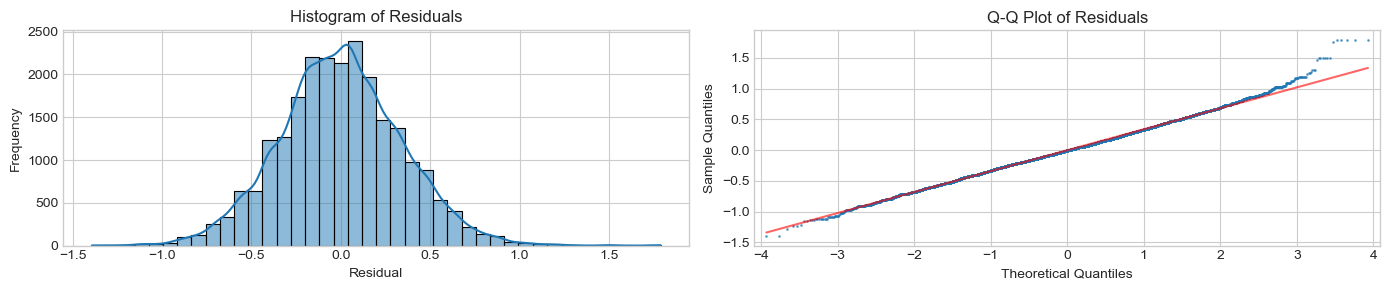

In [247]:
plot_residuals_diagnostics_normality(residuals, hist_bins=40, qq_marker_size=1, qq_alpha=0.6)

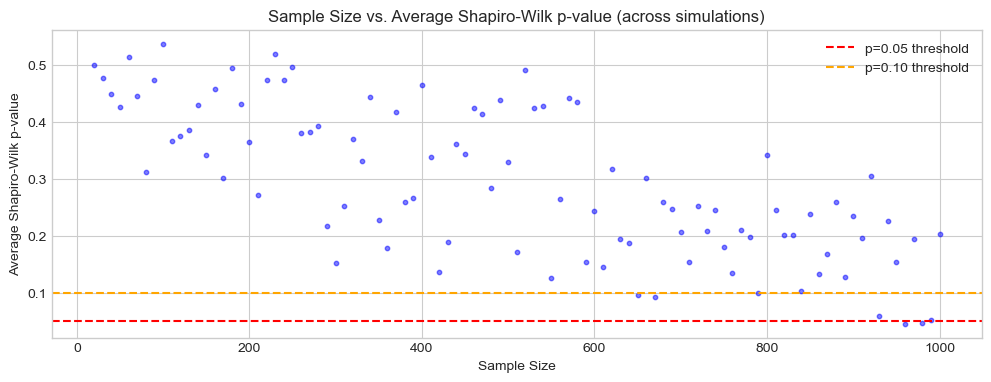

In [248]:
results_df = simulate_shapiro_test(residuals, min_sample_size=20, max_sample_size=1000, step_size=10, num_simulations=10, dot_size=10)

#### Checking Residuals: Homoscedasticity

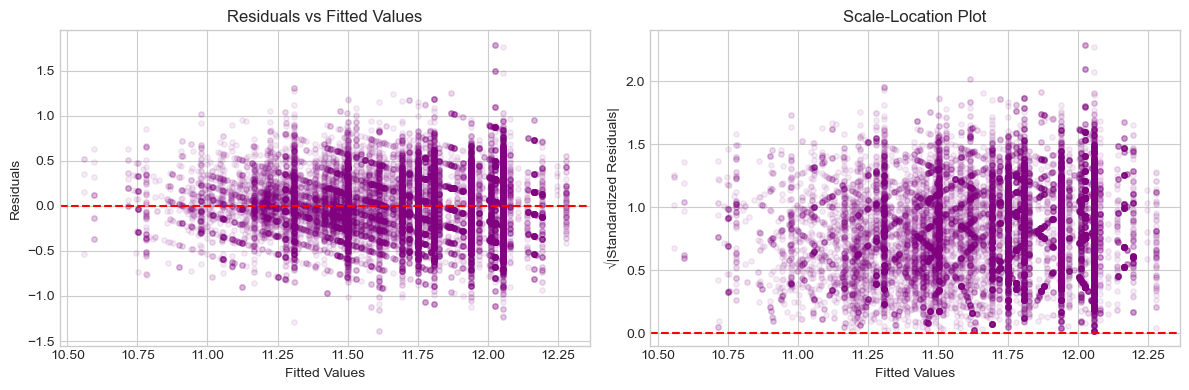

In [250]:
plot_residuals_diagnostics_homoscedasticity(fitted_values, residuals, dot_size=15, alpha=0.08)

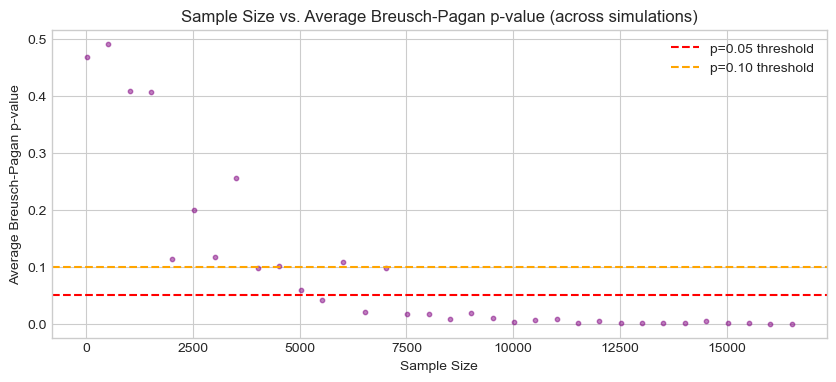

In [251]:
results_df = simulate_breusch_pagan_test(residuals, fitted_values, min_sample_size=20, max_sample_size=17000, step_size=500, num_simulations=10, dot_size=10)

#### Model interpretation

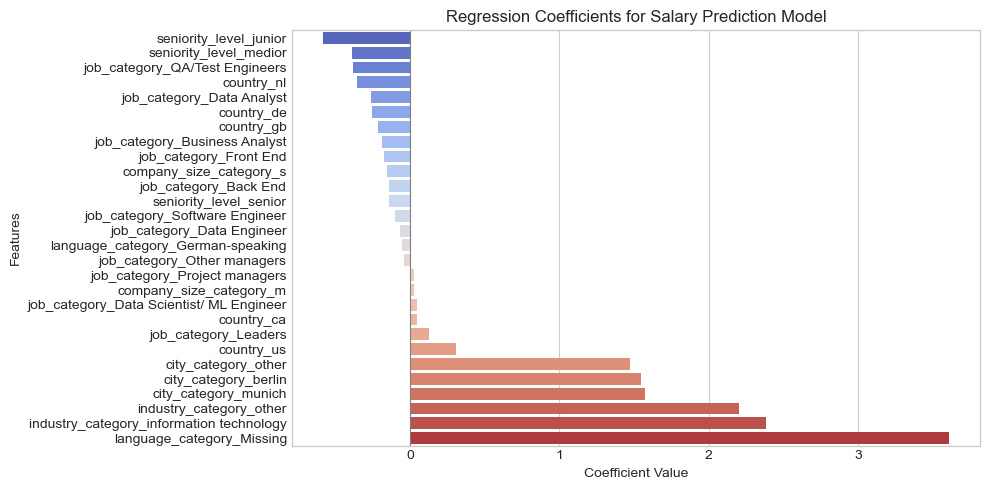

In [253]:
plot_model_coefficients(model,10,5)

#### Making an adjusted prediction

In [255]:
# Predict salary for the specific case
predicted_salary, predicted_salary_p25, predicted_salary_p75 = predict_salary_for_case_log_perc(model, encoded_features, specific_case)

print(f"Predicted Median Salary: {predicted_salary:.2f}")
print(f"Predicted 25th Percentile Salary: {predicted_salary_p25:.2f}")
print(f"Predicted 75th Percentile Salary: {predicted_salary_p75:.2f}")

Predicted Median Salary: 9154.64
Predicted 25th Percentile Salary: 7274.91
Predicted 75th Percentile Salary: 11520.08


# The Coefficients 

<div class="c">
To interpret the model's coefficient, correct VIF values are crucial.<br>
</div> 

In [465]:
def extract_coefficients(model):
    """
    Extract coefficients from a statsmodels regression model with improved handling of categorical variables.
    
    Parameters:
    -----------
    model : statsmodels regression model
    
    Returns:
    --------
    tuple: (DataFrame of coefficients, base intercept)
    """
    # Extract model summary as a DataFrame
    summary_df = model.summary2().tables[1]
    
    # Create a DataFrame with all coefficients
    data = []
    intercept_value = None
    
    for name, coef in zip(summary_df.index, summary_df['Coef.']):
        # Handle the constant/base intercept
        if name == 'const':
            intercept_value = coef
            continue
        
        # Split variable names with multiple underscore parts
        if '_' in name:
            # Special handling for predefined variable categories
            category_prefixes = [
                'job_category_', 
                'seniority_level_', 
                'country_', 
                'language_category_', 
                'company_size_category_', 
                'city_category_', 
                'industry_category_'
            ]
            
            # Find the matching prefix
            for prefix in category_prefixes:
                if name.startswith(prefix):
                    variable = prefix.rstrip('_')
                    level = name[len(prefix):]
                    break
            else:
                # Fallback if no prefix matches
                variable = name
                level = 'Intercept'
        else:
            variable = name
            level = 'Intercept'
        
        # Add to data
        data.append({
            'Variable': variable, 
            'Level': level, 
            'Coefficient': coef
        })
    
    return pd.DataFrame(data), intercept_value

In [467]:
# # Baseline mapping extracted from the data
# baseline_mapping = {}

def transform_coefficients(df, intercept):
    """
    Transform coefficients to percentage differences from the base level (100%).

    Parameters:
    -----------
    df : DataFrame of coefficients
    intercept : float, base intercept value

    Returns:
    --------
    DataFrame with percentage transformations
    """
    # Create a copy of the DataFrame
    transformed_df = df.copy()

    # Convert coefficients to percentages relative to base level (intercept)
    transformed_df['Percentage'] = np.exp(transformed_df['Coefficient'] + np.log(intercept)) / intercept * 100

    return transformed_df

def plot_percentage_coefficients(df, variable_name, intercept, sizex, sizey):
    """
    Plot coefficients as percentage differences from the base level.

    Parameters:
    -----------
    df : DataFrame of coefficients
    variable_name : str, name of the variable to plot
    intercept : float, base intercept value
    """
    # Filter coefficients for the specific variable
    subset = df[df['Variable'] == variable_name].copy()

    # Transform coefficients
    transformed_subset = transform_coefficients(subset, np.exp(intercept))

    # Always include the baseline at 100%, using the baseline_mapping for label
    baseline_label = baseline_mapping.get(variable_name, 'Base/Reference Level')
    baseline_row = pd.DataFrame({
        'Variable': [variable_name],
        'Level': [baseline_label],
        'Percentage': [100.0]
    })

    # Combine baseline with other levels
    plot_df = pd.concat([baseline_row, transformed_subset], ignore_index=True)

    # Sort the levels to make the plot more readable
    plot_df = plot_df.sort_values('Percentage')

    # Create horizontal bar plot
    plt.figure(figsize=(sizex, sizey))
    bars = plt.barh(plot_df['Level'], plot_df['Percentage'], color='#0e2a47ff')

    # Adjust plot limits to ensure labels fit within the background
    max_percentage = plot_df['Percentage'].max()
    plt.xlim(0, max_percentage * 1.2)  # Add padding to the right

    # Add percentage labels to the end of each bar
    for bar in bars:
        width = bar.get_width()
        plt.text(width, bar.get_y() + bar.get_height()/2, f'{width:.1f}%', 
                 ha='left', va='center', fontweight='bold')

    plt.title(f'Percentage Differences for {variable_name} Levels')
    plt.xlabel('Percentage Relative to Base Level')
    plt.ylabel('Levels')
    plt.tight_layout()
    plt.show()

## From initial model

In [470]:
# Determine the intercept levels for each categorical variable
baseline_mapping = {}
for var in categorical_vars:
    # Get unique values for the variable, fill NaN with 'Missing', and sort them
    unique_values = sorted(df_combined[var].fillna('Missing').unique())
    baseline_mapping[var] = unique_values[0]  # The first value is the baseline

# Output the baseline mapping
baseline_mapping

{'seniority_level': 'executive',
 'job_category': 'Architects',
 'country': 'at',
 'company_size_category': 'l',
 'industry_category': 'Missing'}

In [472]:
# Example usage (uncomment and adjust as needed)
df, intercept_value = extract_coefficients(model_for_coefficients_01)

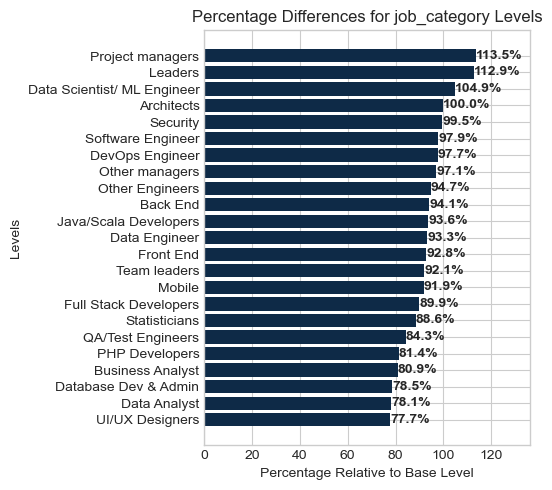

In [474]:
plot_percentage_coefficients(df, 'job_category', intercept_value, 5.5, 5)

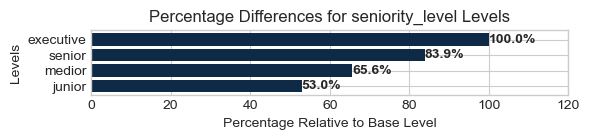

In [476]:
plot_percentage_coefficients(df, 'seniority_level', intercept_value, 6, 1.5)

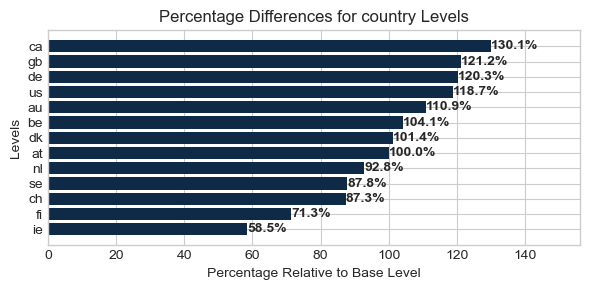

In [478]:
plot_percentage_coefficients(df, 'country', intercept_value, 6, 3)

## From extended model

In [480]:
# Determine the intercept levels for each categorical variable
baseline_mapping = {}
for var in categorical_vars:
    # Get unique values for the variable, fill NaN with 'Missing', and sort them
    unique_values = sorted(df_it_w_l[var].fillna('Missing').unique())
    baseline_mapping[var] = unique_values[0]  # The first value is the baseline

# Output the baseline mapping
baseline_mapping

{'seniority_level': 'executive',
 'job_category': 'Architects',
 'country': 'de',
 'company_size_category': 'l',
 'industry_category': 'financial services'}

In [482]:
# Example usage (uncomment and adjust as needed)
df, intercept_value = extract_coefficients(model_for_coefficients_02)

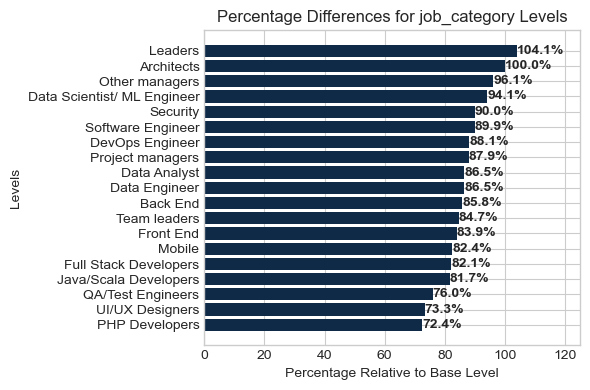

In [484]:
plot_percentage_coefficients(df, 'job_category', intercept_value, 6, 4)

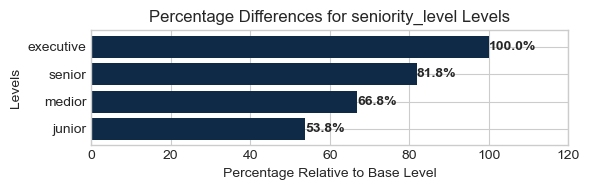

In [486]:
plot_percentage_coefficients(df, 'seniority_level', intercept_value, 6, 2)

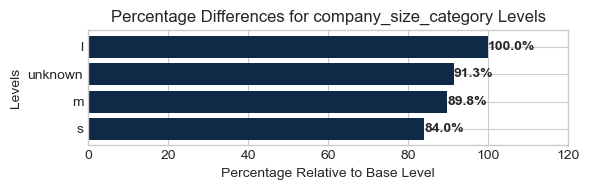

In [488]:
plot_percentage_coefficients(df, 'company_size_category', intercept_value, 6, 2)

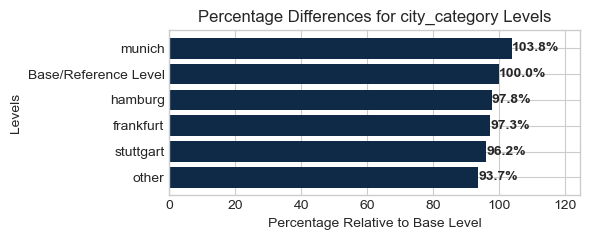

In [490]:
plot_percentage_coefficients(df, 'city_category', intercept_value, 6, 2.5)

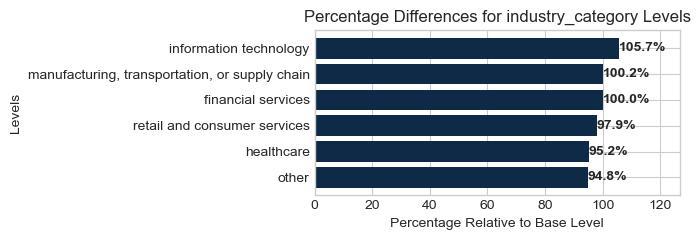

In [492]:
plot_percentage_coefficients(df, 'industry_category', intercept_value, 7, 2.5)

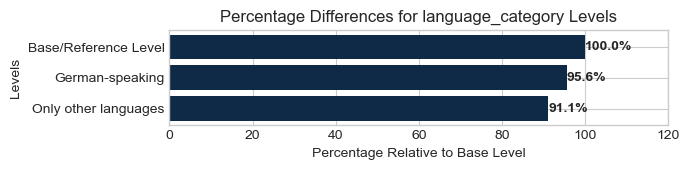

In [494]:
plot_percentage_coefficients(df, 'language_category', intercept_value, 7, 1.8)

# Refined prediction by weighted coefficients

In [538]:
print(model_for_coefficients_02.summary())

                            OLS Regression Results                            
Dep. Variable:        salary_norm_log   R-squared:                       0.486
Model:                            OLS   Adj. R-squared:                  0.481
Method:                 Least Squares   F-statistic:                     117.4
Date:                Wed, 18 Dec 2024   Prob (F-statistic):               0.00
Time:                        23:37:33   Log-Likelihood:                 772.72
No. Observations:                4513   AIC:                            -1471.
Df Residuals:                    4476   BIC:                            -1234.
Df Model:                          36                                         
Covariance Type:            nonrobust                                         
                                                                       coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------

In [540]:
# Determine the intercept levels for each categorical variable
baseline_mapping = {}
for var in categorical_vars:
    # Get unique values for the variable, fill NaN with 'Missing', and sort them
    unique_values = sorted(df_it_w_l[var].fillna('Missing').unique())
    baseline_mapping[var] = unique_values[0]  # The first value is the baseline

# Output the baseline mapping
baseline_mapping

{'seniority_level': 'executive',
 'job_category': 'Architects',
 'city_category': 'berlin',
 'language_category': 'English-speaking (but not german)',
 'company_size_category': 'l',
 'industry_category': 'financial services'}

In [542]:
df_name = df_it_w_l

# After fitting your model, do:
# model = ...
coeff_df, intercept_value = extract_coefficients(model_for_coefficients_02)

# For each categorical variable, add the baseline category as a row with Coefficient = 0.0
# baseline_mapping is already defined in your code as per the snippet
for var in categorical_vars:
    baseline_level = baseline_mapping[var]
    # Check if baseline level exists in coeff_df
    if not ((coeff_df['Variable'] == var) & (coeff_df['Level'] == baseline_level)).any():
        # Create a DataFrame for the baseline row
        baseline_row = pd.DataFrame({
            'Variable': [var],
            'Level': [baseline_level],
            'Coefficient': [0.0]
        })
        
        # Use pd.concat instead of append
        coeff_df = pd.concat([coeff_df, baseline_row], ignore_index=True)

# Now coeff_df includes all categories, including the baseline as zero

# Create a "base_coefficients" DataFrame that can be directly used:
base_coefficients_df = coeff_df.copy()

# Next, compute weighted coefficients.
# The idea: 
# 1. For each variable, find the frequency of each level from df_combined.
# 2. Compute the weighted average of the coefficients according to these frequencies.
# 3. Subtract this weighted average from each coefficient to recenter them.

weighted_coefficients_df = pd.DataFrame(columns=['Variable', 'Level', 'Weighted_Coefficient'])

for var in categorical_vars:
    # Get all levels for this variable
    var_levels = base_coefficients_df[base_coefficients_df['Variable'] == var].copy()
    
    # Compute frequencies of each level in df_combined
    freq = df_name[var].fillna('Missing').value_counts(normalize=True).to_dict()
    
    # Ensure that every level in var_levels is present in freq. If missing, freq=0.
    for lvl in var_levels['Level']:
        if lvl not in freq:
            freq[lvl] = 0.0
    
    # Calculate weighted average
    weighted_avg = 0.0
    for i, row in var_levels.iterrows():
        c = row['Coefficient']
        f = freq[row['Level']]
        weighted_avg += c * f
    
    # Shift coefficients by subtracting the weighted average
    var_levels['Weighted_Coefficient'] = var_levels['Coefficient'] - weighted_avg
    
    # Append to the weighted_coefficients_df
    weighted_coefficients_df = pd.concat([weighted_coefficients_df, var_levels[['Variable', 'Level', 'Weighted_Coefficient']]], ignore_index=True)

# Now we have:
# base_coefficients_df: DataFrame with original coefficients + baseline rows
# weighted_coefficients_df: DataFrame with shifted coefficients so that the current distribution has a weighted average of zero.

# Example usage:
# If you want to predict a scenario with a particular variable's level, you'd take the Glassdoor prediction and multiply by (1 + Weighted_Coefficient) for that level.

# Print or inspect the results:
# print(base_coefficients_df)
# print(weighted_coefficients_df)

C:\Users\Viktor\AppData\Local\Temp\ipykernel_31388\1035838524.py:59: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  weighted_coefficients_df = pd.concat([weighted_coefficients_df, var_levels[['Variable', 'Level', 'Weighted_Coefficient']]], ignore_index=True)


In [552]:
base_coefficients_df

Variable                                           Level  \
0         seniority_level                                          junior   
1         seniority_level                                          medior   
2         seniority_level                                          senior   
3            job_category                                        Back End   
4            job_category                                    Data Analyst   
5            job_category                                   Data Engineer   
6            job_category                     Data Scientist/ ML Engineer   
7            job_category                                 DevOps Engineer   
8            job_category                                       Front End   
9            job_category                           Full Stack Developers   
10           job_category                           Java/Scala Developers   
11           job_category                                         Leaders   
12           job_category                                          Mobile   
13           job_category                                  Other managers   
14           job_category                                  PHP Developers   
15           job_category                                Project managers   
16           job_category                               QA/Test Engineers   
17           job_category                                        Security   
18           job_category                               Software Engineer   
19           job_category                                    Team leaders   
20           job_category                                 UI/UX Designers   
21          city_category                                       frankfurt   
22          city_category                                         hamburg   
23          city_category                                          munich   
24          city_category                                           other   
25          city_category                                       stuttgart   
26      language_category                                 German-speaking   
27      language_category                            Only other languages   
28  company_size_category                                               m   
29  company_size_category                                               s   
30  company_size_category                                         unknown   
31      industry_category                                      healthcare   
32      industry_category                          information technology   
33      industry_category  manufacturing, transportation, or supply chain   
34      industry_category                                           other   
35      industry_category                    retail and consumer services   
36        seniority_level                                       executive   
37           job_category                                      Architects   
38          city_category                                          berlin   
39      language_category               English-speaking (but not german)   
40  company_size_category                                               l   
41      industry_category                              financial services   

    Coefficient  
0         -0.62  
1         -0.40  
2         -0.20  
3         -0.15  
4         -0.14  
5         -0.15  
6         -0.06  
7         -0.13  
8         -0.18  
9         -0.20  
10        -0.20  
11         0.04  
12        -0.19  
13        -0.04  
14        -0.32  
15        -0.13  
16        -0.27  
17        -0.11  
18        -0.11  
19        -0.17  
20        -0.31  
21        -0.03  
22        -0.02  
23         0.04  
24        -0.07  
25        -0.04  
26        -0.04  
27        -0.09  
28        -0.11  
29        -0.17  
30        -0.09  
31        -0.05  
32         0.06  
33         0.00  
34        -0.05  
35        -0.02  
36         0.00  
37         0.00  
38 

In [554]:
weighted_coefficients_df

Variable                                           Level  \
0         seniority_level                                          junior   
1         seniority_level                                          medior   
2         seniority_level                                          senior   
3         seniority_level                                       executive   
4            job_category                                        Back End   
5            job_category                                    Data Analyst   
6            job_category                                   Data Engineer   
7            job_category                     Data Scientist/ ML Engineer   
8            job_category                                 DevOps Engineer   
9            job_category                                       Front End   
10           job_category                           Full Stack Developers   
11           job_category                           Java/Scala Developers   
12           job_category                                         Leaders   
13           job_category                                          Mobile   
14           job_category                                  Other managers   
15           job_category                                  PHP Developers   
16           job_category                                Project managers   
17           job_category                               QA/Test Engineers   
18           job_category                                        Security   
19           job_category                               Software Engineer   
20           job_category                                    Team leaders   
21           job_category                                 UI/UX Designers   
22           job_category                                      Architects   
23          city_category                                       frankfurt   
24          city_category                                         hamburg   
25          city_category                                          munich   
26          city_category                                           other   
27          city_category                                       stuttgart   
28          city_category                                          berlin   
29      language_category                                 German-speaking   
30      language_category                            Only other languages   
31      language_category               English-speaking (but not german)   
32  company_size_category                                               m   
33  company_size_category                                               s   
34  company_size_category                                         unknown   
35  company_size_category                                               l   
36      industry_category                                      healthcare   
37      industry_category                          information technology   
38      industry_category  manufacturing, transportation, or supply chain   
39      industry_category                                           other   
40      industry_category                    retail and consumer services   
41      industry_category                              financial services   

    Weighted_Coefficient  
0                  -0.38  
1                  -0.17  
2                   0.03  
3                   0.24  
4                  -0.03  
5                  -0.02  
6                  -0.02  
7                   0.07  
8                   0.00  
9                  -0.05  
10                 -0.07  
11                 -0.07  
12                  0.17  
13                 -0.07  
14                  0.09  
15                 -0.19  
16                 -0.00  
17                 -0.15  
18                  0.02  
19                  0.02  
20                 -0.04  
21                 -0.18  
22                  0.13  
23                 -0.02  
24                 -0.02  
25 

In [566]:
specific_refined_case = {
    'language_category': 'English-speaking (but not german)',
    'company_size_category': 'l',
    'city_category': 'munich',
    'industry_category': 'manufacturing, transportation, or supply chain'
}

refined_combined_coefficient = intercept_value
for var, lvl in specific_refined_case.items():
    row = weighted_coefficients_df.loc[(weighted_coefficients_df['Variable'] == var) & (weighted_coefficients_df['Level'] == lvl)]
    if not row.empty:
        refined_combined_coefficient += row['Weighted_Coefficient'].iloc[0]

refined_combined_coefficient

1.2692851453185463

In [568]:
specific_glassdoor_case= {
    'job_category': 'Data Analyst',
    'seniority_level': 'senior',
    'country': 'de'
}

In [570]:

# Find the matching row
mask = (
    (glassdoor_data['job_category'] == specific_glassdoor_case['job_category']) &
    (glassdoor_data['seniority_level'] == specific_glassdoor_case['seniority_level']) &
    (glassdoor_data['country'] == specific_glassdoor_case['country'])
)

selected_row = glassdoor_data[mask]

if not selected_row.empty:
    # Compute a base estimate, for example the midpoint
    base_estimate = (selected_row['glassdoor_lower'].iloc[0] + selected_row['glassdoor_upper'].iloc[0]) / 2.0
    
    # Multiply by the refined combined coefficient
    adjusted_prediction = base_estimate * refined_combined_coefficient
    
    print("Base Glassdoor Estimate:", base_estimate)
    print("Refined Combined Coefficient:", refined_combined_coefficient)
    print("Adjusted Prediction:", adjusted_prediction)
else:
    print("No matching row found in the Glassdoor data.")


Base Glassdoor Estimate: 80500.0
Refined Combined Coefficient: 1.2692851453185463
Adjusted Prediction: 102177.45419814298


# Notes

<div class="c">
Here are some useful notes on interpreting the concepts/lingo related to predictive models<br>
</div> 

<div class="c">
General interpretation of OLS results<br>
________________________________________<br>
Model Summary<br>
The first section provides an overview of the regression model.<br>
•	Dep. Variable: This is the dependent variable (also known as the response or target variable) that the model aims to predict or explain.<br>
	It represents the outcome you're studying. For example, if salary_log is the dependent variable, the model predicts the logarithm of salary.<br>
•	Model: Indicates the type of regression model used.<br>
	OLS stands for Ordinary Least Squares, a method for estimating the unknown parameters in a linear regression model.<br>
•	Method: The estimation method used by the model.<br>
	Least Squares indicates that the model minimizes the sum of the squares of the residuals (differences between observed and predicted values).<br>
•	Date & Time: When the model was fitted.<br>
	Useful for record-keeping but doesn't affect model nterpretation.<br>
•	No. Observations: The number of observations (sample size) used in the regression.<br>
	A larger sample size can provide more reliable estimates.<br>
•	Df Residuals: Degrees of freedom of the residuals, calculated as the number of observations minus the number of estimated parameters.<br>
	Indicates the amount of information available to estimate the error variance.<br>
•	Df Model: Degrees of freedom of the model, equal to the number of independent variables (predictors) in the model.<br>
	Shows how many predictors are included, which affects the model's complexity.<br>
•	Covariance Type: Specifies the type of covariance matrix used for estimating standard errors.<br>
	nonrobust means standard errors assume homoscedasticity (constant variance of errors). Alternative types can adjust for heteroscedasticity.<br>
________________________________________<br>
Model Fit Statistics<br>
These metrics assess how well the model fits the data.<br>
•	R-squared: The coefficient of determination, indicating the proportion of variance in the dependent variable explained by the independent variables.<br>
	Ranges from 0 to 1. A higher value means a better fit. For example, an R-squared of 0.446 means 44.6% of the variance is explained by the model.<br>
•	Adj. R-squared: The adjusted R-squared adjusts the R-squared value based on the number of predictors relative to the sample size.<br>
	Accounts for the model complexity. It's useful when comparing models with a different number of predictors.<br>
•	F-statistic: Tests the overall significance of the model.<br>
	A higher F-statistic suggests that the model explains a significant amount of variance in the dependent variable.<br>
•	Prob (F-statistic): The p-value associated with the F-statistic.<br>
	A low p-value (typically less than 0.05) indicates that the model is statistically significant.<br>
•	Log-Likelihood: A measure of the model's fit based on the likelihood function.<br>
	Higher (less negative) values suggest a better fit. Useful for comparing nested models.<br>
•	AIC (Akaike Information Criterion): A measure for model comparison that penalizes complexity.<br>
	Lower AIC values indicate a better model when comparing different models.<br>
•	BIC (Bayesian Information Criterion): Similar to AIC but penalizes model complexity more heavily.<br>
	Used for model selection; lower values are preferred.<br>
________________________________________<br>
Coefficients Table<br>
This table provides detailed statistics for each predictor in the model.<br>
•	coef (Coefficient): The estimated effect of the predictor on the dependent variable.<br>
	Represents the change in the dependent variable for a one-unit change in the predictor, holding other variables constant.<br>
•	std err (Standard Error): The standard deviation of the coefficient estimate.<br>
	Measures the accuracy of the coefficient estimate. Smaller values indicate more precise estimates.<br>
•	t (t-statistic): The test statistic for the hypothesis that the coefficient equals zero.<br>
	Calculated as coef / std err. A higher absolute value suggests the coefficient is significantly different from zero.<br>
•	P>|t| (P-value): The probability of observing the data if the null hypothesis is true (that the coefficient is zero).<br>
	A low p-value (typically less than 0.05) indicates that the predictor is statistically significant.<br>
•	[0.025, 0.975] (Confidence Interval): The lower and upper bounds of the 95% confidence interval for the coefficient.<br>
	There's a 95% chance the true coefficient lies within this interval.<br>
	Example nterpretation for a Predictor Variable:<br>
•	Predictor: job_category_Back End<br>
	coef: The coefficient indicates the expected change in the dependent variable (e.g., salary_log) when the predictor (job_category_Back End) changes by one unit, holding all other variables constant.<br>
	P>|t|: A p-value less than 0.05 suggests the predictor significantly affects the dependent variable.<br>
________________________________________<br>
Diagnostic Tests and Statistics<br>
These metrics help assess the validity of the model assumptions and identify potential issues.<br>
•	Omnibus Test: A test for the normality of the residuals.<br>
	A significant result (low p-value) suggests the residuals are not normally distributed.<br>
•	Prob(Omnibus): The p-value associated with the Omnibus test.<br>
	If less than 0.05, it indicates a deviation from normality.<br>
•	Jarque-Bera (JB) Test: Another test for normality, focusing on skewness and kurtosis.<br>
	Similar to the Omnibus test; a low p-value indicates non-normality.<br>
•	Prob(JB): The p-value for the Jarque-Bera test.<br>
•	Skew: Measures the asymmetry of the residual distribution.<br>
	A value near zero indicates a symmetrical distribution. Positive values indicate right skewness; negative values indicate left skewness.<br>
•	Kurtosis: Measures the "tailedness" of the residual distribution.<br>
	A value of 3 indicates normal kurtosis. Values greater than 3 suggest heavier tails; values less than 3 suggest lighter tails.<br>
•	Durbin-Watson Statistic: Tests for autocorrelation in the residuals.<br>
	Values range from 0 to 4. A value around 2 suggests no autocorrelation. Values approaching 0 indicate positive autocorrelation; values approaching 4 indicate negative autocorrelation.<br>
•	Cond. No. (Condition Number): Indicates the sensitivity of the regression estimates to small changes in the data, related to multicollinearity.<br>
	High values (generally above 30) suggest multicollinearity problems, which can affect the stability of coefficient estimates.<br>
<br>
<br>
</div> 

<div class="c">
A thought about Normality:

"Necessity of Normality in OLS regression:

Normality of residuals is not strictly required for unbiased coefficients.
It is important when:
Constructing confidence intervals or p-values (e.g., if n is small, normality matters more).
Using methods that depend heavily on normality (e.g., prediction intervals)."
</div> 

<div class="c">
Ensuring Valid Predictions with OLS Regression<br>
<br>
1. Verify Model Assumptions<br>
Normality of Residuals: Ensure residuals are approximately normally distributed, as this supports the validity of hypothesis testing and confidence intervals.<br>
Homoscedasticity: Confirm that residuals have constant variance across levels of the predictors. This ensures unbiased and consistent standard errors.<br>
Independence of Observations: Ensure that observations are independent of one another to avoid biases introduced by clustering or temporal dependencies.<br>
    <br>
2. Handle Outliers and Influential Points<br>
Identify and address leverage points and influential observations using measures such as Cook’s Distance or standardized residuals. Removing or adjusting these points can prevent them from <br>disproportionately affecting model results.<br>
<br>
3. Address Multicollinearity<br>
Check for multicollinearity using diagnostics such as Variance Inflation Factor (VIF) or condition numbers. High multicollinearity can lead to unstable coefficients and poor interpretability, though predictions may remain valid if the model is properly specified.<br>
<br>
4. Ensure Adequate Representation of Categories<br>
For categorical predictors, ensure that each level has a sufficient number of observations. Small sample sizes for certain categories can lead to unstable coefficient estimates and unreliable predictions.<br>
    <br>
5. Avoid Extrapolation<br>
Limit predictions to combinations of predictors that are well-represented in the training data. Predictions outside this range are less reliable and may reflect model instability rather than true relationships.<br>
    <br>
6. Evaluate and Include Interaction Effects<br>
Consider whether interactions between predictors are meaningful and test their inclusion. Omitting significant interactions can bias predictions and lead to poor model fit.<br>
    <br>
7. Validate Model Performance<br>
Evaluate the model’s predictive accuracy using techniques such as:<br>
Cross-validation (e.g., k-fold) to assess generalizability. Metrics like R-squared, Root Mean Squared Error (RMSE), and Mean Absolute Error (MAE) on validation datasets.<br>
Compare training and validation performance to detect overfitting.<br>
    <br>
8. Address Class Imbalances<br>
For categorical predictors, check for imbalances in levels. Imbalanced data may bias predictions toward dominant categories. Address this through techniques like weighting, oversampling, or stratified <br>validation.
</div> 